In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [2]:
device = torch.device("cuda")

In [ ]:
class BinarizeTransform:
    """
    A class to binarize the input MNIST data.
    """
    def __call__(self, img):
        # Values are between 0 and 1 so I have binarized with threshold of 0.5
        return (img>0.5).float()
image_size = 28
# Transform to be applied on to the data immediately after loading from location.
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    BinarizeTransform()
])

# Load and transform MNIST data
mnist_data_train = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
mnist_data_test = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)
# mnist_data_train = datasets.FashionMNIST(root="data/MNIST", train=True, download=True, transform=transform)
# mnist_data_test = datasets.FashionMNIST(root="data/MNIST", train=False, download=True, transform=transform)
# train_size = int(0.9 * len(mnist_data_train))       # Size of the train split
# val_size = len(mnist_data_train) - train_size       # Size of the validation split



In [26]:
idx = 198
# plt.imshow(~(mnist_data_train.data[idx] >= 0.5).reshape((28*7, 4)), cmap='gray')
# plt.axis('off')
# plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Example binary image
img = (mnist_data_train.data[idx] >= 0.5).reshape((28*7,4))

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray', interpolation='nearest')

ax = plt.gca()

# Set grid lines between pixels
ax.set_xticks(np.arange(-0.5, img.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, img.shape[0], 1), minor=False)
ax.grid(color='black', linestyle='-', linewidth=0)

# # Hide tick labels
ax.tick_params(bottom=False, left=False)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set limits to avoid extra half-pixel borders
ax.set_xlim(-0.5, img.shape[1] - 0.5)
ax.set_ylim(img.shape[0] - 0.5, -0.5)  # invert y-axis to match image

plt.show()



In [5]:

# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [6]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)

    # combined_tables.append(combined_table)
    combined_tables.append(tables)
    del(df, tables, combined_table)

combined_tables[1] = [combined_tables[1][i].reindex(columns=combined_tables[0][0].columns) for i in range(4)]

for i in range(3):
    for j in range(4):
        combined_tables[i][j] = combined_tables[i][j][sorted(combined_tables[i][j].columns)]

In [7]:
conductance_values = np.array([   [ combined_tables[j][i].loc[4]  for i in range(4)   ]  for j in range(3)  ])

conductance_values = np.array([
    conductance_values[0].T,
    conductance_values[1].T,
    conductance_values[2].T
])

print(conductance_values.shape)

(3, 16, 4)


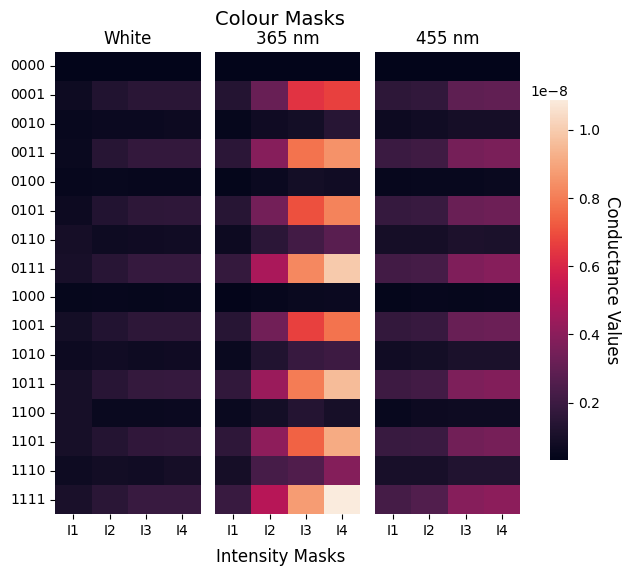

In [8]:

# Set figure size
fig, axes = plt.subplots(1, 3, figsize=(6, 6), sharey=True)

# Set the colormap limits to be the same across all heatmaps
vmin = conductance_values.min()
vmax = conductance_values.max()

# Column labels and heatmap titles
col_labels = ["I1", "I2", "I3", "I4"]
titles = ["White", "365 nm", "455 nm"]

# Generate 4-bit binary labels for the 16 rows
# y_labels = combined_tables[0][0].columns
y_labels = [format(i, '04b') for i in range(16)]
# Add a global title above all heatmaps
fig.suptitle("Colour Masks", fontsize=14, y=0.95)  # Adjusted y-position

# Plot each heatmap
cbar = None  # Placeholder for colorbar
for i in range(3):
    # Show colorbar only for the last heatmap, placing it manually
    cbar_ax = None
    if i == 2:
        cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  # Adjusted position for colorbar

    ax = sns.heatmap(
        conductance_values[i], ax=axes[i],  vmin=vmin, vmax=vmax, 
        cbar=i == 2, cbar_ax=cbar_ax, xticklabels=col_labels, yticklabels=y_labels
    )
    axes[i].set_title(titles[i])  # Set heatmap titles

    # Capture the colorbar object when it's created
    if i == 2:
        cbar = ax.collections[0].colorbar  

    # Hide y-axis ticks for second and third heatmaps
    if i > 0:
        axes[i].tick_params(left=False)

    

# Label the colorbar on the right side
if cbar:
    cbar.ax.yaxis.set_label_position("right")  # Move label to the right
    cbar.ax.set_ylabel("Conductance Values", fontsize=12, rotation=-90, labelpad=15)  # Rotate properly
fig.text(0.5, 0.03, "Intensity Masks", fontsize=12, ha='center')

# Adjust layout
plt.subplots_adjust(wspace=0.1)  # Push heatmaps apart slightly

# Show the plot
plt.show()


In [9]:
combined_tables[0][0][sorted(combined_tables[0][0].columns)]

,0,1,10,11,100,101,110,111,1000,1001,1010,1011,1100,1101,1110,1111
0,3.022600e-10,3.284180e-10,3.229760e-10,3.582200e-10,3.131170e-10,3.584200e-10,3.566230e-10,3.644100e-10,2.707740e-10,3.604410e-10,3.700260e-10,3.835790e-10,3.230760e-10,3.684290e-10,3.510320e-10,3.851270e-10
1,3.050800e-10,3.683790e-10,3.538770e-10,6.930590e-10,3.636610e-10,3.885220e-10,3.945620e-10,3.943620e-10,6.968030e-10,7.158730e-10,7.214140e-10,6.831750e-10,3.760660e-10,6.896150e-10,6.791070e-10,7.016710e-10
2,3.095980e-10,3.753930e-10,3.725720e-10,9.316280e-10,6.968030e-10,7.317720e-10,7.353420e-10,7.236850e-10,5.190880e-10,5.710050e-10,5.742740e-10,5.500130e-10,3.691280e-10,8.902440e-10,9.185730e-10,9.429840e-10
3,3.180350e-10,3.603670e-10,7.005970e-10,6.515510e-10,5.190880e-10,9.505970e-10,5.584500e-10,8.885220e-10,4.883120e-10,5.100020e-10,9.041720e-10,8.044060e-10,7.387860e-10,6.409680e-10,1.056230e-09,1.010180e-09
4,3.140410e-10,7.087340e-10,5.492390e-10,5.937680e-10,4.852670e-10,6.643300e-10,9.230660e-10,9.839440e-10,4.567870e-10,8.648590e-10,6.673750e-10,9.658480e-10,9.379670e-10,9.596330e-10,7.148250e-10,1.055030e-09


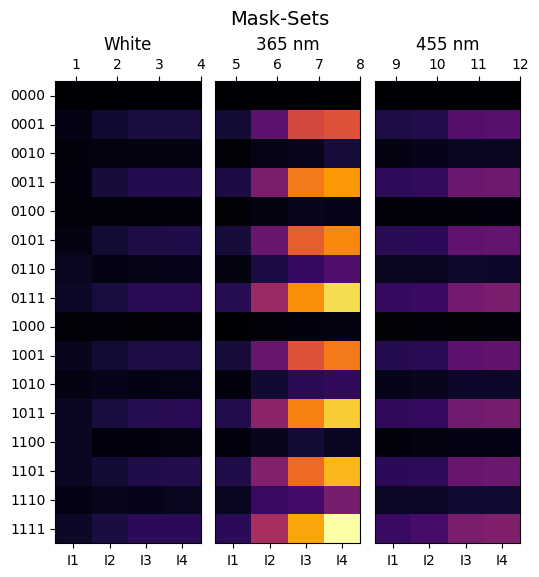

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# # Example conductance_values (Replace this with actual data)
# conductance_values = [np.random.rand(16, 4) for _ in range(3)]  # 16x4 matrices

# Set figure size 
fig, axes = plt.subplots(1, 3, figsize=(6, 6), sharey=True)

# Set the colormap limits to be the same across all heatmaps
vmin = min(c.min() for c in conductance_values)
vmax = max(c.max() for c in conductance_values)

# Column labels and heatmap titles
col_labels = ["I1", "I2", "I3", "I4"]
top_labels = list(range(1, 13))  # Labels from 1 to 12
titles = ["White", "365 nm", "455 nm"]

# Generate 4-bit binary labels for the 16 rows
y_labels = [format(i, '04b') for i in range(16)]

# Add a global title above all heatmaps
fig.suptitle("Mask-Sets", fontsize=14, y=1.0)  # Adjusted y-position

# Plot each heatmap
cbar = None  # Placeholder for colorbar
for i in range(3):
    # Show colorbar only for the last heatmap, placing it manually
    cbar_ax = None
    # if i == 2:
    #     cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  # Adjusted position for colorbar

    ax = sns.heatmap(
        conductance_values[i], ax=axes[i], vmin=vmin, vmax=vmax, cmap='inferno',
        cbar=i == 9, cbar_ax=cbar_ax, xticklabels=col_labels, yticklabels=y_labels
    )
    axes[i].set_title(titles[i])  # Set heatmap titles

    # Create a second x-axis above the heatmap
    top_ax = axes[i].twiny()
    top_ax.set_xticks(np.arange(len(col_labels)) + 0.5)  # Align ticks to center
    top_ax.set_xticklabels(top_labels[len(col_labels)*i:len(col_labels)*(i+1)], fontsize=10)  # Use 1-12 labels
    top_ax.xaxis.set_label_position('top')
    top_ax.xaxis.set_ticks_position('top')

    # Hide y-axis ticks for second and third heatmaps
    if i > 0:
        axes[i].tick_params(left=False)
    
    if i == 2:
        cbar = ax.collections[0].colorbar  

# Label the colorbar on the right side


# Label the colorbar on the right side
# if cbar:
#     cbar.ax.yaxis.set_label_position("right")  # Move label to the right
#     cbar.ax.set_ylabel("Conductance Values", fontsize=12, rotation=-90, labelpad=15)  # Rotate properly
# fig.text(0.5, 0.03, "Intensity Masks", fontsize=12, ha='center')

# Adjust layout
plt.subplots_adjust(wspace=0.1)  # Push heatmaps apart slightly

# Show the plot
plt.show()


In [11]:
NUMBER_OF_MASKS = 3
colour_indices = np.array([0, 1, 2])    # Three colours 365nm, 455 nm, White 
intensity_indices = np.array([0, 1, 2, 3])    # I1, I2, I3, I4
voltage_indices = np.array([4])    # rows in each of I1 to I4


# Generate a meshgrid of all combinations so that we don't sample the same triplet twice
colour_masks, intensity_masks, voltage_masks = np.meshgrid(
    colour_indices, intensity_indices, voltage_indices, indexing='ij'
)

# Flatten the arrays and stack them into an (N,3) array of unique 3D points
all_triplets = np.column_stack((colour_masks.ravel(), intensity_masks.ravel(), voltage_masks.ravel()))

# Randomly select unique 3D points
unique_indices = np.random.choice(all_triplets.shape[0], size=NUMBER_OF_MASKS, replace=False)
selected_triplets = all_triplets[unique_indices]

# Extract the selected masks
colour_masks = selected_triplets[:, 0]
intensity_masks = selected_triplets[:, 1]
voltage_masks = selected_triplets[:, 2]

# Uncomment to override

# colour_masks = np.array([1, 1, 1, 2, 2, 2, 1, 2])
# intensity_masks = np.array([1, 3, 2, 1, 2, 3, 1, 0])
# voltage_masks = np.array([4, 4, 4, 4, 4, 4, 3, 4])

colour_masks = np.array([1,])
intensity_masks = np.array([1,])
voltage_masks = np.array([4, ])
NUMBER_OF_MASKS = (len(colour_masks) == len(intensity_masks)) * len(colour_masks)

number_of_devices = 28 * 28 // 4
print("Selected Colour Masks:", colour_masks)
print("Selected Intensity Masks:", intensity_masks)
print("Selected Voltage Masks:", voltage_masks)

Selected Colour Masks: [1]
Selected Intensity Masks: [1]
Selected Voltage Masks: [4]


In [12]:
# combined_tables[colour_masks[0]][intensity_masks[0]].loc[voltage_masks[0]].to_dict()

In [13]:

class CustomDataset(Dataset):
    def __init__(self, mnist_data, combined_tables, colour_masks, intensity_masks, voltage_masks, number_of_devices=number_of_devices):
        super().__init__()

        self.processed_data = []
        self.labels = []

        # Convert to NumPy if applying transform
        if mnist_data.transform is not None:
            # data = torch.stack([mnist_data.transform(img) for img in mnist_data.data])
            data = mnist_data.transform(mnist_data.data)
        
        # Reshape the data
        data = data.reshape((data.shape[0], number_of_devices, 4))
        data = (
            data[:, :, 0]*1000+
            data[:, :, 1]*100+
            data[:, :, 2]*10+
            data[:, :, 3]
        )
        for colour_mask, intensity_mask, voltage_mask in zip(colour_masks, intensity_masks, voltage_masks):
            mapping_dict = combined_tables[colour_mask][intensity_mask].loc[voltage_mask].to_dict()
            reservoir_output = np.vectorize(mapping_dict.get)(data)
            self.processed_data.append(reservoir_output)
        
        self.processed_data = np.concatenate(self.processed_data, axis=1) * 1e9

        self.labels = torch.tensor(mnist_data.targets, device=device)
        self.processed_data = torch.tensor(self.processed_data, device=device)


    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]
    


In [14]:
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x
    
class SNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SNN, self).__init__()

        # self.snn1 = SNNLayer(input_size=input_size, output_size=128)
        # self.snn2 = SNNLayer(input_size=128, output_size=num_classes)

        self.readout_layer = SNNLayer(input_size=input_size, output_size=num_classes)
        # self.readout_layer = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1, x.size(-1))
        # x = self.snn1(x)
        # x = self.snn2(x)
        x = self.readout_layer(x)
        return x.mean(-1)
    


In [15]:
mnist_data_train.transform(mnist_data_train.data).shape

torch.Size([60000, 28, 28])

In [16]:

BATCH_SIZE = 1024


train_dataset = CustomDataset(mnist_data_train, combined_tables, colour_masks, intensity_masks, voltage_masks)
test_dataset = CustomDataset(mnist_data_test, combined_tables, colour_masks, intensity_masks, voltage_masks)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



C:\Users\adith\AppData\Local\Temp\ipykernel_14652\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


In [ ]:
img = train_dataset[567][0].reshape((image_size//2, image_size//2)).cpu()

plt.imshow(img)

In [18]:
def get_datasets(train_dataset, test_dataset, combined_tables=combined_tables, 
                 colour_masks=colour_masks, 
                 intensity_masks=intensity_masks,
                 voltage_masks=voltage_masks):
    return CustomDataset(train_dataset, combined_tables, colour_masks, intensity_masks, voltage_masks), \
            CustomDataset(test_dataset, combined_tables, colour_masks, intensity_masks, voltage_masks)

def get_loaders(train_ds:CustomDataset, test_ds:CustomDataset, BATCH_SIZE=BATCH_SIZE):
    return DataLoader(train_ds, BATCH_SIZE, shuffle=True), \
            DataLoader(test_ds, BATCH_SIZE, shuffle=False)

In [19]:

EPOCHS = 300
learning_rate = 0.0005
# learning_rate = 1e-3

model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/300], Loss: 1.4964 Validation - Accuracy: 0.4732 Precision: 0.4712  Recall: 0.4732 F1 Score: 0.4249
Epoch [2/300], Loss: 1.1308 Validation - Accuracy: 0.5978 Precision: 0.5511  Recall: 0.5978 F1 Score: 0.5638
Epoch [3/300], Loss: 0.9932 Validation - Accuracy: 0.6306 Precision: 0.5854  Recall: 0.6306 F1 Score: 0.5984
Epoch [4/300], Loss: 0.9367 Validation - Accuracy: 0.6556 Precision: 0.7048  Recall: 0.6556 F1 Score: 0.6222
Epoch [5/300], Loss: 0.6540 Validation - Accuracy: 0.7471 Precision: 0.7477  Recall: 0.7471 F1 Score: 0.7438
Epoch [6/300], Loss: 0.6589 Validation - Accuracy: 0.7575 Precision: 0.7582  Recall: 0.7575 F1 Score: 0.7544
Epoch [7/300], Loss: 0.6422 Validation - Accuracy: 0.7611 Precision: 0.7633  Recall: 0.7611 F1 Score: 0.7611
Epoch [8/300], Loss: 0.6566 Validation - Accuracy: 0.7701 Precision: 0.7695  Recall: 0.7701 F1 Score: 0.7678
Epoch [9/300], Loss: 0.6214 Validation - Accuracy: 0.7718 Precision: 0.7702  Recall: 0.7718 F1 Score: 0.7688
Epoch [10/300], Los

In [ ]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

Test Accuracy: 81.55%
Test Precision: 81.6586%
Test Recall: 81.5500%
Test F1 Score: 0.8157


C:\Users\adith\AppData\Local\Temp\ipykernel_11764\3800262208.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


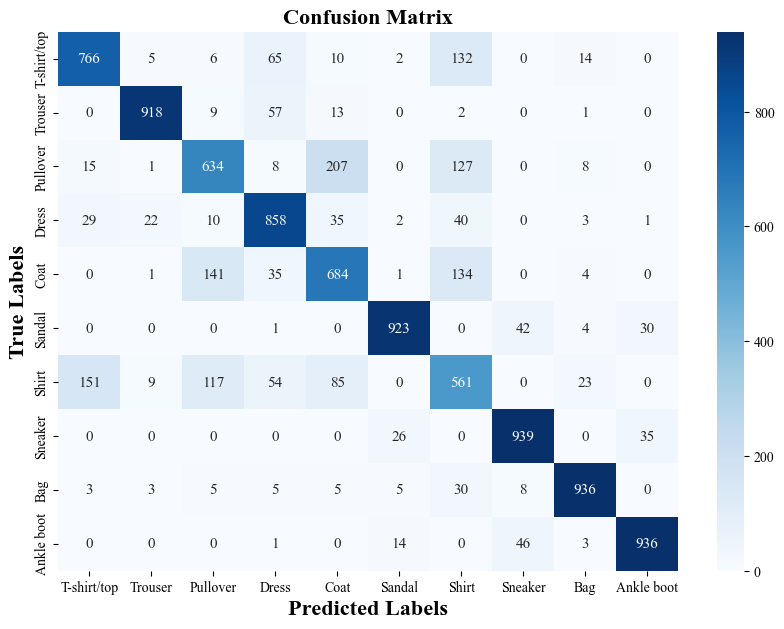

In [ ]:

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=mnist_data_train.classes, 
            yticklabels=mnist_data_train.classes,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
x = np.argmax(val_fscore)
print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

0.8180999755859375 0.8178809881210327 0.8180999755859375 0.8172796964645386


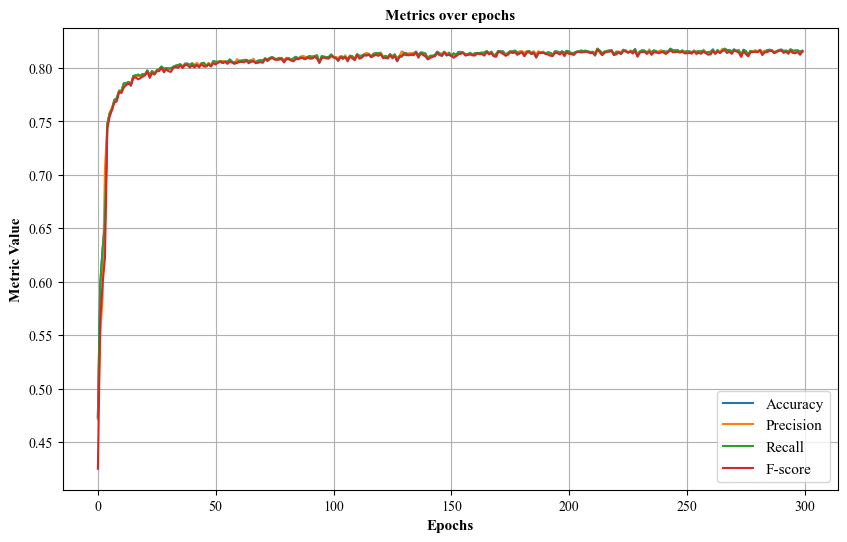

In [ ]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [ ]:
accuracy_df = pd.DataFrame({"Accuracy" :[x*1.004 for x in val_accuracy]})

accuracy_df.to_excel("data/accuracy_metrics/temp.xlsx")


In [21]:
def get_metrics(train_loader, test_loader, number_of_devices, NUMBER_OF_MASKS, EPOCHS=300):
    
    learning_rate = 0.0005
    # learning_rate = 1e-3

    model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
    # model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
    precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
    recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
    f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)

    for epoch in range(EPOCHS):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            # spike_train = temporal_encode(images)
            outputs = model(images.float())  # Forward pass
            # outputs = model(spike_train)
            loss = criterion(outputs, labels)  # Loss calculation
            optimizer.zero_grad()
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
        
        
        # Validation phase
        # model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images, labels
                # spike_train = temporal_encode(images)
                outputs = model(images.float())
                # outputs = model(spike_train)
                preds = outputs.argmax(dim=1)

                # Update metrics
                accuracy.update(preds, labels)
                precision.update(preds, labels)
                recall.update(preds, labels)
                f1_score.update(preds, labels)

            # Print validation metrics

            if (epoch+1)%10 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
                print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
                print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

            # Updating the list to save current metrics
            val_accuracy.append(accuracy.compute().item())
            val_precision.append(precision.compute().item())
            val_recall.append(recall.compute().item())
            val_fscore.append(f1_score.compute().item())

            # Reset metrics for the next epoch
            accuracy.reset()
            precision.reset()
            recall.reset()
            f1_score.reset()
            confusion_matrix.reset()


    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            # spike_train = temporal_encode(images)
            outputs = model(torch.tensor(images, dtype=torch.float32))
            # outputs = model(spike_train)
            _, predicted = torch.max(outputs, 1)

            # Append predictions and labels for metric calculations
            all_preds.append(predicted)
            all_labels.append(labels)


    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds).to(device)
    all_labels = torch.cat(all_labels).to(device)

    # Calculate metrics
    test_accuracy = accuracy(all_preds, all_labels)
    test_precision = precision(all_preds, all_labels)
    test_recall = recall(all_preds, all_labels)
    test_f1 = f1_score(all_preds, all_labels)
    test_confusion_matrix = confusion_matrix(all_preds, all_labels)

    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Test Precision: {test_precision*100:.4f}%')
    print(f'Test Recall: {test_recall*100:.4f}%')
    print(f'Test F1 Score: {test_f1:.4f}')

    x = np.argmax(val_fscore)
    return (val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

            
        


In [20]:
metrics_df = pd.DataFrame(columns=["colour mask", "intensity mask", "accuracy", "precision", "recall", "fscore"])
colors = ["365nm", "455nm", "White"]
intensities = ["I1", "I2", "I3", "I4"]
# metrics_df.loc[len(metrics_df)] = [0, 0, 0, 1, 1, 1, 1]
# metrics_df

In [21]:

for colour_mask in colour_indices:
    for intensity_mask in intensity_indices:
        for voltage_mask in voltage_indices:
            print(colour_mask, intensity_mask, voltage_mask)

            train_ds, test_ds = get_datasets(mnist_data_train, mnist_data_test, combined_tables,
                                 colour_masks=np.array([colour_mask]),
                                 intensity_masks=np.array([intensity_mask]),
                                 voltage_masks=np.array([voltage_mask]))

            train_loader, test_loader = get_loaders(train_ds, test_ds, BATCH_SIZE)

            (best_accuracy, best_precision, best_recall, best_fscore), train_metrics = get_metrics(train_loader, test_loader,number_of_devices, 1, EPOCHS=300)
            metrics_df.loc[len(metrics_df)] = [colors[colour_mask], intensities[intensity_mask],
                                               best_accuracy, best_precision, best_recall, best_fscore]




0 0 4


C:\Users\adith\AppData\Local\Temp\ipykernel_11764\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/300], Loss: 1.2813 Validation - Accuracy: 0.7772 Precision: 0.7873  Recall: 0.7713 F1 Score: 0.7695
Epoch [20/300], Loss: 0.8834 Validation - Accuracy: 0.8054 Precision: 0.8080  Recall: 0.8013 F1 Score: 0.8014
Epoch [30/300], Loss: 0.7544 Validation - Accuracy: 0.8199 Precision: 0.8226  Recall: 0.8161 F1 Score: 0.8166
Epoch [40/300], Loss: 0.6786 Validation - Accuracy: 0.8275 Precision: 0.8279  Recall: 0.8243 F1 Score: 0.8246
Epoch [50/300], Loss: 0.5873 Validation - Accuracy: 0.8342 Precision: 0.8342  Recall: 0.8313 F1 Score: 0.8317


KeyboardInterrupt: 

In [ ]:
metrics_df

In [22]:
metrics_df = pd.DataFrame(columns=['First Mask', 'Second Mask', 'Accuracy', 'Precision', 'Recall', 'F-score'])
colors = ["365nm", "455nm", "White"]
intensities = ["I1", "I2", "I3", "I4"]




combinations =  [(colour, intensity, 4) for colour in range(len(colors)) for intensity in range(len(intensities)) ]

for i in range(len(combinations)):
    for j in range(len(combinations)):
            
            # print(colour_mask, intensity_mask, voltage_mask)
            print(i, j)
            print(f"{colors[combinations[i][0]]} {intensities[combinations[i][1]]}", f"{colors[combinations[j][0]]} {intensities[combinations[j][1]]}" )

            train_ds, test_ds = get_datasets(mnist_data_train, mnist_data_test, combined_tables,
                                 colour_masks=np.array([combinations[i][0], combinations[j][0]]),
                                 intensity_masks=np.array([combinations[i][1], combinations[j][1]]),
                                 voltage_masks=np.array([combinations[i][2], combinations[j][2]]))

            train_loader, test_loader = get_loaders(train_ds, test_ds, BATCH_SIZE=1024)

            (best_accuracy, best_precision, best_recall, best_fscore) = get_metrics(train_loader, test_loader,number_of_devices, 2, EPOCHS=100)
            metrics_df.loc[len(metrics_df)] = [f"{colors[combinations[i][0]]} {intensities[combinations[i][1]]}", f"{colors[combinations[j][0]]} {intensities[combinations[j][1]]}" ,
                                               best_accuracy, best_precision, best_recall, best_fscore]

0 0
365nm I1 365nm I1


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.6742 Validation - Accuracy: 0.8582 Precision: 0.8585  Recall: 0.8558 F1 Score: 0.8561
Epoch [20/100], Loss: 0.4514 Validation - Accuracy: 0.8762 Precision: 0.8762  Recall: 0.8743 F1 Score: 0.8745
Epoch [30/100], Loss: 0.4082 Validation - Accuracy: 0.8840 Precision: 0.8834  Recall: 0.8826 F1 Score: 0.8827
Epoch [40/100], Loss: 0.4152 Validation - Accuracy: 0.8892 Precision: 0.8887  Recall: 0.8880 F1 Score: 0.8881
Epoch [50/100], Loss: 0.3356 Validation - Accuracy: 0.8926 Precision: 0.8922  Recall: 0.8915 F1 Score: 0.8916
Epoch [60/100], Loss: 0.3861 Validation - Accuracy: 0.8923 Precision: 0.8919  Recall: 0.8910 F1 Score: 0.8910
Epoch [70/100], Loss: 0.3873 Validation - Accuracy: 0.8950 Precision: 0.8947  Recall: 0.8938 F1 Score: 0.8939
Epoch [80/100], Loss: 0.3452 Validation - Accuracy: 0.8956 Precision: 0.8950  Recall: 0.8945 F1 Score: 0.8945
Epoch [90/100], Loss: 0.3853 Validation - Accuracy: 0.8953 Precision: 0.8949  Recall: 0.8941 F1 Score: 0.8942
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 89.67%
Test Precision: 89.6397%
Test Recall: 89.5514%
Test F1 Score: 0.8957
0 1
365nm I1 365nm I2


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5483 Validation - Accuracy: 0.8743 Precision: 0.8747  Recall: 0.8725 F1 Score: 0.8728
Epoch [20/100], Loss: 0.3637 Validation - Accuracy: 0.8900 Precision: 0.8896  Recall: 0.8887 F1 Score: 0.8888
Epoch [30/100], Loss: 0.4067 Validation - Accuracy: 0.8954 Precision: 0.8950  Recall: 0.8943 F1 Score: 0.8942
Epoch [40/100], Loss: 0.3547 Validation - Accuracy: 0.8976 Precision: 0.8969  Recall: 0.8964 F1 Score: 0.8964
Epoch [50/100], Loss: 0.3214 Validation - Accuracy: 0.9012 Precision: 0.9004  Recall: 0.9001 F1 Score: 0.9001
Epoch [60/100], Loss: 0.3704 Validation - Accuracy: 0.9026 Precision: 0.9021  Recall: 0.9016 F1 Score: 0.9015
Epoch [70/100], Loss: 0.3066 Validation - Accuracy: 0.9043 Precision: 0.9033  Recall: 0.9032 F1 Score: 0.9031
Epoch [80/100], Loss: 0.2939 Validation - Accuracy: 0.9052 Precision: 0.9046  Recall: 0.9043 F1 Score: 0.9043
Epoch [90/100], Loss: 0.3277 Validation - Accuracy: 0.9062 Precision: 0.9055  Recall: 0.9052 F1 Score: 0.9052
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


0 2
365nm I1 365nm I3


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5388 Validation - Accuracy: 0.8774 Precision: 0.8775  Recall: 0.8756 F1 Score: 0.8758
Epoch [20/100], Loss: 0.3929 Validation - Accuracy: 0.8910 Precision: 0.8901  Recall: 0.8896 F1 Score: 0.8895
Epoch [30/100], Loss: 0.4275 Validation - Accuracy: 0.8959 Precision: 0.8953  Recall: 0.8946 F1 Score: 0.8946
Epoch [40/100], Loss: 0.3243 Validation - Accuracy: 0.8994 Precision: 0.8984  Recall: 0.8983 F1 Score: 0.8982
Epoch [50/100], Loss: 0.3136 Validation - Accuracy: 0.9014 Precision: 0.9009  Recall: 0.9002 F1 Score: 0.9002
Epoch [60/100], Loss: 0.3257 Validation - Accuracy: 0.9040 Precision: 0.9031  Recall: 0.9030 F1 Score: 0.9030
Epoch [70/100], Loss: 0.3471 Validation - Accuracy: 0.9049 Precision: 0.9041  Recall: 0.9039 F1 Score: 0.9038
Epoch [80/100], Loss: 0.3161 Validation - Accuracy: 0.9061 Precision: 0.9051  Recall: 0.9051 F1 Score: 0.9049
Epoch [90/100], Loss: 0.2861 Validation - Accuracy: 0.9068 Precision: 0.9058  Recall: 0.9059 F1 Score: 0.9057
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4913 Validation - Accuracy: 0.8774 Precision: 0.8784  Recall: 0.8756 F1 Score: 0.8760
Epoch [20/100], Loss: 0.3585 Validation - Accuracy: 0.8930 Precision: 0.8927  Recall: 0.8917 F1 Score: 0.8918
Epoch [30/100], Loss: 0.3607 Validation - Accuracy: 0.8979 Precision: 0.8974  Recall: 0.8969 F1 Score: 0.8968
Epoch [40/100], Loss: 0.3958 Validation - Accuracy: 0.9004 Precision: 0.8999  Recall: 0.8992 F1 Score: 0.8992
Epoch [50/100], Loss: 0.3471 Validation - Accuracy: 0.9034 Precision: 0.9025  Recall: 0.9024 F1 Score: 0.9023
Epoch [60/100], Loss: 0.3153 Validation - Accuracy: 0.9052 Precision: 0.9044  Recall: 0.9041 F1 Score: 0.9040
Epoch [70/100], Loss: 0.2938 Validation - Accuracy: 0.9055 Precision: 0.9047  Recall: 0.9046 F1 Score: 0.9045
Epoch [80/100], Loss: 0.3485 Validation - Accuracy: 0.9056 Precision: 0.9055  Recall: 0.9043 F1 Score: 0.9045
Epoch [90/100], Loss: 0.2970 Validation - Accuracy: 0.9075 Precision: 0.9071  Recall: 0.9063 F1 Score: 0.9064
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4569 Validation - Accuracy: 0.8786 Precision: 0.8783  Recall: 0.8769 F1 Score: 0.8770
Epoch [20/100], Loss: 0.3586 Validation - Accuracy: 0.8924 Precision: 0.8915  Recall: 0.8911 F1 Score: 0.8910
Epoch [30/100], Loss: 0.3907 Validation - Accuracy: 0.8972 Precision: 0.8966  Recall: 0.8959 F1 Score: 0.8960
Epoch [40/100], Loss: 0.3945 Validation - Accuracy: 0.9019 Precision: 0.9011  Recall: 0.9008 F1 Score: 0.9007
Epoch [50/100], Loss: 0.3283 Validation - Accuracy: 0.9043 Precision: 0.9037  Recall: 0.9031 F1 Score: 0.9031
Epoch [60/100], Loss: 0.3162 Validation - Accuracy: 0.9056 Precision: 0.9051  Recall: 0.9046 F1 Score: 0.9045
Epoch [70/100], Loss: 0.3253 Validation - Accuracy: 0.9086 Precision: 0.9082  Recall: 0.9075 F1 Score: 0.9075
Epoch [80/100], Loss: 0.3900 Validation - Accuracy: 0.9088 Precision: 0.9080  Recall: 0.9079 F1 Score: 0.9078
Epoch [90/100], Loss: 0.3154 Validation - Accuracy: 0.9097 Precision: 0.9091  Recall: 0.9087 F1 Score: 0.9087
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3963 Validation - Accuracy: 0.8944 Precision: 0.8938  Recall: 0.8929 F1 Score: 0.8930
Epoch [20/100], Loss: 0.3426 Validation - Accuracy: 0.9017 Precision: 0.9009  Recall: 0.9006 F1 Score: 0.9006
Epoch [30/100], Loss: 0.3196 Validation - Accuracy: 0.9056 Precision: 0.9046  Recall: 0.9044 F1 Score: 0.9044
Epoch [40/100], Loss: 0.3449 Validation - Accuracy: 0.9065 Precision: 0.9060  Recall: 0.9053 F1 Score: 0.9054
Epoch [50/100], Loss: 0.3143 Validation - Accuracy: 0.9079 Precision: 0.9074  Recall: 0.9067 F1 Score: 0.9068
Epoch [60/100], Loss: 0.3613 Validation - Accuracy: 0.9091 Precision: 0.9083  Recall: 0.9080 F1 Score: 0.9080
Epoch [70/100], Loss: 0.2502 Validation - Accuracy: 0.9106 Precision: 0.9097  Recall: 0.9095 F1 Score: 0.9094
Epoch [80/100], Loss: 0.2900 Validation - Accuracy: 0.9099 Precision: 0.9091  Recall: 0.9089 F1 Score: 0.9088
Epoch [90/100], Loss: 0.3044 Validation - Accuracy: 0.9113 Precision: 0.9105  Recall: 0.9100 F1 Score: 0.9101
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3433 Validation - Accuracy: 0.8925 Precision: 0.8914  Recall: 0.8913 F1 Score: 0.8912
Epoch [20/100], Loss: 0.3773 Validation - Accuracy: 0.8973 Precision: 0.8966  Recall: 0.8959 F1 Score: 0.8960
Epoch [30/100], Loss: 0.2821 Validation - Accuracy: 0.9014 Precision: 0.9005  Recall: 0.9004 F1 Score: 0.9003
Epoch [40/100], Loss: 0.2864 Validation - Accuracy: 0.9034 Precision: 0.9024  Recall: 0.9023 F1 Score: 0.9022
Epoch [50/100], Loss: 0.2741 Validation - Accuracy: 0.9041 Precision: 0.9036  Recall: 0.9029 F1 Score: 0.9031
Epoch [60/100], Loss: 0.3724 Validation - Accuracy: 0.9046 Precision: 0.9039  Recall: 0.9035 F1 Score: 0.9035
Epoch [70/100], Loss: 0.2668 Validation - Accuracy: 0.9061 Precision: 0.9053  Recall: 0.9049 F1 Score: 0.9050
Epoch [80/100], Loss: 0.2773 Validation - Accuracy: 0.9056 Precision: 0.9052  Recall: 0.9044 F1 Score: 0.9046
Epoch [90/100], Loss: 0.3376 Validation - Accuracy: 0.9064 Precision: 0.9057  Recall: 0.9051 F1 Score: 0.9053
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3515 Validation - Accuracy: 0.8956 Precision: 0.8943  Recall: 0.8942 F1 Score: 0.8942
Epoch [20/100], Loss: 0.3593 Validation - Accuracy: 0.9024 Precision: 0.9015  Recall: 0.9010 F1 Score: 0.9011
Epoch [30/100], Loss: 0.2805 Validation - Accuracy: 0.9056 Precision: 0.9048  Recall: 0.9043 F1 Score: 0.9043
Epoch [40/100], Loss: 0.2804 Validation - Accuracy: 0.9063 Precision: 0.9062  Recall: 0.9049 F1 Score: 0.9051
Epoch [50/100], Loss: 0.3141 Validation - Accuracy: 0.9077 Precision: 0.9069  Recall: 0.9066 F1 Score: 0.9066
Epoch [60/100], Loss: 0.3256 Validation - Accuracy: 0.9077 Precision: 0.9074  Recall: 0.9065 F1 Score: 0.9066
Epoch [70/100], Loss: 0.2471 Validation - Accuracy: 0.9091 Precision: 0.9091  Recall: 0.9078 F1 Score: 0.9081
Epoch [80/100], Loss: 0.2940 Validation - Accuracy: 0.9085 Precision: 0.9089  Recall: 0.9072 F1 Score: 0.9074
Epoch [90/100], Loss: 0.2767 Validation - Accuracy: 0.9100 Precision: 0.9091  Recall: 0.9090 F1 Score: 0.9089
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4854 Validation - Accuracy: 0.8827 Precision: 0.8818  Recall: 0.8813 F1 Score: 0.8813
Epoch [20/100], Loss: 0.3899 Validation - Accuracy: 0.8942 Precision: 0.8934  Recall: 0.8928 F1 Score: 0.8928
Epoch [30/100], Loss: 0.3757 Validation - Accuracy: 0.8977 Precision: 0.8973  Recall: 0.8964 F1 Score: 0.8965
Epoch [40/100], Loss: 0.3465 Validation - Accuracy: 0.9008 Precision: 0.9002  Recall: 0.8996 F1 Score: 0.8996
Epoch [50/100], Loss: 0.2902 Validation - Accuracy: 0.9045 Precision: 0.9034  Recall: 0.9034 F1 Score: 0.9033
Epoch [60/100], Loss: 0.3240 Validation - Accuracy: 0.9067 Precision: 0.9057  Recall: 0.9057 F1 Score: 0.9055
Epoch [70/100], Loss: 0.2896 Validation - Accuracy: 0.9069 Precision: 0.9064  Recall: 0.9058 F1 Score: 0.9058
Epoch [80/100], Loss: 0.2792 Validation - Accuracy: 0.9075 Precision: 0.9068  Recall: 0.9065 F1 Score: 0.9065
Epoch [90/100], Loss: 0.2728 Validation - Accuracy: 0.9079 Precision: 0.9071  Recall: 0.9070 F1 Score: 0.9069
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4449 Validation - Accuracy: 0.8839 Precision: 0.8834  Recall: 0.8823 F1 Score: 0.8823
Epoch [20/100], Loss: 0.4121 Validation - Accuracy: 0.8942 Precision: 0.8938  Recall: 0.8928 F1 Score: 0.8929
Epoch [30/100], Loss: 0.3770 Validation - Accuracy: 0.9002 Precision: 0.8994  Recall: 0.8990 F1 Score: 0.8990
Epoch [40/100], Loss: 0.3335 Validation - Accuracy: 0.9027 Precision: 0.9018  Recall: 0.9016 F1 Score: 0.9015
Epoch [50/100], Loss: 0.3005 Validation - Accuracy: 0.9054 Precision: 0.9044  Recall: 0.9043 F1 Score: 0.9042
Epoch [60/100], Loss: 0.2851 Validation - Accuracy: 0.9078 Precision: 0.9067  Recall: 0.9067 F1 Score: 0.9065
Epoch [70/100], Loss: 0.3476 Validation - Accuracy: 0.9068 Precision: 0.9062  Recall: 0.9058 F1 Score: 0.9058
Epoch [80/100], Loss: 0.3034 Validation - Accuracy: 0.9091 Precision: 0.9084  Recall: 0.9079 F1 Score: 0.9079
Epoch [90/100], Loss: 0.3357 Validation - Accuracy: 0.9098 Precision: 0.9093  Recall: 0.9087 F1 Score: 0.9088
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3780 Validation - Accuracy: 0.8857 Precision: 0.8853  Recall: 0.8841 F1 Score: 0.8842
Epoch [20/100], Loss: 0.3594 Validation - Accuracy: 0.8958 Precision: 0.8947  Recall: 0.8946 F1 Score: 0.8945
Epoch [30/100], Loss: 0.2972 Validation - Accuracy: 0.9005 Precision: 0.8995  Recall: 0.8994 F1 Score: 0.8993
Epoch [40/100], Loss: 0.3490 Validation - Accuracy: 0.9022 Precision: 0.9012  Recall: 0.9011 F1 Score: 0.9010
Epoch [50/100], Loss: 0.2938 Validation - Accuracy: 0.9045 Precision: 0.9036  Recall: 0.9034 F1 Score: 0.9034
Epoch [60/100], Loss: 0.3136 Validation - Accuracy: 0.9043 Precision: 0.9034  Recall: 0.9031 F1 Score: 0.9031
Epoch [70/100], Loss: 0.3176 Validation - Accuracy: 0.9048 Precision: 0.9043  Recall: 0.9038 F1 Score: 0.9039
Epoch [80/100], Loss: 0.2893 Validation - Accuracy: 0.9066 Precision: 0.9056  Recall: 0.9056 F1 Score: 0.9055
Epoch [90/100], Loss: 0.2629 Validation - Accuracy: 0.9072 Precision: 0.9064  Recall: 0.9060 F1 Score: 0.9060
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4270 Validation - Accuracy: 0.8883 Precision: 0.8872  Recall: 0.8870 F1 Score: 0.8869
Epoch [20/100], Loss: 0.3685 Validation - Accuracy: 0.8956 Precision: 0.8950  Recall: 0.8945 F1 Score: 0.8945
Epoch [30/100], Loss: 0.3905 Validation - Accuracy: 0.9004 Precision: 0.8996  Recall: 0.8992 F1 Score: 0.8992
Epoch [40/100], Loss: 0.4191 Validation - Accuracy: 0.9013 Precision: 0.9006  Recall: 0.9001 F1 Score: 0.9001
Epoch [50/100], Loss: 0.3224 Validation - Accuracy: 0.9026 Precision: 0.9018  Recall: 0.9015 F1 Score: 0.9014
Epoch [60/100], Loss: 0.3494 Validation - Accuracy: 0.9047 Precision: 0.9036  Recall: 0.9036 F1 Score: 0.9035
Epoch [70/100], Loss: 0.3024 Validation - Accuracy: 0.9050 Precision: 0.9046  Recall: 0.9039 F1 Score: 0.9040
Epoch [80/100], Loss: 0.2611 Validation - Accuracy: 0.9067 Precision: 0.9059  Recall: 0.9057 F1 Score: 0.9057
Epoch [90/100], Loss: 0.2725 Validation - Accuracy: 0.9070 Precision: 0.9059  Recall: 0.9060 F1 Score: 0.9058
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5580 Validation - Accuracy: 0.8725 Precision: 0.8736  Recall: 0.8705 F1 Score: 0.8709
Epoch [20/100], Loss: 0.4316 Validation - Accuracy: 0.8887 Precision: 0.8884  Recall: 0.8874 F1 Score: 0.8875
Epoch [30/100], Loss: 0.3880 Validation - Accuracy: 0.8943 Precision: 0.8935  Recall: 0.8932 F1 Score: 0.8931
Epoch [40/100], Loss: 0.3594 Validation - Accuracy: 0.8999 Precision: 0.8990  Recall: 0.8989 F1 Score: 0.8987
Epoch [50/100], Loss: 0.3136 Validation - Accuracy: 0.9027 Precision: 0.9015  Recall: 0.9018 F1 Score: 0.9015
Epoch [60/100], Loss: 0.3105 Validation - Accuracy: 0.9030 Precision: 0.9022  Recall: 0.9020 F1 Score: 0.9019
Epoch [70/100], Loss: 0.3287 Validation - Accuracy: 0.9054 Precision: 0.9048  Recall: 0.9043 F1 Score: 0.9043
Epoch [80/100], Loss: 0.3220 Validation - Accuracy: 0.9066 Precision: 0.9055  Recall: 0.9056 F1 Score: 0.9055
Epoch [90/100], Loss: 0.2625 Validation - Accuracy: 0.9073 Precision: 0.9061  Recall: 0.9064 F1 Score: 0.9061
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5413 Validation - Accuracy: 0.8754 Precision: 0.8749  Recall: 0.8738 F1 Score: 0.8740
Epoch [20/100], Loss: 0.4065 Validation - Accuracy: 0.8872 Precision: 0.8867  Recall: 0.8858 F1 Score: 0.8859
Epoch [30/100], Loss: 0.3598 Validation - Accuracy: 0.8925 Precision: 0.8916  Recall: 0.8913 F1 Score: 0.8912
Epoch [40/100], Loss: 0.3788 Validation - Accuracy: 0.8956 Precision: 0.8950  Recall: 0.8944 F1 Score: 0.8945
Epoch [50/100], Loss: 0.3732 Validation - Accuracy: 0.8972 Precision: 0.8963  Recall: 0.8961 F1 Score: 0.8960
Epoch [60/100], Loss: 0.3628 Validation - Accuracy: 0.8968 Precision: 0.8963  Recall: 0.8958 F1 Score: 0.8958
Epoch [70/100], Loss: 0.3250 Validation - Accuracy: 0.8984 Precision: 0.8979  Recall: 0.8973 F1 Score: 0.8973
Epoch [80/100], Loss: 0.2966 Validation - Accuracy: 0.8982 Precision: 0.8977  Recall: 0.8970 F1 Score: 0.8970
Epoch [90/100], Loss: 0.3261 Validation - Accuracy: 0.8989 Precision: 0.8985  Recall: 0.8977 F1 Score: 0.8978
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4802 Validation - Accuracy: 0.8760 Precision: 0.8757  Recall: 0.8745 F1 Score: 0.8747
Epoch [20/100], Loss: 0.4633 Validation - Accuracy: 0.8876 Precision: 0.8870  Recall: 0.8862 F1 Score: 0.8863
Epoch [30/100], Loss: 0.4270 Validation - Accuracy: 0.8928 Precision: 0.8923  Recall: 0.8914 F1 Score: 0.8914
Epoch [40/100], Loss: 0.3511 Validation - Accuracy: 0.8937 Precision: 0.8932  Recall: 0.8926 F1 Score: 0.8926
Epoch [50/100], Loss: 0.3753 Validation - Accuracy: 0.8970 Precision: 0.8960  Recall: 0.8959 F1 Score: 0.8958
Epoch [60/100], Loss: 0.3479 Validation - Accuracy: 0.8977 Precision: 0.8971  Recall: 0.8965 F1 Score: 0.8965
Epoch [70/100], Loss: 0.3972 Validation - Accuracy: 0.8985 Precision: 0.8976  Recall: 0.8974 F1 Score: 0.8974
Epoch [80/100], Loss: 0.3375 Validation - Accuracy: 0.8979 Precision: 0.8970  Recall: 0.8968 F1 Score: 0.8968
Epoch [90/100], Loss: 0.3661 Validation - Accuracy: 0.8993 Precision: 0.8988  Recall: 0.8981 F1 Score: 0.8982
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4719 Validation - Accuracy: 0.8772 Precision: 0.8768  Recall: 0.8757 F1 Score: 0.8759
Epoch [20/100], Loss: 0.4026 Validation - Accuracy: 0.8896 Precision: 0.8887  Recall: 0.8883 F1 Score: 0.8883
Epoch [30/100], Loss: 0.4052 Validation - Accuracy: 0.8926 Precision: 0.8917  Recall: 0.8914 F1 Score: 0.8914
Epoch [40/100], Loss: 0.3911 Validation - Accuracy: 0.8963 Precision: 0.8954  Recall: 0.8951 F1 Score: 0.8950
Epoch [50/100], Loss: 0.3248 Validation - Accuracy: 0.8967 Precision: 0.8962  Recall: 0.8955 F1 Score: 0.8956
Epoch [60/100], Loss: 0.3192 Validation - Accuracy: 0.8988 Precision: 0.8984  Recall: 0.8975 F1 Score: 0.8976
Epoch [70/100], Loss: 0.3239 Validation - Accuracy: 0.8999 Precision: 0.8988  Recall: 0.8988 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3305 Validation - Accuracy: 0.8994 Precision: 0.8982  Recall: 0.8984 F1 Score: 0.8982
Epoch [90/100], Loss: 0.3616 Validation - Accuracy: 0.9009 Precision: 0.9003  Recall: 0.8996 F1 Score: 0.8997
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5226 Validation - Accuracy: 0.8779 Precision: 0.8775  Recall: 0.8762 F1 Score: 0.8764
Epoch [20/100], Loss: 0.3689 Validation - Accuracy: 0.8924 Precision: 0.8914  Recall: 0.8911 F1 Score: 0.8911
Epoch [30/100], Loss: 0.3708 Validation - Accuracy: 0.8958 Precision: 0.8951  Recall: 0.8946 F1 Score: 0.8946
Epoch [40/100], Loss: 0.3661 Validation - Accuracy: 0.8982 Precision: 0.8978  Recall: 0.8968 F1 Score: 0.8969
Epoch [50/100], Loss: 0.4286 Validation - Accuracy: 0.8994 Precision: 0.8987  Recall: 0.8982 F1 Score: 0.8982
Epoch [60/100], Loss: 0.3380 Validation - Accuracy: 0.9009 Precision: 0.9000  Recall: 0.8998 F1 Score: 0.8998
Epoch [70/100], Loss: 0.3626 Validation - Accuracy: 0.9021 Precision: 0.9011  Recall: 0.9011 F1 Score: 0.9010
Epoch [80/100], Loss: 0.3119 Validation - Accuracy: 0.9017 Precision: 0.9011  Recall: 0.9006 F1 Score: 0.9006
Epoch [90/100], Loss: 0.2748 Validation - Accuracy: 0.9034 Precision: 0.9028  Recall: 0.9023 F1 Score: 0.9023
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4302 Validation - Accuracy: 0.8925 Precision: 0.8915  Recall: 0.8911 F1 Score: 0.8911
Epoch [20/100], Loss: 0.3314 Validation - Accuracy: 0.8990 Precision: 0.8980  Recall: 0.8978 F1 Score: 0.8977
Epoch [30/100], Loss: 0.3724 Validation - Accuracy: 0.9031 Precision: 0.9023  Recall: 0.9019 F1 Score: 0.9018
Epoch [40/100], Loss: 0.3355 Validation - Accuracy: 0.9045 Precision: 0.9038  Recall: 0.9032 F1 Score: 0.9033
Epoch [50/100], Loss: 0.3655 Validation - Accuracy: 0.9051 Precision: 0.9041  Recall: 0.9039 F1 Score: 0.9038
Epoch [60/100], Loss: 0.2913 Validation - Accuracy: 0.9056 Precision: 0.9044  Recall: 0.9044 F1 Score: 0.9043
Epoch [70/100], Loss: 0.2634 Validation - Accuracy: 0.9069 Precision: 0.9057  Recall: 0.9057 F1 Score: 0.9056
Epoch [80/100], Loss: 0.2860 Validation - Accuracy: 0.9090 Precision: 0.9083  Recall: 0.9078 F1 Score: 0.9078
Epoch [90/100], Loss: 0.3174 Validation - Accuracy: 0.9067 Precision: 0.9066  Recall: 0.9054 F1 Score: 0.9056
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3517 Validation - Accuracy: 0.8898 Precision: 0.8890  Recall: 0.8882 F1 Score: 0.8883
Epoch [20/100], Loss: 0.4765 Validation - Accuracy: 0.8969 Precision: 0.8963  Recall: 0.8957 F1 Score: 0.8957
Epoch [30/100], Loss: 0.3432 Validation - Accuracy: 0.8985 Precision: 0.8975  Recall: 0.8974 F1 Score: 0.8973
Epoch [40/100], Loss: 0.3487 Validation - Accuracy: 0.9001 Precision: 0.8995  Recall: 0.8989 F1 Score: 0.8990
Epoch [50/100], Loss: 0.2979 Validation - Accuracy: 0.8991 Precision: 0.8983  Recall: 0.8980 F1 Score: 0.8980
Epoch [60/100], Loss: 0.3478 Validation - Accuracy: 0.9004 Precision: 0.8996  Recall: 0.8995 F1 Score: 0.8993
Epoch [70/100], Loss: 0.3761 Validation - Accuracy: 0.8998 Precision: 0.8989  Recall: 0.8987 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3437 Validation - Accuracy: 0.9000 Precision: 0.9002  Recall: 0.8989 F1 Score: 0.8990
Epoch [90/100], Loss: 0.2448 Validation - Accuracy: 0.9008 Precision: 0.9002  Recall: 0.8995 F1 Score: 0.8996
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3654 Validation - Accuracy: 0.8941 Precision: 0.8930  Recall: 0.8929 F1 Score: 0.8928
Epoch [20/100], Loss: 0.3572 Validation - Accuracy: 0.8997 Precision: 0.8991  Recall: 0.8983 F1 Score: 0.8983
Epoch [30/100], Loss: 0.3237 Validation - Accuracy: 0.9028 Precision: 0.9018  Recall: 0.9016 F1 Score: 0.9016
Epoch [40/100], Loss: 0.3325 Validation - Accuracy: 0.9050 Precision: 0.9039  Recall: 0.9036 F1 Score: 0.9036
Epoch [50/100], Loss: 0.3006 Validation - Accuracy: 0.9047 Precision: 0.9036  Recall: 0.9034 F1 Score: 0.9034
Epoch [60/100], Loss: 0.3035 Validation - Accuracy: 0.9050 Precision: 0.9046  Recall: 0.9037 F1 Score: 0.9039
Epoch [70/100], Loss: 0.2764 Validation - Accuracy: 0.9056 Precision: 0.9048  Recall: 0.9045 F1 Score: 0.9045
Epoch [80/100], Loss: 0.3131 Validation - Accuracy: 0.9062 Precision: 0.9053  Recall: 0.9050 F1 Score: 0.9050
Epoch [90/100], Loss: 0.3469 Validation - Accuracy: 0.9068 Precision: 0.9058  Recall: 0.9057 F1 Score: 0.9056
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4643 Validation - Accuracy: 0.8800 Precision: 0.8796  Recall: 0.8783 F1 Score: 0.8785
Epoch [20/100], Loss: 0.4461 Validation - Accuracy: 0.8917 Precision: 0.8905  Recall: 0.8905 F1 Score: 0.8904
Epoch [30/100], Loss: 0.3674 Validation - Accuracy: 0.8942 Precision: 0.8940  Recall: 0.8930 F1 Score: 0.8931
Epoch [40/100], Loss: 0.3470 Validation - Accuracy: 0.8982 Precision: 0.8972  Recall: 0.8970 F1 Score: 0.8970
Epoch [50/100], Loss: 0.3201 Validation - Accuracy: 0.8994 Precision: 0.8985  Recall: 0.8981 F1 Score: 0.8981
Epoch [60/100], Loss: 0.3292 Validation - Accuracy: 0.8997 Precision: 0.8993  Recall: 0.8984 F1 Score: 0.8985
Epoch [70/100], Loss: 0.3192 Validation - Accuracy: 0.9003 Precision: 0.8996  Recall: 0.8991 F1 Score: 0.8991
Epoch [80/100], Loss: 0.3217 Validation - Accuracy: 0.9008 Precision: 0.9000  Recall: 0.8997 F1 Score: 0.8996
Epoch [90/100], Loss: 0.2925 Validation - Accuracy: 0.9019 Precision: 0.9013  Recall: 0.9007 F1 Score: 0.9008
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4737 Validation - Accuracy: 0.8825 Precision: 0.8819  Recall: 0.8805 F1 Score: 0.8806
Epoch [20/100], Loss: 0.4010 Validation - Accuracy: 0.8931 Precision: 0.8923  Recall: 0.8918 F1 Score: 0.8918
Epoch [30/100], Loss: 0.2625 Validation - Accuracy: 0.8955 Precision: 0.8950  Recall: 0.8942 F1 Score: 0.8943
Epoch [40/100], Loss: 0.3380 Validation - Accuracy: 0.8987 Precision: 0.8979  Recall: 0.8975 F1 Score: 0.8976
Epoch [50/100], Loss: 0.3427 Validation - Accuracy: 0.9018 Precision: 0.9010  Recall: 0.9006 F1 Score: 0.9006
Epoch [60/100], Loss: 0.3370 Validation - Accuracy: 0.9018 Precision: 0.9012  Recall: 0.9007 F1 Score: 0.9007
Epoch [70/100], Loss: 0.2854 Validation - Accuracy: 0.9038 Precision: 0.9032  Recall: 0.9027 F1 Score: 0.9028
Epoch [80/100], Loss: 0.3706 Validation - Accuracy: 0.9027 Precision: 0.9022  Recall: 0.9015 F1 Score: 0.9016
Epoch [90/100], Loss: 0.3277 Validation - Accuracy: 0.9046 Precision: 0.9036  Recall: 0.9035 F1 Score: 0.9035
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4113 Validation - Accuracy: 0.8846 Precision: 0.8833  Recall: 0.8831 F1 Score: 0.8831
Epoch [20/100], Loss: 0.3985 Validation - Accuracy: 0.8925 Precision: 0.8921  Recall: 0.8911 F1 Score: 0.8912
Epoch [30/100], Loss: 0.3622 Validation - Accuracy: 0.8952 Precision: 0.8946  Recall: 0.8939 F1 Score: 0.8940
Epoch [40/100], Loss: 0.3254 Validation - Accuracy: 0.8970 Precision: 0.8962  Recall: 0.8957 F1 Score: 0.8958
Epoch [50/100], Loss: 0.3345 Validation - Accuracy: 0.8992 Precision: 0.8981  Recall: 0.8980 F1 Score: 0.8979
Epoch [60/100], Loss: 0.3886 Validation - Accuracy: 0.8979 Precision: 0.8971  Recall: 0.8966 F1 Score: 0.8966
Epoch [70/100], Loss: 0.3808 Validation - Accuracy: 0.9008 Precision: 0.8997  Recall: 0.8998 F1 Score: 0.8996
Epoch [80/100], Loss: 0.3752 Validation - Accuracy: 0.9002 Precision: 0.8993  Recall: 0.8991 F1 Score: 0.8991
Epoch [90/100], Loss: 0.3197 Validation - Accuracy: 0.9004 Precision: 0.8997  Recall: 0.8991 F1 Score: 0.8992
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4485 Validation - Accuracy: 0.8856 Precision: 0.8846  Recall: 0.8841 F1 Score: 0.8842
Epoch [20/100], Loss: 0.4140 Validation - Accuracy: 0.8921 Precision: 0.8912  Recall: 0.8908 F1 Score: 0.8908
Epoch [30/100], Loss: 0.3415 Validation - Accuracy: 0.8964 Precision: 0.8952  Recall: 0.8953 F1 Score: 0.8951
Epoch [40/100], Loss: 0.3172 Validation - Accuracy: 0.8961 Precision: 0.8958  Recall: 0.8947 F1 Score: 0.8950
Epoch [50/100], Loss: 0.3678 Validation - Accuracy: 0.8986 Precision: 0.8978  Recall: 0.8973 F1 Score: 0.8973
Epoch [60/100], Loss: 0.3221 Validation - Accuracy: 0.8992 Precision: 0.8979  Recall: 0.8981 F1 Score: 0.8980
Epoch [70/100], Loss: 0.3009 Validation - Accuracy: 0.9005 Precision: 0.8997  Recall: 0.8994 F1 Score: 0.8993
Epoch [80/100], Loss: 0.2428 Validation - Accuracy: 0.9002 Precision: 0.8993  Recall: 0.8991 F1 Score: 0.8990
Epoch [90/100], Loss: 0.3100 Validation - Accuracy: 0.9005 Precision: 0.8999  Recall: 0.8994 F1 Score: 0.8994
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4802 Validation - Accuracy: 0.8777 Precision: 0.8780  Recall: 0.8759 F1 Score: 0.8761
Epoch [20/100], Loss: 0.3909 Validation - Accuracy: 0.8910 Precision: 0.8903  Recall: 0.8898 F1 Score: 0.8898
Epoch [30/100], Loss: 0.3614 Validation - Accuracy: 0.8972 Precision: 0.8965  Recall: 0.8960 F1 Score: 0.8960
Epoch [40/100], Loss: 0.3534 Validation - Accuracy: 0.8995 Precision: 0.8988  Recall: 0.8984 F1 Score: 0.8983
Epoch [50/100], Loss: 0.3199 Validation - Accuracy: 0.9007 Precision: 0.9001  Recall: 0.8996 F1 Score: 0.8996
Epoch [60/100], Loss: 0.3458 Validation - Accuracy: 0.9031 Precision: 0.9022  Recall: 0.9021 F1 Score: 0.9020
Epoch [70/100], Loss: 0.3144 Validation - Accuracy: 0.9059 Precision: 0.9050  Recall: 0.9050 F1 Score: 0.9049
Epoch [80/100], Loss: 0.3302 Validation - Accuracy: 0.9062 Precision: 0.9056  Recall: 0.9051 F1 Score: 0.9051
Epoch [90/100], Loss: 0.2897 Validation - Accuracy: 0.9056 Precision: 0.9050  Recall: 0.9046 F1 Score: 0.9046
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5103 Validation - Accuracy: 0.8771 Precision: 0.8768  Recall: 0.8756 F1 Score: 0.8758
Epoch [20/100], Loss: 0.4157 Validation - Accuracy: 0.8900 Precision: 0.8896  Recall: 0.8886 F1 Score: 0.8887
Epoch [30/100], Loss: 0.3601 Validation - Accuracy: 0.8926 Precision: 0.8918  Recall: 0.8913 F1 Score: 0.8913
Epoch [40/100], Loss: 0.4317 Validation - Accuracy: 0.8961 Precision: 0.8957  Recall: 0.8947 F1 Score: 0.8948
Epoch [50/100], Loss: 0.3704 Validation - Accuracy: 0.8972 Precision: 0.8968  Recall: 0.8959 F1 Score: 0.8960
Epoch [60/100], Loss: 0.3334 Validation - Accuracy: 0.8982 Precision: 0.8971  Recall: 0.8970 F1 Score: 0.8970
Epoch [70/100], Loss: 0.3253 Validation - Accuracy: 0.8986 Precision: 0.8981  Recall: 0.8974 F1 Score: 0.8975
Epoch [80/100], Loss: 0.3526 Validation - Accuracy: 0.8992 Precision: 0.8985  Recall: 0.8980 F1 Score: 0.8980
Epoch [90/100], Loss: 0.3033 Validation - Accuracy: 0.8987 Precision: 0.8979  Recall: 0.8976 F1 Score: 0.8976
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5041 Validation - Accuracy: 0.8768 Precision: 0.8760  Recall: 0.8752 F1 Score: 0.8752
Epoch [20/100], Loss: 0.4227 Validation - Accuracy: 0.8862 Precision: 0.8859  Recall: 0.8849 F1 Score: 0.8851
Epoch [30/100], Loss: 0.3973 Validation - Accuracy: 0.8911 Precision: 0.8900  Recall: 0.8900 F1 Score: 0.8899
Epoch [40/100], Loss: 0.3660 Validation - Accuracy: 0.8943 Precision: 0.8932  Recall: 0.8931 F1 Score: 0.8931
Epoch [50/100], Loss: 0.3521 Validation - Accuracy: 0.8952 Precision: 0.8947  Recall: 0.8940 F1 Score: 0.8940
Epoch [60/100], Loss: 0.3228 Validation - Accuracy: 0.8964 Precision: 0.8957  Recall: 0.8952 F1 Score: 0.8952
Epoch [70/100], Loss: 0.3143 Validation - Accuracy: 0.8969 Precision: 0.8963  Recall: 0.8957 F1 Score: 0.8957
Epoch [80/100], Loss: 0.3106 Validation - Accuracy: 0.8978 Precision: 0.8971  Recall: 0.8966 F1 Score: 0.8966
Epoch [90/100], Loss: 0.3193 Validation - Accuracy: 0.8968 Precision: 0.8956  Recall: 0.8956 F1 Score: 0.8955
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5097 Validation - Accuracy: 0.8782 Precision: 0.8782  Recall: 0.8766 F1 Score: 0.8769
Epoch [20/100], Loss: 0.4407 Validation - Accuracy: 0.8892 Precision: 0.8885  Recall: 0.8879 F1 Score: 0.8879
Epoch [30/100], Loss: 0.4027 Validation - Accuracy: 0.8919 Precision: 0.8910  Recall: 0.8906 F1 Score: 0.8907
Epoch [40/100], Loss: 0.3688 Validation - Accuracy: 0.8952 Precision: 0.8945  Recall: 0.8939 F1 Score: 0.8939
Epoch [50/100], Loss: 0.3958 Validation - Accuracy: 0.8961 Precision: 0.8956  Recall: 0.8948 F1 Score: 0.8949
Epoch [60/100], Loss: 0.3477 Validation - Accuracy: 0.8975 Precision: 0.8966  Recall: 0.8962 F1 Score: 0.8962
Epoch [70/100], Loss: 0.3391 Validation - Accuracy: 0.8973 Precision: 0.8967  Recall: 0.8961 F1 Score: 0.8962
Epoch [80/100], Loss: 0.3344 Validation - Accuracy: 0.8994 Precision: 0.8988  Recall: 0.8981 F1 Score: 0.8982
Epoch [90/100], Loss: 0.3592 Validation - Accuracy: 0.8989 Precision: 0.8982  Recall: 0.8979 F1 Score: 0.8978
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4059 Validation - Accuracy: 0.8814 Precision: 0.8812  Recall: 0.8799 F1 Score: 0.8800
Epoch [20/100], Loss: 0.4226 Validation - Accuracy: 0.8904 Precision: 0.8893  Recall: 0.8891 F1 Score: 0.8890
Epoch [30/100], Loss: 0.3371 Validation - Accuracy: 0.8952 Precision: 0.8944  Recall: 0.8939 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3880 Validation - Accuracy: 0.8965 Precision: 0.8960  Recall: 0.8951 F1 Score: 0.8952
Epoch [50/100], Loss: 0.3247 Validation - Accuracy: 0.8986 Precision: 0.8978  Recall: 0.8973 F1 Score: 0.8974
Epoch [60/100], Loss: 0.3460 Validation - Accuracy: 0.8997 Precision: 0.8993  Recall: 0.8985 F1 Score: 0.8985
Epoch [70/100], Loss: 0.3114 Validation - Accuracy: 0.9003 Precision: 0.8996  Recall: 0.8991 F1 Score: 0.8991
Epoch [80/100], Loss: 0.3207 Validation - Accuracy: 0.8993 Precision: 0.8983  Recall: 0.8980 F1 Score: 0.8980
Epoch [90/100], Loss: 0.3401 Validation - Accuracy: 0.9023 Precision: 0.9013  Recall: 0.9011 F1 Score: 0.9011
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4388 Validation - Accuracy: 0.8915 Precision: 0.8914  Recall: 0.8899 F1 Score: 0.8900
Epoch [20/100], Loss: 0.3433 Validation - Accuracy: 0.8985 Precision: 0.8975  Recall: 0.8971 F1 Score: 0.8971
Epoch [30/100], Loss: 0.3222 Validation - Accuracy: 0.9001 Precision: 0.8993  Recall: 0.8988 F1 Score: 0.8988
Epoch [40/100], Loss: 0.3271 Validation - Accuracy: 0.9017 Precision: 0.9015  Recall: 0.9005 F1 Score: 0.9006
Epoch [50/100], Loss: 0.3085 Validation - Accuracy: 0.9033 Precision: 0.9025  Recall: 0.9021 F1 Score: 0.9021
Epoch [60/100], Loss: 0.3061 Validation - Accuracy: 0.9051 Precision: 0.9043  Recall: 0.9037 F1 Score: 0.9037
Epoch [70/100], Loss: 0.4130 Validation - Accuracy: 0.9059 Precision: 0.9049  Recall: 0.9047 F1 Score: 0.9047
Epoch [80/100], Loss: 0.3248 Validation - Accuracy: 0.9046 Precision: 0.9042  Recall: 0.9035 F1 Score: 0.9034
Epoch [90/100], Loss: 0.2285 Validation - Accuracy: 0.9064 Precision: 0.9054  Recall: 0.9052 F1 Score: 0.9052
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3886 Validation - Accuracy: 0.8894 Precision: 0.8883  Recall: 0.8879 F1 Score: 0.8880
Epoch [20/100], Loss: 0.3310 Validation - Accuracy: 0.8949 Precision: 0.8939  Recall: 0.8936 F1 Score: 0.8936
Epoch [30/100], Loss: 0.3499 Validation - Accuracy: 0.8947 Precision: 0.8945  Recall: 0.8934 F1 Score: 0.8935
Epoch [40/100], Loss: 0.3258 Validation - Accuracy: 0.8963 Precision: 0.8958  Recall: 0.8949 F1 Score: 0.8950
Epoch [50/100], Loss: 0.3054 Validation - Accuracy: 0.8973 Precision: 0.8964  Recall: 0.8961 F1 Score: 0.8961
Epoch [60/100], Loss: 0.3804 Validation - Accuracy: 0.8991 Precision: 0.8987  Recall: 0.8979 F1 Score: 0.8980
Epoch [70/100], Loss: 0.3472 Validation - Accuracy: 0.8977 Precision: 0.8969  Recall: 0.8966 F1 Score: 0.8965
Epoch [80/100], Loss: 0.3232 Validation - Accuracy: 0.8973 Precision: 0.8967  Recall: 0.8960 F1 Score: 0.8961
Epoch [90/100], Loss: 0.3393 Validation - Accuracy: 0.8986 Precision: 0.8982  Recall: 0.8971 F1 Score: 0.8973
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3514 Validation - Accuracy: 0.8910 Precision: 0.8903  Recall: 0.8894 F1 Score: 0.8896
Epoch [20/100], Loss: 0.3299 Validation - Accuracy: 0.8965 Precision: 0.8955  Recall: 0.8952 F1 Score: 0.8952
Epoch [30/100], Loss: 0.3397 Validation - Accuracy: 0.8990 Precision: 0.8981  Recall: 0.8977 F1 Score: 0.8977
Epoch [40/100], Loss: 0.2905 Validation - Accuracy: 0.9007 Precision: 0.9006  Recall: 0.8993 F1 Score: 0.8995
Epoch [50/100], Loss: 0.2621 Validation - Accuracy: 0.9030 Precision: 0.9019  Recall: 0.9019 F1 Score: 0.9017
Epoch [60/100], Loss: 0.3538 Validation - Accuracy: 0.9026 Precision: 0.9018  Recall: 0.9013 F1 Score: 0.9014
Epoch [70/100], Loss: 0.3290 Validation - Accuracy: 0.9020 Precision: 0.9016  Recall: 0.9007 F1 Score: 0.9008
Epoch [80/100], Loss: 0.2931 Validation - Accuracy: 0.9036 Precision: 0.9028  Recall: 0.9024 F1 Score: 0.9023
Epoch [90/100], Loss: 0.3198 Validation - Accuracy: 0.9038 Precision: 0.9028  Recall: 0.9027 F1 Score: 0.9027
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4879 Validation - Accuracy: 0.8814 Precision: 0.8810  Recall: 0.8799 F1 Score: 0.8800
Epoch [20/100], Loss: 0.3909 Validation - Accuracy: 0.8919 Precision: 0.8912  Recall: 0.8904 F1 Score: 0.8905
Epoch [30/100], Loss: 0.3373 Validation - Accuracy: 0.8933 Precision: 0.8930  Recall: 0.8919 F1 Score: 0.8921
Epoch [40/100], Loss: 0.3736 Validation - Accuracy: 0.8963 Precision: 0.8955  Recall: 0.8950 F1 Score: 0.8950
Epoch [50/100], Loss: 0.3829 Validation - Accuracy: 0.8979 Precision: 0.8971  Recall: 0.8966 F1 Score: 0.8967
Epoch [60/100], Loss: 0.3643 Validation - Accuracy: 0.8988 Precision: 0.8981  Recall: 0.8976 F1 Score: 0.8976
Epoch [70/100], Loss: 0.3190 Validation - Accuracy: 0.8998 Precision: 0.8992  Recall: 0.8987 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3741 Validation - Accuracy: 0.9000 Precision: 0.8995  Recall: 0.8989 F1 Score: 0.8990
Epoch [90/100], Loss: 0.3100 Validation - Accuracy: 0.9002 Precision: 0.8991  Recall: 0.8989 F1 Score: 0.8989
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4419 Validation - Accuracy: 0.8836 Precision: 0.8833  Recall: 0.8819 F1 Score: 0.8822
Epoch [20/100], Loss: 0.4042 Validation - Accuracy: 0.8928 Precision: 0.8918  Recall: 0.8915 F1 Score: 0.8914
Epoch [30/100], Loss: 0.5002 Validation - Accuracy: 0.8951 Precision: 0.8941  Recall: 0.8939 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3740 Validation - Accuracy: 0.8993 Precision: 0.8981  Recall: 0.8982 F1 Score: 0.8981
Epoch [50/100], Loss: 0.3268 Validation - Accuracy: 0.8989 Precision: 0.8981  Recall: 0.8977 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3608 Validation - Accuracy: 0.8990 Precision: 0.8986  Recall: 0.8978 F1 Score: 0.8979
Epoch [70/100], Loss: 0.3542 Validation - Accuracy: 0.8997 Precision: 0.8990  Recall: 0.8985 F1 Score: 0.8985
Epoch [80/100], Loss: 0.2816 Validation - Accuracy: 0.9011 Precision: 0.9004  Recall: 0.8999 F1 Score: 0.8999
Epoch [90/100], Loss: 0.3965 Validation - Accuracy: 0.9014 Precision: 0.9003  Recall: 0.9004 F1 Score: 0.9002
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4290 Validation - Accuracy: 0.8865 Precision: 0.8858  Recall: 0.8851 F1 Score: 0.8851
Epoch [20/100], Loss: 0.3723 Validation - Accuracy: 0.8913 Precision: 0.8910  Recall: 0.8898 F1 Score: 0.8899
Epoch [30/100], Loss: 0.4072 Validation - Accuracy: 0.8948 Precision: 0.8936  Recall: 0.8936 F1 Score: 0.8935
Epoch [40/100], Loss: 0.3879 Validation - Accuracy: 0.8950 Precision: 0.8943  Recall: 0.8938 F1 Score: 0.8938
Epoch [50/100], Loss: 0.3648 Validation - Accuracy: 0.8967 Precision: 0.8960  Recall: 0.8954 F1 Score: 0.8955
Epoch [60/100], Loss: 0.3419 Validation - Accuracy: 0.8968 Precision: 0.8959  Recall: 0.8957 F1 Score: 0.8956
Epoch [70/100], Loss: 0.3458 Validation - Accuracy: 0.8966 Precision: 0.8958  Recall: 0.8955 F1 Score: 0.8955
Epoch [80/100], Loss: 0.3381 Validation - Accuracy: 0.8982 Precision: 0.8970  Recall: 0.8970 F1 Score: 0.8970
Epoch [90/100], Loss: 0.2595 Validation - Accuracy: 0.8968 Precision: 0.8957  Recall: 0.8957 F1 Score: 0.8955
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4047 Validation - Accuracy: 0.8841 Precision: 0.8832  Recall: 0.8826 F1 Score: 0.8827
Epoch [20/100], Loss: 0.4618 Validation - Accuracy: 0.8887 Precision: 0.8878  Recall: 0.8875 F1 Score: 0.8874
Epoch [30/100], Loss: 0.3959 Validation - Accuracy: 0.8937 Precision: 0.8933  Recall: 0.8922 F1 Score: 0.8923
Epoch [40/100], Loss: 0.3696 Validation - Accuracy: 0.8958 Precision: 0.8947  Recall: 0.8946 F1 Score: 0.8944
Epoch [50/100], Loss: 0.3204 Validation - Accuracy: 0.8956 Precision: 0.8948  Recall: 0.8941 F1 Score: 0.8942
Epoch [60/100], Loss: 0.3389 Validation - Accuracy: 0.8965 Precision: 0.8958  Recall: 0.8951 F1 Score: 0.8951
Epoch [70/100], Loss: 0.3463 Validation - Accuracy: 0.8975 Precision: 0.8968  Recall: 0.8963 F1 Score: 0.8962
Epoch [80/100], Loss: 0.3123 Validation - Accuracy: 0.8980 Precision: 0.8970  Recall: 0.8968 F1 Score: 0.8968
Epoch [90/100], Loss: 0.3564 Validation - Accuracy: 0.8978 Precision: 0.8972  Recall: 0.8965 F1 Score: 0.8966
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4834 Validation - Accuracy: 0.8790 Precision: 0.8794  Recall: 0.8772 F1 Score: 0.8776
Epoch [20/100], Loss: 0.4119 Validation - Accuracy: 0.8929 Precision: 0.8924  Recall: 0.8918 F1 Score: 0.8917
Epoch [30/100], Loss: 0.3493 Validation - Accuracy: 0.8985 Precision: 0.8982  Recall: 0.8974 F1 Score: 0.8974
Epoch [40/100], Loss: 0.3528 Validation - Accuracy: 0.9005 Precision: 0.8996  Recall: 0.8993 F1 Score: 0.8993
Epoch [50/100], Loss: 0.3284 Validation - Accuracy: 0.9011 Precision: 0.9001  Recall: 0.9000 F1 Score: 0.8999
Epoch [60/100], Loss: 0.3336 Validation - Accuracy: 0.9048 Precision: 0.9043  Recall: 0.9038 F1 Score: 0.9038
Epoch [70/100], Loss: 0.3516 Validation - Accuracy: 0.9053 Precision: 0.9042  Recall: 0.9044 F1 Score: 0.9042
Epoch [80/100], Loss: 0.3358 Validation - Accuracy: 0.9074 Precision: 0.9067  Recall: 0.9064 F1 Score: 0.9063
Epoch [90/100], Loss: 0.2625 Validation - Accuracy: 0.9069 Precision: 0.9066  Recall: 0.9058 F1 Score: 0.9059
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4803 Validation - Accuracy: 0.8779 Precision: 0.8777  Recall: 0.8764 F1 Score: 0.8766
Epoch [20/100], Loss: 0.4648 Validation - Accuracy: 0.8882 Precision: 0.8878  Recall: 0.8868 F1 Score: 0.8869
Epoch [30/100], Loss: 0.3683 Validation - Accuracy: 0.8930 Precision: 0.8923  Recall: 0.8918 F1 Score: 0.8919
Epoch [40/100], Loss: 0.3647 Validation - Accuracy: 0.8948 Precision: 0.8940  Recall: 0.8936 F1 Score: 0.8936
Epoch [50/100], Loss: 0.3236 Validation - Accuracy: 0.8975 Precision: 0.8967  Recall: 0.8963 F1 Score: 0.8963
Epoch [60/100], Loss: 0.3388 Validation - Accuracy: 0.8984 Precision: 0.8978  Recall: 0.8973 F1 Score: 0.8973
Epoch [70/100], Loss: 0.3863 Validation - Accuracy: 0.8996 Precision: 0.8990  Recall: 0.8984 F1 Score: 0.8985
Epoch [80/100], Loss: 0.3374 Validation - Accuracy: 0.8990 Precision: 0.8985  Recall: 0.8979 F1 Score: 0.8979
Epoch [90/100], Loss: 0.3007 Validation - Accuracy: 0.9002 Precision: 0.8991  Recall: 0.8991 F1 Score: 0.8990
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4529 Validation - Accuracy: 0.8802 Precision: 0.8795  Recall: 0.8787 F1 Score: 0.8787
Epoch [20/100], Loss: 0.4004 Validation - Accuracy: 0.8909 Precision: 0.8899  Recall: 0.8896 F1 Score: 0.8895
Epoch [30/100], Loss: 0.3727 Validation - Accuracy: 0.8933 Precision: 0.8925  Recall: 0.8920 F1 Score: 0.8921
Epoch [40/100], Loss: 0.3131 Validation - Accuracy: 0.8940 Precision: 0.8941  Recall: 0.8929 F1 Score: 0.8930
Epoch [50/100], Loss: 0.3885 Validation - Accuracy: 0.8978 Precision: 0.8971  Recall: 0.8966 F1 Score: 0.8966
Epoch [60/100], Loss: 0.3595 Validation - Accuracy: 0.8969 Precision: 0.8964  Recall: 0.8957 F1 Score: 0.8958
Epoch [70/100], Loss: 0.2879 Validation - Accuracy: 0.8983 Precision: 0.8976  Recall: 0.8971 F1 Score: 0.8971
Epoch [80/100], Loss: 0.3941 Validation - Accuracy: 0.8981 Precision: 0.8974  Recall: 0.8970 F1 Score: 0.8970
Epoch [90/100], Loss: 0.3768 Validation - Accuracy: 0.8994 Precision: 0.8984  Recall: 0.8983 F1 Score: 0.8983
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4665 Validation - Accuracy: 0.8815 Precision: 0.8809  Recall: 0.8799 F1 Score: 0.8801
Epoch [20/100], Loss: 0.4015 Validation - Accuracy: 0.8896 Precision: 0.8888  Recall: 0.8882 F1 Score: 0.8883
Epoch [30/100], Loss: 0.3681 Validation - Accuracy: 0.8944 Precision: 0.8935  Recall: 0.8931 F1 Score: 0.8931
Epoch [40/100], Loss: 0.3070 Validation - Accuracy: 0.8961 Precision: 0.8956  Recall: 0.8949 F1 Score: 0.8949
Epoch [50/100], Loss: 0.3225 Validation - Accuracy: 0.8982 Precision: 0.8973  Recall: 0.8969 F1 Score: 0.8969
Epoch [60/100], Loss: 0.3147 Validation - Accuracy: 0.8990 Precision: 0.8980  Recall: 0.8979 F1 Score: 0.8978
Epoch [70/100], Loss: 0.3299 Validation - Accuracy: 0.8989 Precision: 0.8980  Recall: 0.8979 F1 Score: 0.8978
Epoch [80/100], Loss: 0.3046 Validation - Accuracy: 0.8985 Precision: 0.8979  Recall: 0.8973 F1 Score: 0.8973
Epoch [90/100], Loss: 0.3966 Validation - Accuracy: 0.9001 Precision: 0.8991  Recall: 0.8991 F1 Score: 0.8989
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4759 Validation - Accuracy: 0.8804 Precision: 0.8798  Recall: 0.8789 F1 Score: 0.8789
Epoch [20/100], Loss: 0.3766 Validation - Accuracy: 0.8901 Precision: 0.8893  Recall: 0.8887 F1 Score: 0.8887
Epoch [30/100], Loss: 0.4117 Validation - Accuracy: 0.8938 Precision: 0.8930  Recall: 0.8926 F1 Score: 0.8925
Epoch [40/100], Loss: 0.3736 Validation - Accuracy: 0.8966 Precision: 0.8954  Recall: 0.8955 F1 Score: 0.8954
Epoch [50/100], Loss: 0.3091 Validation - Accuracy: 0.8986 Precision: 0.8977  Recall: 0.8975 F1 Score: 0.8975
Epoch [60/100], Loss: 0.3288 Validation - Accuracy: 0.8989 Precision: 0.8984  Recall: 0.8976 F1 Score: 0.8976
Epoch [70/100], Loss: 0.2647 Validation - Accuracy: 0.9005 Precision: 0.9000  Recall: 0.8992 F1 Score: 0.8992
Epoch [80/100], Loss: 0.3831 Validation - Accuracy: 0.9007 Precision: 0.9000  Recall: 0.8995 F1 Score: 0.8996
Epoch [90/100], Loss: 0.3205 Validation - Accuracy: 0.9016 Precision: 0.9009  Recall: 0.9005 F1 Score: 0.9005
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3726 Validation - Accuracy: 0.8931 Precision: 0.8925  Recall: 0.8917 F1 Score: 0.8918
Epoch [20/100], Loss: 0.3580 Validation - Accuracy: 0.8980 Precision: 0.8972  Recall: 0.8967 F1 Score: 0.8967
Epoch [30/100], Loss: 0.2974 Validation - Accuracy: 0.9015 Precision: 0.9003  Recall: 0.9003 F1 Score: 0.9002
Epoch [40/100], Loss: 0.3184 Validation - Accuracy: 0.9034 Precision: 0.9028  Recall: 0.9021 F1 Score: 0.9022
Epoch [50/100], Loss: 0.3689 Validation - Accuracy: 0.9047 Precision: 0.9036  Recall: 0.9035 F1 Score: 0.9035
Epoch [60/100], Loss: 0.3376 Validation - Accuracy: 0.9053 Precision: 0.9042  Recall: 0.9041 F1 Score: 0.9040
Epoch [70/100], Loss: 0.3594 Validation - Accuracy: 0.9053 Precision: 0.9043  Recall: 0.9041 F1 Score: 0.9041
Epoch [80/100], Loss: 0.3076 Validation - Accuracy: 0.9058 Precision: 0.9049  Recall: 0.9047 F1 Score: 0.9046
Epoch [90/100], Loss: 0.3308 Validation - Accuracy: 0.9052 Precision: 0.9047  Recall: 0.9039 F1 Score: 0.9040
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3758 Validation - Accuracy: 0.8911 Precision: 0.8898  Recall: 0.8897 F1 Score: 0.8897
Epoch [20/100], Loss: 0.3511 Validation - Accuracy: 0.8958 Precision: 0.8950  Recall: 0.8946 F1 Score: 0.8946
Epoch [30/100], Loss: 0.3853 Validation - Accuracy: 0.8967 Precision: 0.8956  Recall: 0.8955 F1 Score: 0.8955
Epoch [40/100], Loss: 0.3251 Validation - Accuracy: 0.8993 Precision: 0.8985  Recall: 0.8980 F1 Score: 0.8981
Epoch [50/100], Loss: 0.3273 Validation - Accuracy: 0.8993 Precision: 0.8984  Recall: 0.8982 F1 Score: 0.8981
Epoch [60/100], Loss: 0.2739 Validation - Accuracy: 0.8983 Precision: 0.8975  Recall: 0.8971 F1 Score: 0.8971
Epoch [70/100], Loss: 0.3223 Validation - Accuracy: 0.8994 Precision: 0.8986  Recall: 0.8981 F1 Score: 0.8982
Epoch [80/100], Loss: 0.3641 Validation - Accuracy: 0.8985 Precision: 0.8978  Recall: 0.8974 F1 Score: 0.8974
Epoch [90/100], Loss: 0.2674 Validation - Accuracy: 0.8990 Precision: 0.8981  Recall: 0.8977 F1 Score: 0.8977
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3962 Validation - Accuracy: 0.8931 Precision: 0.8920  Recall: 0.8918 F1 Score: 0.8917
Epoch [20/100], Loss: 0.3880 Validation - Accuracy: 0.8992 Precision: 0.8981  Recall: 0.8980 F1 Score: 0.8979
Epoch [30/100], Loss: 0.3779 Validation - Accuracy: 0.9020 Precision: 0.9011  Recall: 0.9005 F1 Score: 0.9007
Epoch [40/100], Loss: 0.3790 Validation - Accuracy: 0.9034 Precision: 0.9030  Recall: 0.9021 F1 Score: 0.9022
Epoch [50/100], Loss: 0.3490 Validation - Accuracy: 0.9038 Precision: 0.9029  Recall: 0.9027 F1 Score: 0.9026
Epoch [60/100], Loss: 0.2847 Validation - Accuracy: 0.9032 Precision: 0.9029  Recall: 0.9023 F1 Score: 0.9022
Epoch [70/100], Loss: 0.2458 Validation - Accuracy: 0.9057 Precision: 0.9050  Recall: 0.9046 F1 Score: 0.9046
Epoch [80/100], Loss: 0.3264 Validation - Accuracy: 0.9044 Precision: 0.9039  Recall: 0.9030 F1 Score: 0.9032
Epoch [90/100], Loss: 0.3285 Validation - Accuracy: 0.9045 Precision: 0.9037  Recall: 0.9032 F1 Score: 0.9033
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4495 Validation - Accuracy: 0.8842 Precision: 0.8837  Recall: 0.8827 F1 Score: 0.8828
Epoch [20/100], Loss: 0.3704 Validation - Accuracy: 0.8904 Precision: 0.8896  Recall: 0.8889 F1 Score: 0.8890
Epoch [30/100], Loss: 0.3334 Validation - Accuracy: 0.8943 Precision: 0.8933  Recall: 0.8931 F1 Score: 0.8930
Epoch [40/100], Loss: 0.4113 Validation - Accuracy: 0.8970 Precision: 0.8963  Recall: 0.8957 F1 Score: 0.8957
Epoch [50/100], Loss: 0.4529 Validation - Accuracy: 0.8981 Precision: 0.8975  Recall: 0.8967 F1 Score: 0.8968
Epoch [60/100], Loss: 0.4033 Validation - Accuracy: 0.8994 Precision: 0.8986  Recall: 0.8981 F1 Score: 0.8982
Epoch [70/100], Loss: 0.2732 Validation - Accuracy: 0.8987 Precision: 0.8979  Recall: 0.8974 F1 Score: 0.8974
Epoch [80/100], Loss: 0.3222 Validation - Accuracy: 0.9000 Precision: 0.8993  Recall: 0.8986 F1 Score: 0.8988
Epoch [90/100], Loss: 0.3393 Validation - Accuracy: 0.9004 Precision: 0.8996  Recall: 0.8992 F1 Score: 0.8992
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4545 Validation - Accuracy: 0.8867 Precision: 0.8858  Recall: 0.8854 F1 Score: 0.8854
Epoch [20/100], Loss: 0.3927 Validation - Accuracy: 0.8936 Precision: 0.8925  Recall: 0.8923 F1 Score: 0.8923
Epoch [30/100], Loss: 0.3056 Validation - Accuracy: 0.8963 Precision: 0.8954  Recall: 0.8950 F1 Score: 0.8950
Epoch [40/100], Loss: 0.3712 Validation - Accuracy: 0.8997 Precision: 0.8990  Recall: 0.8984 F1 Score: 0.8985
Epoch [50/100], Loss: 0.3957 Validation - Accuracy: 0.8992 Precision: 0.8985  Recall: 0.8980 F1 Score: 0.8980
Epoch [60/100], Loss: 0.3554 Validation - Accuracy: 0.9006 Precision: 0.8996  Recall: 0.8994 F1 Score: 0.8993
Epoch [70/100], Loss: 0.3101 Validation - Accuracy: 0.9014 Precision: 0.9003  Recall: 0.9003 F1 Score: 0.9002
Epoch [80/100], Loss: 0.3996 Validation - Accuracy: 0.9017 Precision: 0.9013  Recall: 0.9006 F1 Score: 0.9007
Epoch [90/100], Loss: 0.2899 Validation - Accuracy: 0.9023 Precision: 0.9013  Recall: 0.9012 F1 Score: 0.9011
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3847 Validation - Accuracy: 0.8865 Precision: 0.8863  Recall: 0.8851 F1 Score: 0.8852
Epoch [20/100], Loss: 0.3480 Validation - Accuracy: 0.8934 Precision: 0.8926  Recall: 0.8920 F1 Score: 0.8921
Epoch [30/100], Loss: 0.3959 Validation - Accuracy: 0.8951 Precision: 0.8946  Recall: 0.8937 F1 Score: 0.8937
Epoch [40/100], Loss: 0.3647 Validation - Accuracy: 0.8965 Precision: 0.8961  Recall: 0.8954 F1 Score: 0.8955
Epoch [50/100], Loss: 0.3857 Validation - Accuracy: 0.8983 Precision: 0.8973  Recall: 0.8972 F1 Score: 0.8972
Epoch [60/100], Loss: 0.3595 Validation - Accuracy: 0.8978 Precision: 0.8969  Recall: 0.8967 F1 Score: 0.8967
Epoch [70/100], Loss: 0.3692 Validation - Accuracy: 0.9001 Precision: 0.8992  Recall: 0.8989 F1 Score: 0.8990
Epoch [80/100], Loss: 0.4085 Validation - Accuracy: 0.8991 Precision: 0.8985  Recall: 0.8979 F1 Score: 0.8979
Epoch [90/100], Loss: 0.3435 Validation - Accuracy: 0.8994 Precision: 0.8988  Recall: 0.8982 F1 Score: 0.8983
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4327 Validation - Accuracy: 0.8866 Precision: 0.8859  Recall: 0.8850 F1 Score: 0.8852
Epoch [20/100], Loss: 0.4172 Validation - Accuracy: 0.8945 Precision: 0.8935  Recall: 0.8932 F1 Score: 0.8932
Epoch [30/100], Loss: 0.3517 Validation - Accuracy: 0.8966 Precision: 0.8956  Recall: 0.8954 F1 Score: 0.8954
Epoch [40/100], Loss: 0.3510 Validation - Accuracy: 0.8975 Precision: 0.8965  Recall: 0.8963 F1 Score: 0.8962
Epoch [50/100], Loss: 0.3778 Validation - Accuracy: 0.8975 Precision: 0.8965  Recall: 0.8963 F1 Score: 0.8962
Epoch [60/100], Loss: 0.3161 Validation - Accuracy: 0.8982 Precision: 0.8973  Recall: 0.8969 F1 Score: 0.8969
Epoch [70/100], Loss: 0.3482 Validation - Accuracy: 0.8980 Precision: 0.8974  Recall: 0.8967 F1 Score: 0.8968
Epoch [80/100], Loss: 0.3472 Validation - Accuracy: 0.8994 Precision: 0.8990  Recall: 0.8982 F1 Score: 0.8983
Epoch [90/100], Loss: 0.3531 Validation - Accuracy: 0.8994 Precision: 0.8989  Recall: 0.8981 F1 Score: 0.8982
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4948 Validation - Accuracy: 0.8786 Precision: 0.8785  Recall: 0.8768 F1 Score: 0.8771
Epoch [20/100], Loss: 0.3889 Validation - Accuracy: 0.8924 Precision: 0.8913  Recall: 0.8910 F1 Score: 0.8910
Epoch [30/100], Loss: 0.3809 Validation - Accuracy: 0.8981 Precision: 0.8977  Recall: 0.8968 F1 Score: 0.8969
Epoch [40/100], Loss: 0.2828 Validation - Accuracy: 0.9017 Precision: 0.9011  Recall: 0.9005 F1 Score: 0.9005
Epoch [50/100], Loss: 0.3335 Validation - Accuracy: 0.9043 Precision: 0.9036  Recall: 0.9031 F1 Score: 0.9031
Epoch [60/100], Loss: 0.2542 Validation - Accuracy: 0.9060 Precision: 0.9057  Recall: 0.9048 F1 Score: 0.9049
Epoch [70/100], Loss: 0.3528 Validation - Accuracy: 0.9083 Precision: 0.9075  Recall: 0.9074 F1 Score: 0.9073
Epoch [80/100], Loss: 0.2731 Validation - Accuracy: 0.9086 Precision: 0.9076  Recall: 0.9077 F1 Score: 0.9075
Epoch [90/100], Loss: 0.3241 Validation - Accuracy: 0.9110 Precision: 0.9104  Recall: 0.9099 F1 Score: 0.9099
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5336 Validation - Accuracy: 0.8787 Precision: 0.8785  Recall: 0.8769 F1 Score: 0.8772
Epoch [20/100], Loss: 0.3825 Validation - Accuracy: 0.8918 Precision: 0.8908  Recall: 0.8904 F1 Score: 0.8904
Epoch [30/100], Loss: 0.4228 Validation - Accuracy: 0.8939 Precision: 0.8934  Recall: 0.8927 F1 Score: 0.8927
Epoch [40/100], Loss: 0.3462 Validation - Accuracy: 0.8964 Precision: 0.8957  Recall: 0.8950 F1 Score: 0.8951
Epoch [50/100], Loss: 0.3884 Validation - Accuracy: 0.8993 Precision: 0.8986  Recall: 0.8980 F1 Score: 0.8980
Epoch [60/100], Loss: 0.3253 Validation - Accuracy: 0.9014 Precision: 0.9006  Recall: 0.9002 F1 Score: 0.9002
Epoch [70/100], Loss: 0.3360 Validation - Accuracy: 0.9009 Precision: 0.9000  Recall: 0.8999 F1 Score: 0.8998
Epoch [80/100], Loss: 0.2909 Validation - Accuracy: 0.9027 Precision: 0.9020  Recall: 0.9015 F1 Score: 0.9015
Epoch [90/100], Loss: 0.3642 Validation - Accuracy: 0.9024 Precision: 0.9013  Recall: 0.9014 F1 Score: 0.9013
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4847 Validation - Accuracy: 0.8812 Precision: 0.8810  Recall: 0.8798 F1 Score: 0.8800
Epoch [20/100], Loss: 0.3633 Validation - Accuracy: 0.8908 Precision: 0.8903  Recall: 0.8896 F1 Score: 0.8896
Epoch [30/100], Loss: 0.3675 Validation - Accuracy: 0.8940 Precision: 0.8933  Recall: 0.8925 F1 Score: 0.8927
Epoch [40/100], Loss: 0.3607 Validation - Accuracy: 0.8963 Precision: 0.8955  Recall: 0.8950 F1 Score: 0.8950
Epoch [50/100], Loss: 0.4526 Validation - Accuracy: 0.8980 Precision: 0.8977  Recall: 0.8965 F1 Score: 0.8967
Epoch [60/100], Loss: 0.3140 Validation - Accuracy: 0.8993 Precision: 0.8986  Recall: 0.8981 F1 Score: 0.8981
Epoch [70/100], Loss: 0.3385 Validation - Accuracy: 0.8997 Precision: 0.8987  Recall: 0.8985 F1 Score: 0.8985
Epoch [80/100], Loss: 0.3827 Validation - Accuracy: 0.9006 Precision: 0.8995  Recall: 0.8995 F1 Score: 0.8995
Epoch [90/100], Loss: 0.3262 Validation - Accuracy: 0.9014 Precision: 0.9005  Recall: 0.9002 F1 Score: 0.9002
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4254 Validation - Accuracy: 0.8815 Precision: 0.8810  Recall: 0.8798 F1 Score: 0.8799
Epoch [20/100], Loss: 0.4656 Validation - Accuracy: 0.8917 Precision: 0.8907  Recall: 0.8903 F1 Score: 0.8903
Epoch [30/100], Loss: 0.3683 Validation - Accuracy: 0.8953 Precision: 0.8945  Recall: 0.8941 F1 Score: 0.8941
Epoch [40/100], Loss: 0.3629 Validation - Accuracy: 0.8974 Precision: 0.8964  Recall: 0.8962 F1 Score: 0.8962
Epoch [50/100], Loss: 0.3251 Validation - Accuracy: 0.8992 Precision: 0.8985  Recall: 0.8980 F1 Score: 0.8980
Epoch [60/100], Loss: 0.3101 Validation - Accuracy: 0.8999 Precision: 0.8992  Recall: 0.8987 F1 Score: 0.8987
Epoch [70/100], Loss: 0.2788 Validation - Accuracy: 0.9011 Precision: 0.9002  Recall: 0.9001 F1 Score: 0.9000
Epoch [80/100], Loss: 0.2884 Validation - Accuracy: 0.9006 Precision: 0.8999  Recall: 0.8994 F1 Score: 0.8995
Epoch [90/100], Loss: 0.3388 Validation - Accuracy: 0.9022 Precision: 0.9020  Recall: 0.9011 F1 Score: 0.9012
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4158 Validation - Accuracy: 0.8811 Precision: 0.8803  Recall: 0.8795 F1 Score: 0.8795
Epoch [20/100], Loss: 0.4036 Validation - Accuracy: 0.8921 Precision: 0.8911  Recall: 0.8908 F1 Score: 0.8908
Epoch [30/100], Loss: 0.3975 Validation - Accuracy: 0.8944 Precision: 0.8943  Recall: 0.8931 F1 Score: 0.8933
Epoch [40/100], Loss: 0.3853 Validation - Accuracy: 0.8977 Precision: 0.8968  Recall: 0.8964 F1 Score: 0.8964
Epoch [50/100], Loss: 0.3633 Validation - Accuracy: 0.8974 Precision: 0.8967  Recall: 0.8961 F1 Score: 0.8962
Epoch [60/100], Loss: 0.3333 Validation - Accuracy: 0.8998 Precision: 0.8989  Recall: 0.8985 F1 Score: 0.8985
Epoch [70/100], Loss: 0.3456 Validation - Accuracy: 0.9005 Precision: 0.8997  Recall: 0.8993 F1 Score: 0.8993
Epoch [80/100], Loss: 0.3415 Validation - Accuracy: 0.9005 Precision: 0.8996  Recall: 0.8993 F1 Score: 0.8993
Epoch [90/100], Loss: 0.3536 Validation - Accuracy: 0.9022 Precision: 0.9015  Recall: 0.9010 F1 Score: 0.9010
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3819 Validation - Accuracy: 0.8917 Precision: 0.8911  Recall: 0.8903 F1 Score: 0.8904
Epoch [20/100], Loss: 0.3774 Validation - Accuracy: 0.8963 Precision: 0.8961  Recall: 0.8947 F1 Score: 0.8950
Epoch [30/100], Loss: 0.3446 Validation - Accuracy: 0.8999 Precision: 0.8993  Recall: 0.8986 F1 Score: 0.8987
Epoch [40/100], Loss: 0.3118 Validation - Accuracy: 0.9015 Precision: 0.9007  Recall: 0.9004 F1 Score: 0.9003
Epoch [50/100], Loss: 0.3916 Validation - Accuracy: 0.9033 Precision: 0.9025  Recall: 0.9022 F1 Score: 0.9021
Epoch [60/100], Loss: 0.2822 Validation - Accuracy: 0.9043 Precision: 0.9035  Recall: 0.9031 F1 Score: 0.9031
Epoch [70/100], Loss: 0.3150 Validation - Accuracy: 0.9046 Precision: 0.9037  Recall: 0.9036 F1 Score: 0.9035
Epoch [80/100], Loss: 0.3460 Validation - Accuracy: 0.9052 Precision: 0.9044  Recall: 0.9038 F1 Score: 0.9039
Epoch [90/100], Loss: 0.2543 Validation - Accuracy: 0.9044 Precision: 0.9037  Recall: 0.9034 F1 Score: 0.9033
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3731 Validation - Accuracy: 0.8903 Precision: 0.8894  Recall: 0.8889 F1 Score: 0.8889
Epoch [20/100], Loss: 0.3231 Validation - Accuracy: 0.8958 Precision: 0.8948  Recall: 0.8945 F1 Score: 0.8945
Epoch [30/100], Loss: 0.3283 Validation - Accuracy: 0.8969 Precision: 0.8962  Recall: 0.8955 F1 Score: 0.8954
Epoch [40/100], Loss: 0.4248 Validation - Accuracy: 0.8976 Precision: 0.8964  Recall: 0.8963 F1 Score: 0.8962
Epoch [50/100], Loss: 0.3268 Validation - Accuracy: 0.8981 Precision: 0.8977  Recall: 0.8967 F1 Score: 0.8969
Epoch [60/100], Loss: 0.3031 Validation - Accuracy: 0.8995 Precision: 0.8987  Recall: 0.8985 F1 Score: 0.8983
Epoch [70/100], Loss: 0.3164 Validation - Accuracy: 0.8992 Precision: 0.8982  Recall: 0.8981 F1 Score: 0.8980
Epoch [80/100], Loss: 0.2560 Validation - Accuracy: 0.8995 Precision: 0.8986  Recall: 0.8983 F1 Score: 0.8983
Epoch [90/100], Loss: 0.3270 Validation - Accuracy: 0.9012 Precision: 0.9003  Recall: 0.8998 F1 Score: 0.8999
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3831 Validation - Accuracy: 0.8950 Precision: 0.8939  Recall: 0.8935 F1 Score: 0.8936
Epoch [20/100], Loss: 0.3453 Validation - Accuracy: 0.8989 Precision: 0.8981  Recall: 0.8977 F1 Score: 0.8976
Epoch [30/100], Loss: 0.3413 Validation - Accuracy: 0.9006 Precision: 0.8999  Recall: 0.8994 F1 Score: 0.8994
Epoch [40/100], Loss: 0.3500 Validation - Accuracy: 0.9011 Precision: 0.9004  Recall: 0.8997 F1 Score: 0.8996
Epoch [50/100], Loss: 0.3532 Validation - Accuracy: 0.9035 Precision: 0.9027  Recall: 0.9021 F1 Score: 0.9022
Epoch [60/100], Loss: 0.2635 Validation - Accuracy: 0.9022 Precision: 0.9012  Recall: 0.9007 F1 Score: 0.9007
Epoch [70/100], Loss: 0.2743 Validation - Accuracy: 0.9029 Precision: 0.9018  Recall: 0.9017 F1 Score: 0.9016
Epoch [80/100], Loss: 0.3969 Validation - Accuracy: 0.9026 Precision: 0.9015  Recall: 0.9014 F1 Score: 0.9012
Epoch [90/100], Loss: 0.2917 Validation - Accuracy: 0.9024 Precision: 0.9017  Recall: 0.9012 F1 Score: 0.9012
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4809 Validation - Accuracy: 0.8805 Precision: 0.8806  Recall: 0.8786 F1 Score: 0.8788
Epoch [20/100], Loss: 0.3847 Validation - Accuracy: 0.8911 Precision: 0.8904  Recall: 0.8897 F1 Score: 0.8896
Epoch [30/100], Loss: 0.4096 Validation - Accuracy: 0.8951 Precision: 0.8940  Recall: 0.8937 F1 Score: 0.8937
Epoch [40/100], Loss: 0.3750 Validation - Accuracy: 0.8979 Precision: 0.8969  Recall: 0.8967 F1 Score: 0.8967
Epoch [50/100], Loss: 0.3184 Validation - Accuracy: 0.8992 Precision: 0.8983  Recall: 0.8978 F1 Score: 0.8978
Epoch [60/100], Loss: 0.3870 Validation - Accuracy: 0.9000 Precision: 0.8993  Recall: 0.8989 F1 Score: 0.8988
Epoch [70/100], Loss: 0.2895 Validation - Accuracy: 0.8999 Precision: 0.8989  Recall: 0.8988 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3511 Validation - Accuracy: 0.9013 Precision: 0.9003  Recall: 0.9001 F1 Score: 0.9001
Epoch [90/100], Loss: 0.2493 Validation - Accuracy: 0.9021 Precision: 0.9011  Recall: 0.9009 F1 Score: 0.9009
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4203 Validation - Accuracy: 0.8844 Precision: 0.8836  Recall: 0.8827 F1 Score: 0.8828
Epoch [20/100], Loss: 0.3958 Validation - Accuracy: 0.8934 Precision: 0.8925  Recall: 0.8920 F1 Score: 0.8920
Epoch [30/100], Loss: 0.3393 Validation - Accuracy: 0.8967 Precision: 0.8964  Recall: 0.8952 F1 Score: 0.8954
Epoch [40/100], Loss: 0.3966 Validation - Accuracy: 0.8990 Precision: 0.8982  Recall: 0.8979 F1 Score: 0.8979
Epoch [50/100], Loss: 0.4167 Validation - Accuracy: 0.8988 Precision: 0.8980  Recall: 0.8974 F1 Score: 0.8975
Epoch [60/100], Loss: 0.3339 Validation - Accuracy: 0.8995 Precision: 0.8992  Recall: 0.8983 F1 Score: 0.8983
Epoch [70/100], Loss: 0.3901 Validation - Accuracy: 0.9011 Precision: 0.9005  Recall: 0.8997 F1 Score: 0.8999
Epoch [80/100], Loss: 0.3704 Validation - Accuracy: 0.9022 Precision: 0.9012  Recall: 0.9010 F1 Score: 0.9010
Epoch [90/100], Loss: 0.3648 Validation - Accuracy: 0.9009 Precision: 0.9002  Recall: 0.8994 F1 Score: 0.8995
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3992 Validation - Accuracy: 0.8861 Precision: 0.8854  Recall: 0.8846 F1 Score: 0.8846
Epoch [20/100], Loss: 0.3554 Validation - Accuracy: 0.8936 Precision: 0.8924  Recall: 0.8923 F1 Score: 0.8922
Epoch [30/100], Loss: 0.3346 Validation - Accuracy: 0.8952 Precision: 0.8947  Recall: 0.8939 F1 Score: 0.8940
Epoch [40/100], Loss: 0.3612 Validation - Accuracy: 0.8972 Precision: 0.8962  Recall: 0.8960 F1 Score: 0.8960
Epoch [50/100], Loss: 0.2677 Validation - Accuracy: 0.8989 Precision: 0.8980  Recall: 0.8977 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3373 Validation - Accuracy: 0.8986 Precision: 0.8975  Recall: 0.8973 F1 Score: 0.8973
Epoch [70/100], Loss: 0.3246 Validation - Accuracy: 0.8994 Precision: 0.8987  Recall: 0.8982 F1 Score: 0.8983
Epoch [80/100], Loss: 0.3283 Validation - Accuracy: 0.8987 Precision: 0.8985  Recall: 0.8975 F1 Score: 0.8976
Epoch [90/100], Loss: 0.3488 Validation - Accuracy: 0.9011 Precision: 0.9002  Recall: 0.9000 F1 Score: 0.8999
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4602 Validation - Accuracy: 0.8856 Precision: 0.8851  Recall: 0.8842 F1 Score: 0.8842
Epoch [20/100], Loss: 0.4273 Validation - Accuracy: 0.8919 Precision: 0.8910  Recall: 0.8907 F1 Score: 0.8906
Epoch [30/100], Loss: 0.3417 Validation - Accuracy: 0.8946 Precision: 0.8941  Recall: 0.8933 F1 Score: 0.8933
Epoch [40/100], Loss: 0.3440 Validation - Accuracy: 0.8970 Precision: 0.8963  Recall: 0.8957 F1 Score: 0.8957
Epoch [50/100], Loss: 0.3642 Validation - Accuracy: 0.8990 Precision: 0.8982  Recall: 0.8978 F1 Score: 0.8978
Epoch [60/100], Loss: 0.2948 Validation - Accuracy: 0.8989 Precision: 0.8977  Recall: 0.8976 F1 Score: 0.8975
Epoch [70/100], Loss: 0.3545 Validation - Accuracy: 0.9008 Precision: 0.9001  Recall: 0.8997 F1 Score: 0.8996
Epoch [80/100], Loss: 0.3298 Validation - Accuracy: 0.9000 Precision: 0.8994  Recall: 0.8990 F1 Score: 0.8989
Epoch [90/100], Loss: 0.2780 Validation - Accuracy: 0.9006 Precision: 0.8999  Recall: 0.8993 F1 Score: 0.8993
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4297 Validation - Accuracy: 0.8907 Precision: 0.8897  Recall: 0.8892 F1 Score: 0.8892
Epoch [20/100], Loss: 0.3739 Validation - Accuracy: 0.8987 Precision: 0.8979  Recall: 0.8973 F1 Score: 0.8974
Epoch [30/100], Loss: 0.3529 Validation - Accuracy: 0.9032 Precision: 0.9026  Recall: 0.9021 F1 Score: 0.9021
Epoch [40/100], Loss: 0.3295 Validation - Accuracy: 0.9058 Precision: 0.9052  Recall: 0.9047 F1 Score: 0.9047
Epoch [50/100], Loss: 0.3137 Validation - Accuracy: 0.9076 Precision: 0.9072  Recall: 0.9066 F1 Score: 0.9067
Epoch [60/100], Loss: 0.2419 Validation - Accuracy: 0.9096 Precision: 0.9092  Recall: 0.9085 F1 Score: 0.9086
Epoch [70/100], Loss: 0.2397 Validation - Accuracy: 0.9100 Precision: 0.9094  Recall: 0.9087 F1 Score: 0.9088
Epoch [80/100], Loss: 0.2569 Validation - Accuracy: 0.9112 Precision: 0.9108  Recall: 0.9100 F1 Score: 0.9102
Epoch [90/100], Loss: 0.3281 Validation - Accuracy: 0.9105 Precision: 0.9096  Recall: 0.9094 F1 Score: 0.9094
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3938 Validation - Accuracy: 0.8934 Precision: 0.8928  Recall: 0.8918 F1 Score: 0.8919
Epoch [20/100], Loss: 0.4152 Validation - Accuracy: 0.8988 Precision: 0.8987  Recall: 0.8972 F1 Score: 0.8975
Epoch [30/100], Loss: 0.3231 Validation - Accuracy: 0.9024 Precision: 0.9020  Recall: 0.9010 F1 Score: 0.9012
Epoch [40/100], Loss: 0.2582 Validation - Accuracy: 0.9043 Precision: 0.9035  Recall: 0.9029 F1 Score: 0.9030
Epoch [50/100], Loss: 0.2468 Validation - Accuracy: 0.9052 Precision: 0.9047  Recall: 0.9039 F1 Score: 0.9040
Epoch [60/100], Loss: 0.3474 Validation - Accuracy: 0.9060 Precision: 0.9054  Recall: 0.9048 F1 Score: 0.9049
Epoch [70/100], Loss: 0.3353 Validation - Accuracy: 0.9065 Precision: 0.9056  Recall: 0.9055 F1 Score: 0.9053
Epoch [80/100], Loss: 0.3293 Validation - Accuracy: 0.9074 Precision: 0.9067  Recall: 0.9061 F1 Score: 0.9062
Epoch [90/100], Loss: 0.2495 Validation - Accuracy: 0.9086 Precision: 0.9078  Recall: 0.9075 F1 Score: 0.9075
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3910 Validation - Accuracy: 0.8928 Precision: 0.8920  Recall: 0.8914 F1 Score: 0.8915
Epoch [20/100], Loss: 0.3656 Validation - Accuracy: 0.8979 Precision: 0.8969  Recall: 0.8968 F1 Score: 0.8967
Epoch [30/100], Loss: 0.3239 Validation - Accuracy: 0.9014 Precision: 0.9004  Recall: 0.9003 F1 Score: 0.9001
Epoch [40/100], Loss: 0.3040 Validation - Accuracy: 0.9016 Precision: 0.9011  Recall: 0.9002 F1 Score: 0.9003
Epoch [50/100], Loss: 0.3730 Validation - Accuracy: 0.9035 Precision: 0.9026  Recall: 0.9023 F1 Score: 0.9022
Epoch [60/100], Loss: 0.2625 Validation - Accuracy: 0.9051 Precision: 0.9042  Recall: 0.9040 F1 Score: 0.9039
Epoch [70/100], Loss: 0.3038 Validation - Accuracy: 0.9058 Precision: 0.9054  Recall: 0.9048 F1 Score: 0.9048
Epoch [80/100], Loss: 0.3093 Validation - Accuracy: 0.9051 Precision: 0.9042  Recall: 0.9040 F1 Score: 0.9039
Epoch [90/100], Loss: 0.2885 Validation - Accuracy: 0.9064 Precision: 0.9054  Recall: 0.9051 F1 Score: 0.9051
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3818 Validation - Accuracy: 0.8929 Precision: 0.8925  Recall: 0.8914 F1 Score: 0.8916
Epoch [20/100], Loss: 0.3435 Validation - Accuracy: 0.8988 Precision: 0.8981  Recall: 0.8975 F1 Score: 0.8975
Epoch [30/100], Loss: 0.3101 Validation - Accuracy: 0.9008 Precision: 0.8999  Recall: 0.8996 F1 Score: 0.8996
Epoch [40/100], Loss: 0.3304 Validation - Accuracy: 0.9025 Precision: 0.9016  Recall: 0.9013 F1 Score: 0.9013
Epoch [50/100], Loss: 0.3280 Validation - Accuracy: 0.9030 Precision: 0.9023  Recall: 0.9016 F1 Score: 0.9017
Epoch [60/100], Loss: 0.2978 Validation - Accuracy: 0.9046 Precision: 0.9039  Recall: 0.9034 F1 Score: 0.9034
Epoch [70/100], Loss: 0.3450 Validation - Accuracy: 0.9049 Precision: 0.9037  Recall: 0.9038 F1 Score: 0.9036
Epoch [80/100], Loss: 0.3211 Validation - Accuracy: 0.9058 Precision: 0.9052  Recall: 0.9046 F1 Score: 0.9047
Epoch [90/100], Loss: 0.3349 Validation - Accuracy: 0.9059 Precision: 0.9056  Recall: 0.9049 F1 Score: 0.9049
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4028 Validation - Accuracy: 0.8919 Precision: 0.8914  Recall: 0.8904 F1 Score: 0.8904
Epoch [20/100], Loss: 0.3307 Validation - Accuracy: 0.8981 Precision: 0.8974  Recall: 0.8968 F1 Score: 0.8968
Epoch [30/100], Loss: 0.4259 Validation - Accuracy: 0.9010 Precision: 0.9000  Recall: 0.8997 F1 Score: 0.8997
Epoch [40/100], Loss: 0.3036 Validation - Accuracy: 0.9015 Precision: 0.9013  Recall: 0.9000 F1 Score: 0.9002
Epoch [50/100], Loss: 0.3461 Validation - Accuracy: 0.9029 Precision: 0.9019  Recall: 0.9016 F1 Score: 0.9016
Epoch [60/100], Loss: 0.3107 Validation - Accuracy: 0.9043 Precision: 0.9035  Recall: 0.9030 F1 Score: 0.9030
Epoch [70/100], Loss: 0.2728 Validation - Accuracy: 0.9033 Precision: 0.9028  Recall: 0.9020 F1 Score: 0.9021
Epoch [80/100], Loss: 0.3256 Validation - Accuracy: 0.9045 Precision: 0.9038  Recall: 0.9032 F1 Score: 0.9033
Epoch [90/100], Loss: 0.3038 Validation - Accuracy: 0.9039 Precision: 0.9034  Recall: 0.9027 F1 Score: 0.9028
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3434 Validation - Accuracy: 0.8956 Precision: 0.8954  Recall: 0.8941 F1 Score: 0.8942
Epoch [20/100], Loss: 0.3437 Validation - Accuracy: 0.8988 Precision: 0.8980  Recall: 0.8977 F1 Score: 0.8977
Epoch [30/100], Loss: 0.3393 Validation - Accuracy: 0.9028 Precision: 0.9019  Recall: 0.9014 F1 Score: 0.9015
Epoch [40/100], Loss: 0.3359 Validation - Accuracy: 0.9025 Precision: 0.9021  Recall: 0.9012 F1 Score: 0.9013
Epoch [50/100], Loss: 0.3210 Validation - Accuracy: 0.9046 Precision: 0.9042  Recall: 0.9034 F1 Score: 0.9034
Epoch [60/100], Loss: 0.3108 Validation - Accuracy: 0.9048 Precision: 0.9042  Recall: 0.9036 F1 Score: 0.9037
Epoch [70/100], Loss: 0.3378 Validation - Accuracy: 0.9047 Precision: 0.9046  Recall: 0.9034 F1 Score: 0.9035
Epoch [80/100], Loss: 0.3048 Validation - Accuracy: 0.9050 Precision: 0.9040  Recall: 0.9036 F1 Score: 0.9036
Epoch [90/100], Loss: 0.3002 Validation - Accuracy: 0.9054 Precision: 0.9047  Recall: 0.9043 F1 Score: 0.9042
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3187 Validation - Accuracy: 0.8929 Precision: 0.8921  Recall: 0.8914 F1 Score: 0.8914
Epoch [20/100], Loss: 0.4020 Validation - Accuracy: 0.9001 Precision: 0.8994  Recall: 0.8988 F1 Score: 0.8989
Epoch [30/100], Loss: 0.3399 Validation - Accuracy: 0.9005 Precision: 0.9007  Recall: 0.8993 F1 Score: 0.8995
Epoch [40/100], Loss: 0.3045 Validation - Accuracy: 0.9012 Precision: 0.9005  Recall: 0.9001 F1 Score: 0.9000
Epoch [50/100], Loss: 0.2891 Validation - Accuracy: 0.9026 Precision: 0.9023  Recall: 0.9015 F1 Score: 0.9015
Epoch [60/100], Loss: 0.3666 Validation - Accuracy: 0.9039 Precision: 0.9030  Recall: 0.9025 F1 Score: 0.9026
Epoch [70/100], Loss: 0.3529 Validation - Accuracy: 0.9038 Precision: 0.9031  Recall: 0.9025 F1 Score: 0.9026
Epoch [80/100], Loss: 0.2459 Validation - Accuracy: 0.9046 Precision: 0.9039  Recall: 0.9032 F1 Score: 0.9033
Epoch [90/100], Loss: 0.3628 Validation - Accuracy: 0.9063 Precision: 0.9054  Recall: 0.9050 F1 Score: 0.9050
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3757 Validation - Accuracy: 0.8945 Precision: 0.8939  Recall: 0.8935 F1 Score: 0.8933
Epoch [20/100], Loss: 0.3328 Validation - Accuracy: 0.9004 Precision: 0.9001  Recall: 0.8993 F1 Score: 0.8993
Epoch [30/100], Loss: 0.2976 Validation - Accuracy: 0.9027 Precision: 0.9023  Recall: 0.9015 F1 Score: 0.9015
Epoch [40/100], Loss: 0.3313 Validation - Accuracy: 0.9046 Precision: 0.9034  Recall: 0.9034 F1 Score: 0.9033
Epoch [50/100], Loss: 0.2916 Validation - Accuracy: 0.9033 Precision: 0.9023  Recall: 0.9022 F1 Score: 0.9019
Epoch [60/100], Loss: 0.2518 Validation - Accuracy: 0.9041 Precision: 0.9031  Recall: 0.9031 F1 Score: 0.9029
Epoch [70/100], Loss: 0.3362 Validation - Accuracy: 0.9031 Precision: 0.9027  Recall: 0.9020 F1 Score: 0.9020
Epoch [80/100], Loss: 0.3216 Validation - Accuracy: 0.9026 Precision: 0.9026  Recall: 0.9012 F1 Score: 0.9014
Epoch [90/100], Loss: 0.2894 Validation - Accuracy: 0.9050 Precision: 0.9043  Recall: 0.9038 F1 Score: 0.9038
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4181 Validation - Accuracy: 0.8910 Precision: 0.8903  Recall: 0.8895 F1 Score: 0.8895
Epoch [20/100], Loss: 0.3271 Validation - Accuracy: 0.8967 Precision: 0.8953  Recall: 0.8955 F1 Score: 0.8953
Epoch [30/100], Loss: 0.3639 Validation - Accuracy: 0.9006 Precision: 0.8998  Recall: 0.8993 F1 Score: 0.8993
Epoch [40/100], Loss: 0.3348 Validation - Accuracy: 0.9027 Precision: 0.9020  Recall: 0.9014 F1 Score: 0.9015
Epoch [50/100], Loss: 0.3067 Validation - Accuracy: 0.9026 Precision: 0.9020  Recall: 0.9014 F1 Score: 0.9014
Epoch [60/100], Loss: 0.3168 Validation - Accuracy: 0.9028 Precision: 0.9016  Recall: 0.9017 F1 Score: 0.9015
Epoch [70/100], Loss: 0.3550 Validation - Accuracy: 0.9047 Precision: 0.9038  Recall: 0.9034 F1 Score: 0.9034
Epoch [80/100], Loss: 0.2682 Validation - Accuracy: 0.9044 Precision: 0.9037  Recall: 0.9032 F1 Score: 0.9032
Epoch [90/100], Loss: 0.3419 Validation - Accuracy: 0.9051 Precision: 0.9044  Recall: 0.9038 F1 Score: 0.9039
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3226 Validation - Accuracy: 0.8936 Precision: 0.8925  Recall: 0.8922 F1 Score: 0.8921
Epoch [20/100], Loss: 0.4413 Validation - Accuracy: 0.8997 Precision: 0.8991  Recall: 0.8983 F1 Score: 0.8984
Epoch [30/100], Loss: 0.3752 Validation - Accuracy: 0.9015 Precision: 0.9010  Recall: 0.9002 F1 Score: 0.9003
Epoch [40/100], Loss: 0.3656 Validation - Accuracy: 0.9022 Precision: 0.9018  Recall: 0.9010 F1 Score: 0.9010
Epoch [50/100], Loss: 0.2851 Validation - Accuracy: 0.9037 Precision: 0.9026  Recall: 0.9024 F1 Score: 0.9024
Epoch [60/100], Loss: 0.2873 Validation - Accuracy: 0.9038 Precision: 0.9032  Recall: 0.9028 F1 Score: 0.9027
Epoch [70/100], Loss: 0.3699 Validation - Accuracy: 0.9045 Precision: 0.9038  Recall: 0.9035 F1 Score: 0.9034
Epoch [80/100], Loss: 0.3285 Validation - Accuracy: 0.9044 Precision: 0.9039  Recall: 0.9031 F1 Score: 0.9032
Epoch [90/100], Loss: 0.2958 Validation - Accuracy: 0.9040 Precision: 0.9034  Recall: 0.9028 F1 Score: 0.9028
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4046 Validation - Accuracy: 0.8927 Precision: 0.8919  Recall: 0.8912 F1 Score: 0.8911
Epoch [20/100], Loss: 0.3513 Validation - Accuracy: 0.8981 Precision: 0.8973  Recall: 0.8965 F1 Score: 0.8966
Epoch [30/100], Loss: 0.3159 Validation - Accuracy: 0.9009 Precision: 0.9000  Recall: 0.8997 F1 Score: 0.8998
Epoch [40/100], Loss: 0.3217 Validation - Accuracy: 0.9026 Precision: 0.9014  Recall: 0.9013 F1 Score: 0.9012
Epoch [50/100], Loss: 0.2791 Validation - Accuracy: 0.9026 Precision: 0.9017  Recall: 0.9013 F1 Score: 0.9013
Epoch [60/100], Loss: 0.3312 Validation - Accuracy: 0.9049 Precision: 0.9039  Recall: 0.9036 F1 Score: 0.9037
Epoch [70/100], Loss: 0.2515 Validation - Accuracy: 0.9047 Precision: 0.9041  Recall: 0.9035 F1 Score: 0.9035
Epoch [80/100], Loss: 0.3237 Validation - Accuracy: 0.9054 Precision: 0.9045  Recall: 0.9042 F1 Score: 0.9042
Epoch [90/100], Loss: 0.3200 Validation - Accuracy: 0.9064 Precision: 0.9057  Recall: 0.9049 F1 Score: 0.9051
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3871 Validation - Accuracy: 0.8938 Precision: 0.8931  Recall: 0.8925 F1 Score: 0.8926
Epoch [20/100], Loss: 0.3252 Validation - Accuracy: 0.8987 Precision: 0.8981  Recall: 0.8973 F1 Score: 0.8974
Epoch [30/100], Loss: 0.2860 Validation - Accuracy: 0.9015 Precision: 0.9009  Recall: 0.9002 F1 Score: 0.9002
Epoch [40/100], Loss: 0.3737 Validation - Accuracy: 0.9029 Precision: 0.9023  Recall: 0.9016 F1 Score: 0.9016
Epoch [50/100], Loss: 0.3345 Validation - Accuracy: 0.9034 Precision: 0.9023  Recall: 0.9022 F1 Score: 0.9021
Epoch [60/100], Loss: 0.4189 Validation - Accuracy: 0.9042 Precision: 0.9033  Recall: 0.9030 F1 Score: 0.9030
Epoch [70/100], Loss: 0.3212 Validation - Accuracy: 0.9058 Precision: 0.9050  Recall: 0.9047 F1 Score: 0.9047
Epoch [80/100], Loss: 0.2937 Validation - Accuracy: 0.9050 Precision: 0.9044  Recall: 0.9036 F1 Score: 0.9037
Epoch [90/100], Loss: 0.3279 Validation - Accuracy: 0.9049 Precision: 0.9045  Recall: 0.9035 F1 Score: 0.9036
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3302 Validation - Accuracy: 0.8939 Precision: 0.8926  Recall: 0.8927 F1 Score: 0.8925
Epoch [20/100], Loss: 0.3367 Validation - Accuracy: 0.8989 Precision: 0.8978  Recall: 0.8977 F1 Score: 0.8976
Epoch [30/100], Loss: 0.3095 Validation - Accuracy: 0.9010 Precision: 0.9002  Recall: 0.8999 F1 Score: 0.8997
Epoch [40/100], Loss: 0.2873 Validation - Accuracy: 0.9030 Precision: 0.9020  Recall: 0.9019 F1 Score: 0.9019
Epoch [50/100], Loss: 0.3341 Validation - Accuracy: 0.9054 Precision: 0.9048  Recall: 0.9043 F1 Score: 0.9043
Epoch [60/100], Loss: 0.3039 Validation - Accuracy: 0.9059 Precision: 0.9051  Recall: 0.9048 F1 Score: 0.9048
Epoch [70/100], Loss: 0.2963 Validation - Accuracy: 0.9054 Precision: 0.9051  Recall: 0.9043 F1 Score: 0.9044
Epoch [80/100], Loss: 0.3230 Validation - Accuracy: 0.9061 Precision: 0.9056  Recall: 0.9048 F1 Score: 0.9048
Epoch [90/100], Loss: 0.2966 Validation - Accuracy: 0.9071 Precision: 0.9060  Recall: 0.9061 F1 Score: 0.9060
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4606 Validation - Accuracy: 0.8893 Precision: 0.8885  Recall: 0.8880 F1 Score: 0.8880
Epoch [20/100], Loss: 0.3516 Validation - Accuracy: 0.8967 Precision: 0.8963  Recall: 0.8953 F1 Score: 0.8954
Epoch [30/100], Loss: 0.3843 Validation - Accuracy: 0.8985 Precision: 0.8974  Recall: 0.8974 F1 Score: 0.8973
Epoch [40/100], Loss: 0.3173 Validation - Accuracy: 0.8991 Precision: 0.8984  Recall: 0.8979 F1 Score: 0.8980
Epoch [50/100], Loss: 0.3543 Validation - Accuracy: 0.8986 Precision: 0.8978  Recall: 0.8974 F1 Score: 0.8974
Epoch [60/100], Loss: 0.3150 Validation - Accuracy: 0.9002 Precision: 0.8993  Recall: 0.8990 F1 Score: 0.8990
Epoch [70/100], Loss: 0.3152 Validation - Accuracy: 0.8997 Precision: 0.8990  Recall: 0.8986 F1 Score: 0.8986
Epoch [80/100], Loss: 0.3182 Validation - Accuracy: 0.9004 Precision: 0.9000  Recall: 0.8993 F1 Score: 0.8993
Epoch [90/100], Loss: 0.2642 Validation - Accuracy: 0.8996 Precision: 0.8986  Recall: 0.8983 F1 Score: 0.8983
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4078 Validation - Accuracy: 0.8916 Precision: 0.8906  Recall: 0.8902 F1 Score: 0.8902
Epoch [20/100], Loss: 0.3382 Validation - Accuracy: 0.8952 Precision: 0.8943  Recall: 0.8940 F1 Score: 0.8940
Epoch [30/100], Loss: 0.3655 Validation - Accuracy: 0.8976 Precision: 0.8965  Recall: 0.8965 F1 Score: 0.8964
Epoch [40/100], Loss: 0.3652 Validation - Accuracy: 0.8985 Precision: 0.8975  Recall: 0.8973 F1 Score: 0.8973
Epoch [50/100], Loss: 0.3637 Validation - Accuracy: 0.8990 Precision: 0.8979  Recall: 0.8978 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3389 Validation - Accuracy: 0.8985 Precision: 0.8977  Recall: 0.8973 F1 Score: 0.8974
Epoch [70/100], Loss: 0.2984 Validation - Accuracy: 0.8985 Precision: 0.8978  Recall: 0.8973 F1 Score: 0.8973
Epoch [80/100], Loss: 0.2787 Validation - Accuracy: 0.8977 Precision: 0.8976  Recall: 0.8965 F1 Score: 0.8966
Epoch [90/100], Loss: 0.3547 Validation - Accuracy: 0.8987 Precision: 0.8980  Recall: 0.8976 F1 Score: 0.8975
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4336 Validation - Accuracy: 0.8892 Precision: 0.8881  Recall: 0.8876 F1 Score: 0.8875
Epoch [20/100], Loss: 0.3906 Validation - Accuracy: 0.8958 Precision: 0.8949  Recall: 0.8945 F1 Score: 0.8946
Epoch [30/100], Loss: 0.3172 Validation - Accuracy: 0.8977 Precision: 0.8966  Recall: 0.8966 F1 Score: 0.8965
Epoch [40/100], Loss: 0.3399 Validation - Accuracy: 0.8986 Precision: 0.8977  Recall: 0.8974 F1 Score: 0.8974
Epoch [50/100], Loss: 0.3291 Validation - Accuracy: 0.8988 Precision: 0.8984  Recall: 0.8977 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3330 Validation - Accuracy: 0.8983 Precision: 0.8976  Recall: 0.8969 F1 Score: 0.8970
Epoch [70/100], Loss: 0.3282 Validation - Accuracy: 0.8988 Precision: 0.8985  Recall: 0.8974 F1 Score: 0.8975
Epoch [80/100], Loss: 0.3704 Validation - Accuracy: 0.8969 Precision: 0.8972  Recall: 0.8954 F1 Score: 0.8955
Epoch [90/100], Loss: 0.3704 Validation - Accuracy: 0.8999 Precision: 0.8986  Recall: 0.8988 F1 Score: 0.8987
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3406 Validation - Accuracy: 0.8891 Precision: 0.8879  Recall: 0.8876 F1 Score: 0.8875
Epoch [20/100], Loss: 0.3340 Validation - Accuracy: 0.8956 Precision: 0.8944  Recall: 0.8944 F1 Score: 0.8943
Epoch [30/100], Loss: 0.3478 Validation - Accuracy: 0.8978 Precision: 0.8970  Recall: 0.8966 F1 Score: 0.8966
Epoch [40/100], Loss: 0.3353 Validation - Accuracy: 0.8990 Precision: 0.8987  Recall: 0.8978 F1 Score: 0.8979
Epoch [50/100], Loss: 0.3493 Validation - Accuracy: 0.8998 Precision: 0.8989  Recall: 0.8986 F1 Score: 0.8986
Epoch [60/100], Loss: 0.2785 Validation - Accuracy: 0.8979 Precision: 0.8977  Recall: 0.8965 F1 Score: 0.8967
Epoch [70/100], Loss: 0.3411 Validation - Accuracy: 0.9002 Precision: 0.8996  Recall: 0.8990 F1 Score: 0.8991
Epoch [80/100], Loss: 0.3319 Validation - Accuracy: 0.9004 Precision: 0.8998  Recall: 0.8993 F1 Score: 0.8993
Epoch [90/100], Loss: 0.3457 Validation - Accuracy: 0.9008 Precision: 0.9005  Recall: 0.8995 F1 Score: 0.8996
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3733 Validation - Accuracy: 0.8949 Precision: 0.8940  Recall: 0.8935 F1 Score: 0.8936
Epoch [20/100], Loss: 0.3392 Validation - Accuracy: 0.8986 Precision: 0.8980  Recall: 0.8975 F1 Score: 0.8975
Epoch [30/100], Loss: 0.3270 Validation - Accuracy: 0.9016 Precision: 0.9007  Recall: 0.9003 F1 Score: 0.9003
Epoch [40/100], Loss: 0.2990 Validation - Accuracy: 0.9030 Precision: 0.9026  Recall: 0.9017 F1 Score: 0.9017
Epoch [50/100], Loss: 0.3256 Validation - Accuracy: 0.9033 Precision: 0.9025  Recall: 0.9021 F1 Score: 0.9022
Epoch [60/100], Loss: 0.3320 Validation - Accuracy: 0.9043 Precision: 0.9033  Recall: 0.9033 F1 Score: 0.9032
Epoch [70/100], Loss: 0.3336 Validation - Accuracy: 0.9037 Precision: 0.9035  Recall: 0.9023 F1 Score: 0.9025
Epoch [80/100], Loss: 0.3106 Validation - Accuracy: 0.9058 Precision: 0.9052  Recall: 0.9047 F1 Score: 0.9047
Epoch [90/100], Loss: 0.3100 Validation - Accuracy: 0.9058 Precision: 0.9055  Recall: 0.9046 F1 Score: 0.9047
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3359 Validation - Accuracy: 0.8941 Precision: 0.8933  Recall: 0.8927 F1 Score: 0.8928
Epoch [20/100], Loss: 0.2964 Validation - Accuracy: 0.8958 Precision: 0.8956  Recall: 0.8944 F1 Score: 0.8946
Epoch [30/100], Loss: 0.3522 Validation - Accuracy: 0.8966 Precision: 0.8960  Recall: 0.8953 F1 Score: 0.8953
Epoch [40/100], Loss: 0.3085 Validation - Accuracy: 0.8962 Precision: 0.8964  Recall: 0.8947 F1 Score: 0.8950
Epoch [50/100], Loss: 0.3049 Validation - Accuracy: 0.8970 Precision: 0.8964  Recall: 0.8958 F1 Score: 0.8958
Epoch [60/100], Loss: 0.3726 Validation - Accuracy: 0.8973 Precision: 0.8971  Recall: 0.8962 F1 Score: 0.8962
Epoch [70/100], Loss: 0.3316 Validation - Accuracy: 0.8982 Precision: 0.8975  Recall: 0.8970 F1 Score: 0.8971
Epoch [80/100], Loss: 0.2662 Validation - Accuracy: 0.8971 Precision: 0.8967  Recall: 0.8957 F1 Score: 0.8958
Epoch [90/100], Loss: 0.3112 Validation - Accuracy: 0.8973 Precision: 0.8967  Recall: 0.8962 F1 Score: 0.8961
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4168 Validation - Accuracy: 0.8955 Precision: 0.8948  Recall: 0.8943 F1 Score: 0.8943
Epoch [20/100], Loss: 0.3674 Validation - Accuracy: 0.8990 Precision: 0.8986  Recall: 0.8981 F1 Score: 0.8979
Epoch [30/100], Loss: 0.3394 Validation - Accuracy: 0.9006 Precision: 0.8999  Recall: 0.8992 F1 Score: 0.8992
Epoch [40/100], Loss: 0.3011 Validation - Accuracy: 0.9021 Precision: 0.9020  Recall: 0.9008 F1 Score: 0.9010
Epoch [50/100], Loss: 0.3478 Validation - Accuracy: 0.9027 Precision: 0.9024  Recall: 0.9017 F1 Score: 0.9017
Epoch [60/100], Loss: 0.3596 Validation - Accuracy: 0.9029 Precision: 0.9020  Recall: 0.9018 F1 Score: 0.9017
Epoch [70/100], Loss: 0.3674 Validation - Accuracy: 0.9036 Precision: 0.9029  Recall: 0.9025 F1 Score: 0.9024
Epoch [80/100], Loss: 0.2869 Validation - Accuracy: 0.9040 Precision: 0.9034  Recall: 0.9028 F1 Score: 0.9029
Epoch [90/100], Loss: 0.3327 Validation - Accuracy: 0.9068 Precision: 0.9060  Recall: 0.9055 F1 Score: 0.9057
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3604 Validation - Accuracy: 0.8891 Precision: 0.8883  Recall: 0.8879 F1 Score: 0.8878
Epoch [20/100], Loss: 0.3816 Validation - Accuracy: 0.8939 Precision: 0.8933  Recall: 0.8926 F1 Score: 0.8927
Epoch [30/100], Loss: 0.3029 Validation - Accuracy: 0.8967 Precision: 0.8955  Recall: 0.8955 F1 Score: 0.8954
Epoch [40/100], Loss: 0.3409 Validation - Accuracy: 0.8975 Precision: 0.8969  Recall: 0.8962 F1 Score: 0.8963
Epoch [50/100], Loss: 0.3410 Validation - Accuracy: 0.8990 Precision: 0.8983  Recall: 0.8976 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3023 Validation - Accuracy: 0.8986 Precision: 0.8980  Recall: 0.8973 F1 Score: 0.8974
Epoch [70/100], Loss: 0.3020 Validation - Accuracy: 0.8994 Precision: 0.8983  Recall: 0.8981 F1 Score: 0.8981
Epoch [80/100], Loss: 0.3224 Validation - Accuracy: 0.9001 Precision: 0.8994  Recall: 0.8987 F1 Score: 0.8987
Epoch [90/100], Loss: 0.3534 Validation - Accuracy: 0.8988 Precision: 0.8982  Recall: 0.8977 F1 Score: 0.8977
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3906 Validation - Accuracy: 0.8921 Precision: 0.8907  Recall: 0.8909 F1 Score: 0.8907
Epoch [20/100], Loss: 0.3898 Validation - Accuracy: 0.8968 Precision: 0.8957  Recall: 0.8955 F1 Score: 0.8955
Epoch [30/100], Loss: 0.4286 Validation - Accuracy: 0.8986 Precision: 0.8978  Recall: 0.8973 F1 Score: 0.8974
Epoch [40/100], Loss: 0.3589 Validation - Accuracy: 0.8992 Precision: 0.8984  Recall: 0.8979 F1 Score: 0.8979
Epoch [50/100], Loss: 0.3508 Validation - Accuracy: 0.8996 Precision: 0.8986  Recall: 0.8984 F1 Score: 0.8983
Epoch [60/100], Loss: 0.3656 Validation - Accuracy: 0.8995 Precision: 0.8989  Recall: 0.8982 F1 Score: 0.8983
Epoch [70/100], Loss: 0.3371 Validation - Accuracy: 0.9000 Precision: 0.8995  Recall: 0.8988 F1 Score: 0.8989
Epoch [80/100], Loss: 0.3505 Validation - Accuracy: 0.8991 Precision: 0.8987  Recall: 0.8977 F1 Score: 0.8979
Epoch [90/100], Loss: 0.3502 Validation - Accuracy: 0.8987 Precision: 0.8983  Recall: 0.8976 F1 Score: 0.8976
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 90.09%
Test Precision: 90.0250%
Test Recall: 89.9557%
Test F1 Score: 0.8997
6 10
455nm I3 White I3


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3903 Validation - Accuracy: 0.8909 Precision: 0.8902  Recall: 0.8895 F1 Score: 0.8895
Epoch [20/100], Loss: 0.3654 Validation - Accuracy: 0.8963 Precision: 0.8954  Recall: 0.8952 F1 Score: 0.8951
Epoch [30/100], Loss: 0.3715 Validation - Accuracy: 0.8990 Precision: 0.8985  Recall: 0.8979 F1 Score: 0.8980
Epoch [40/100], Loss: 0.3700 Validation - Accuracy: 0.8969 Precision: 0.8961  Recall: 0.8956 F1 Score: 0.8956
Epoch [50/100], Loss: 0.4023 Validation - Accuracy: 0.8982 Precision: 0.8976  Recall: 0.8968 F1 Score: 0.8970
Epoch [60/100], Loss: 0.3138 Validation - Accuracy: 0.8965 Precision: 0.8959  Recall: 0.8951 F1 Score: 0.8951
Epoch [70/100], Loss: 0.3266 Validation - Accuracy: 0.8987 Precision: 0.8982  Recall: 0.8976 F1 Score: 0.8976
Epoch [80/100], Loss: 0.3167 Validation - Accuracy: 0.8991 Precision: 0.8984  Recall: 0.8977 F1 Score: 0.8978
Epoch [90/100], Loss: 0.3684 Validation - Accuracy: 0.8989 Precision: 0.8984  Recall: 0.8979 F1 Score: 0.8979
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3454 Validation - Accuracy: 0.8912 Precision: 0.8906  Recall: 0.8897 F1 Score: 0.8898
Epoch [20/100], Loss: 0.3122 Validation - Accuracy: 0.8969 Precision: 0.8959  Recall: 0.8957 F1 Score: 0.8956
Epoch [30/100], Loss: 0.3499 Validation - Accuracy: 0.8960 Precision: 0.8947  Recall: 0.8948 F1 Score: 0.8947
Epoch [40/100], Loss: 0.3221 Validation - Accuracy: 0.8971 Precision: 0.8968  Recall: 0.8961 F1 Score: 0.8961
Epoch [50/100], Loss: 0.2841 Validation - Accuracy: 0.8988 Precision: 0.8979  Recall: 0.8976 F1 Score: 0.8976
Epoch [60/100], Loss: 0.3980 Validation - Accuracy: 0.8987 Precision: 0.8982  Recall: 0.8975 F1 Score: 0.8975
Epoch [70/100], Loss: 0.3150 Validation - Accuracy: 0.8978 Precision: 0.8971  Recall: 0.8965 F1 Score: 0.8965
Epoch [80/100], Loss: 0.3243 Validation - Accuracy: 0.8978 Precision: 0.8968  Recall: 0.8965 F1 Score: 0.8965
Epoch [90/100], Loss: 0.3215 Validation - Accuracy: 0.8989 Precision: 0.8978  Recall: 0.8978 F1 Score: 0.8977
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 89.75%
Test Precision: 89.6656%
Test Recall: 89.6149%
Test F1 Score: 0.8962
7 0
455nm I4 365nm I1


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3593 Validation - Accuracy: 0.8938 Precision: 0.8931  Recall: 0.8921 F1 Score: 0.8922
Epoch [20/100], Loss: 0.3186 Validation - Accuracy: 0.9017 Precision: 0.9009  Recall: 0.9003 F1 Score: 0.9004
Epoch [30/100], Loss: 0.2951 Validation - Accuracy: 0.9036 Precision: 0.9031  Recall: 0.9025 F1 Score: 0.9025
Epoch [40/100], Loss: 0.3907 Validation - Accuracy: 0.9062 Precision: 0.9059  Recall: 0.9049 F1 Score: 0.9050
Epoch [50/100], Loss: 0.2995 Validation - Accuracy: 0.9061 Precision: 0.9050  Recall: 0.9050 F1 Score: 0.9048
Epoch [60/100], Loss: 0.2592 Validation - Accuracy: 0.9093 Precision: 0.9081  Recall: 0.9082 F1 Score: 0.9081
Epoch [70/100], Loss: 0.2883 Validation - Accuracy: 0.9088 Precision: 0.9078  Recall: 0.9077 F1 Score: 0.9076
Epoch [80/100], Loss: 0.3282 Validation - Accuracy: 0.9102 Precision: 0.9095  Recall: 0.9091 F1 Score: 0.9091
Epoch [90/100], Loss: 0.2978 Validation - Accuracy: 0.9101 Precision: 0.9098  Recall: 0.9092 F1 Score: 0.9092
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3680 Validation - Accuracy: 0.8959 Precision: 0.8952  Recall: 0.8947 F1 Score: 0.8947
Epoch [20/100], Loss: 0.3655 Validation - Accuracy: 0.9002 Precision: 0.8989  Recall: 0.8991 F1 Score: 0.8988
Epoch [30/100], Loss: 0.2589 Validation - Accuracy: 0.9012 Precision: 0.9010  Recall: 0.8998 F1 Score: 0.9000
Epoch [40/100], Loss: 0.4402 Validation - Accuracy: 0.9020 Precision: 0.9018  Recall: 0.9008 F1 Score: 0.9010
Epoch [50/100], Loss: 0.3381 Validation - Accuracy: 0.9030 Precision: 0.9021  Recall: 0.9018 F1 Score: 0.9017
Epoch [60/100], Loss: 0.2955 Validation - Accuracy: 0.9031 Precision: 0.9028  Recall: 0.9017 F1 Score: 0.9018
Epoch [70/100], Loss: 0.3234 Validation - Accuracy: 0.9051 Precision: 0.9042  Recall: 0.9039 F1 Score: 0.9039
Epoch [80/100], Loss: 0.3161 Validation - Accuracy: 0.9038 Precision: 0.9035  Recall: 0.9025 F1 Score: 0.9025
Epoch [90/100], Loss: 0.2630 Validation - Accuracy: 0.9066 Precision: 0.9060  Recall: 0.9054 F1 Score: 0.9055
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3535 Validation - Accuracy: 0.8944 Precision: 0.8932  Recall: 0.8931 F1 Score: 0.8931
Epoch [20/100], Loss: 0.3572 Validation - Accuracy: 0.8987 Precision: 0.8978  Recall: 0.8974 F1 Score: 0.8975
Epoch [30/100], Loss: 0.3476 Validation - Accuracy: 0.9008 Precision: 0.9003  Recall: 0.8993 F1 Score: 0.8995
Epoch [40/100], Loss: 0.2863 Validation - Accuracy: 0.9029 Precision: 0.9022  Recall: 0.9017 F1 Score: 0.9017
Epoch [50/100], Loss: 0.3323 Validation - Accuracy: 0.9033 Precision: 0.9029  Recall: 0.9021 F1 Score: 0.9022
Epoch [60/100], Loss: 0.2900 Validation - Accuracy: 0.9037 Precision: 0.9033  Recall: 0.9024 F1 Score: 0.9026
Epoch [70/100], Loss: 0.2941 Validation - Accuracy: 0.9029 Precision: 0.9023  Recall: 0.9017 F1 Score: 0.9017
Epoch [80/100], Loss: 0.2333 Validation - Accuracy: 0.9036 Precision: 0.9026  Recall: 0.9026 F1 Score: 0.9024
Epoch [90/100], Loss: 0.3327 Validation - Accuracy: 0.9053 Precision: 0.9043  Recall: 0.9041 F1 Score: 0.9040
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3841 Validation - Accuracy: 0.8933 Precision: 0.8924  Recall: 0.8919 F1 Score: 0.8919
Epoch [20/100], Loss: 0.2994 Validation - Accuracy: 0.8990 Precision: 0.8979  Recall: 0.8980 F1 Score: 0.8978
Epoch [30/100], Loss: 0.3165 Validation - Accuracy: 0.9002 Precision: 0.8992  Recall: 0.8990 F1 Score: 0.8989
Epoch [40/100], Loss: 0.2789 Validation - Accuracy: 0.9023 Precision: 0.9018  Recall: 0.9011 F1 Score: 0.9011
Epoch [50/100], Loss: 0.3343 Validation - Accuracy: 0.9027 Precision: 0.9027  Recall: 0.9015 F1 Score: 0.9016
Epoch [60/100], Loss: 0.3062 Validation - Accuracy: 0.9037 Precision: 0.9033  Recall: 0.9025 F1 Score: 0.9025
Epoch [70/100], Loss: 0.2699 Validation - Accuracy: 0.9050 Precision: 0.9041  Recall: 0.9036 F1 Score: 0.9037
Epoch [80/100], Loss: 0.2856 Validation - Accuracy: 0.9025 Precision: 0.9029  Recall: 0.9011 F1 Score: 0.9013
Epoch [90/100], Loss: 0.3564 Validation - Accuracy: 0.9043 Precision: 0.9039  Recall: 0.9029 F1 Score: 0.9030
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3234 Validation - Accuracy: 0.8925 Precision: 0.8924  Recall: 0.8908 F1 Score: 0.8910
Epoch [20/100], Loss: 0.3514 Validation - Accuracy: 0.8974 Precision: 0.8969  Recall: 0.8960 F1 Score: 0.8962
Epoch [30/100], Loss: 0.3178 Validation - Accuracy: 0.9010 Precision: 0.9000  Recall: 0.8997 F1 Score: 0.8997
Epoch [40/100], Loss: 0.3193 Validation - Accuracy: 0.9027 Precision: 0.9018  Recall: 0.9015 F1 Score: 0.9015
Epoch [50/100], Loss: 0.2789 Validation - Accuracy: 0.9036 Precision: 0.9030  Recall: 0.9024 F1 Score: 0.9024
Epoch [60/100], Loss: 0.2919 Validation - Accuracy: 0.9025 Precision: 0.9018  Recall: 0.9013 F1 Score: 0.9013
Epoch [70/100], Loss: 0.4169 Validation - Accuracy: 0.9022 Precision: 0.9019  Recall: 0.9009 F1 Score: 0.9010
Epoch [80/100], Loss: 0.3103 Validation - Accuracy: 0.9020 Precision: 0.9015  Recall: 0.9007 F1 Score: 0.9008
Epoch [90/100], Loss: 0.3021 Validation - Accuracy: 0.9026 Precision: 0.9018  Recall: 0.9013 F1 Score: 0.9012
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3796 Validation - Accuracy: 0.8954 Precision: 0.8953  Recall: 0.8941 F1 Score: 0.8942
Epoch [20/100], Loss: 0.3108 Validation - Accuracy: 0.9024 Precision: 0.9011  Recall: 0.9011 F1 Score: 0.9010
Epoch [30/100], Loss: 0.3842 Validation - Accuracy: 0.9016 Precision: 0.9013  Recall: 0.9002 F1 Score: 0.9004
Epoch [40/100], Loss: 0.3066 Validation - Accuracy: 0.9019 Precision: 0.9017  Recall: 0.9007 F1 Score: 0.9009
Epoch [50/100], Loss: 0.3138 Validation - Accuracy: 0.9040 Precision: 0.9033  Recall: 0.9026 F1 Score: 0.9027
Epoch [60/100], Loss: 0.3286 Validation - Accuracy: 0.9036 Precision: 0.9028  Recall: 0.9021 F1 Score: 0.9022
Epoch [70/100], Loss: 0.3786 Validation - Accuracy: 0.9030 Precision: 0.9028  Recall: 0.9017 F1 Score: 0.9019
Epoch [80/100], Loss: 0.3015 Validation - Accuracy: 0.9027 Precision: 0.9027  Recall: 0.9014 F1 Score: 0.9016
Epoch [90/100], Loss: 0.3152 Validation - Accuracy: 0.9042 Precision: 0.9032  Recall: 0.9032 F1 Score: 0.9030
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3802 Validation - Accuracy: 0.8950 Precision: 0.8943  Recall: 0.8938 F1 Score: 0.8938
Epoch [20/100], Loss: 0.3548 Validation - Accuracy: 0.8993 Precision: 0.8980  Recall: 0.8981 F1 Score: 0.8979
Epoch [30/100], Loss: 0.3387 Validation - Accuracy: 0.9019 Precision: 0.9011  Recall: 0.9008 F1 Score: 0.9007
Epoch [40/100], Loss: 0.3087 Validation - Accuracy: 0.9035 Precision: 0.9028  Recall: 0.9023 F1 Score: 0.9023
Epoch [50/100], Loss: 0.2909 Validation - Accuracy: 0.9032 Precision: 0.9023  Recall: 0.9020 F1 Score: 0.9021
Epoch [60/100], Loss: 0.2900 Validation - Accuracy: 0.9038 Precision: 0.9033  Recall: 0.9026 F1 Score: 0.9027
Epoch [70/100], Loss: 0.3035 Validation - Accuracy: 0.9039 Precision: 0.9031  Recall: 0.9028 F1 Score: 0.9027
Epoch [80/100], Loss: 0.2633 Validation - Accuracy: 0.9042 Precision: 0.9034  Recall: 0.9032 F1 Score: 0.9031
Epoch [90/100], Loss: 0.3817 Validation - Accuracy: 0.9050 Precision: 0.9038  Recall: 0.9039 F1 Score: 0.9037
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3690 Validation - Accuracy: 0.8959 Precision: 0.8951  Recall: 0.8948 F1 Score: 0.8946
Epoch [20/100], Loss: 0.3287 Validation - Accuracy: 0.9000 Precision: 0.8999  Recall: 0.8988 F1 Score: 0.8989
Epoch [30/100], Loss: 0.2859 Validation - Accuracy: 0.9022 Precision: 0.9016  Recall: 0.9010 F1 Score: 0.9010
Epoch [40/100], Loss: 0.3327 Validation - Accuracy: 0.8997 Precision: 0.8992  Recall: 0.8987 F1 Score: 0.8986
Epoch [50/100], Loss: 0.4611 Validation - Accuracy: 0.9030 Precision: 0.9020  Recall: 0.9018 F1 Score: 0.9017
Epoch [60/100], Loss: 0.3192 Validation - Accuracy: 0.9015 Precision: 0.9006  Recall: 0.9003 F1 Score: 0.9003
Epoch [70/100], Loss: 0.2896 Validation - Accuracy: 0.9022 Precision: 0.9019  Recall: 0.9006 F1 Score: 0.9008
Epoch [80/100], Loss: 0.3405 Validation - Accuracy: 0.9020 Precision: 0.9008  Recall: 0.9007 F1 Score: 0.9006
Epoch [90/100], Loss: 0.2949 Validation - Accuracy: 0.9009 Precision: 0.9002  Recall: 0.8998 F1 Score: 0.8998
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3697 Validation - Accuracy: 0.8932 Precision: 0.8926  Recall: 0.8917 F1 Score: 0.8917
Epoch [20/100], Loss: 0.4331 Validation - Accuracy: 0.8975 Precision: 0.8966  Recall: 0.8961 F1 Score: 0.8962
Epoch [30/100], Loss: 0.2928 Validation - Accuracy: 0.9008 Precision: 0.8998  Recall: 0.8995 F1 Score: 0.8995
Epoch [40/100], Loss: 0.3518 Validation - Accuracy: 0.9013 Precision: 0.9004  Recall: 0.8999 F1 Score: 0.9000
Epoch [50/100], Loss: 0.3090 Validation - Accuracy: 0.9033 Precision: 0.9024  Recall: 0.9021 F1 Score: 0.9020
Epoch [60/100], Loss: 0.3648 Validation - Accuracy: 0.9011 Precision: 0.9007  Recall: 0.8998 F1 Score: 0.8999
Epoch [70/100], Loss: 0.3208 Validation - Accuracy: 0.9012 Precision: 0.9004  Recall: 0.9001 F1 Score: 0.9000
Epoch [80/100], Loss: 0.3240 Validation - Accuracy: 0.9021 Precision: 0.9015  Recall: 0.9008 F1 Score: 0.9009
Epoch [90/100], Loss: 0.3788 Validation - Accuracy: 0.9034 Precision: 0.9026  Recall: 0.9020 F1 Score: 0.9021
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3754 Validation - Accuracy: 0.8930 Precision: 0.8924  Recall: 0.8918 F1 Score: 0.8917
Epoch [20/100], Loss: 0.3827 Validation - Accuracy: 0.8999 Precision: 0.8990  Recall: 0.8986 F1 Score: 0.8987
Epoch [30/100], Loss: 0.3604 Validation - Accuracy: 0.9016 Precision: 0.9010  Recall: 0.9003 F1 Score: 0.9003
Epoch [40/100], Loss: 0.3339 Validation - Accuracy: 0.9008 Precision: 0.9001  Recall: 0.8997 F1 Score: 0.8996
Epoch [50/100], Loss: 0.3328 Validation - Accuracy: 0.9021 Precision: 0.9012  Recall: 0.9007 F1 Score: 0.9008
Epoch [60/100], Loss: 0.3038 Validation - Accuracy: 0.9007 Precision: 0.9002  Recall: 0.8994 F1 Score: 0.8995
Epoch [70/100], Loss: 0.2602 Validation - Accuracy: 0.9013 Precision: 0.9008  Recall: 0.8998 F1 Score: 0.8999
Epoch [80/100], Loss: 0.3097 Validation - Accuracy: 0.9007 Precision: 0.8999  Recall: 0.8995 F1 Score: 0.8995
Epoch [90/100], Loss: 0.2669 Validation - Accuracy: 0.9033 Precision: 0.9028  Recall: 0.9019 F1 Score: 0.9020
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3621 Validation - Accuracy: 0.8902 Precision: 0.8889  Recall: 0.8890 F1 Score: 0.8888
Epoch [20/100], Loss: 0.3746 Validation - Accuracy: 0.8979 Precision: 0.8966  Recall: 0.8967 F1 Score: 0.8965
Epoch [30/100], Loss: 0.3548 Validation - Accuracy: 0.9002 Precision: 0.9001  Recall: 0.8989 F1 Score: 0.8990
Epoch [40/100], Loss: 0.4324 Validation - Accuracy: 0.9002 Precision: 0.9010  Recall: 0.8985 F1 Score: 0.8989
Epoch [50/100], Loss: 0.4447 Validation - Accuracy: 0.9035 Precision: 0.9029  Recall: 0.9022 F1 Score: 0.9023
Epoch [60/100], Loss: 0.3606 Validation - Accuracy: 0.9026 Precision: 0.9021  Recall: 0.9011 F1 Score: 0.9012
Epoch [70/100], Loss: 0.2816 Validation - Accuracy: 0.9026 Precision: 0.9025  Recall: 0.9011 F1 Score: 0.9013
Epoch [80/100], Loss: 0.3315 Validation - Accuracy: 0.9025 Precision: 0.9015  Recall: 0.9013 F1 Score: 0.9013
Epoch [90/100], Loss: 0.3133 Validation - Accuracy: 0.9045 Precision: 0.9037  Recall: 0.9033 F1 Score: 0.9033
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3244 Validation - Accuracy: 0.8913 Precision: 0.8902  Recall: 0.8900 F1 Score: 0.8900
Epoch [20/100], Loss: 0.3079 Validation - Accuracy: 0.8967 Precision: 0.8956  Recall: 0.8956 F1 Score: 0.8954
Epoch [30/100], Loss: 0.3450 Validation - Accuracy: 0.8990 Precision: 0.8985  Recall: 0.8980 F1 Score: 0.8980
Epoch [40/100], Loss: 0.3336 Validation - Accuracy: 0.9005 Precision: 0.8999  Recall: 0.8992 F1 Score: 0.8993
Epoch [50/100], Loss: 0.3232 Validation - Accuracy: 0.9019 Precision: 0.9010  Recall: 0.9005 F1 Score: 0.9006
Epoch [60/100], Loss: 0.3480 Validation - Accuracy: 0.9030 Precision: 0.9023  Recall: 0.9015 F1 Score: 0.9016
Epoch [70/100], Loss: 0.3439 Validation - Accuracy: 0.9032 Precision: 0.9023  Recall: 0.9019 F1 Score: 0.9019
Epoch [80/100], Loss: 0.3742 Validation - Accuracy: 0.9038 Precision: 0.9031  Recall: 0.9025 F1 Score: 0.9026
Epoch [90/100], Loss: 0.2945 Validation - Accuracy: 0.9024 Precision: 0.9017  Recall: 0.9012 F1 Score: 0.9012
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4799 Validation - Accuracy: 0.8805 Precision: 0.8802  Recall: 0.8788 F1 Score: 0.8790
Epoch [20/100], Loss: 0.4053 Validation - Accuracy: 0.8936 Precision: 0.8929  Recall: 0.8924 F1 Score: 0.8924
Epoch [30/100], Loss: 0.3790 Validation - Accuracy: 0.8987 Precision: 0.8977  Recall: 0.8975 F1 Score: 0.8974
Epoch [40/100], Loss: 0.2963 Validation - Accuracy: 0.9014 Precision: 0.9005  Recall: 0.9003 F1 Score: 0.9002
Epoch [50/100], Loss: 0.3168 Validation - Accuracy: 0.9044 Precision: 0.9033  Recall: 0.9034 F1 Score: 0.9032
Epoch [60/100], Loss: 0.3557 Validation - Accuracy: 0.9065 Precision: 0.9060  Recall: 0.9053 F1 Score: 0.9054
Epoch [70/100], Loss: 0.3525 Validation - Accuracy: 0.9077 Precision: 0.9072  Recall: 0.9064 F1 Score: 0.9065
Epoch [80/100], Loss: 0.3290 Validation - Accuracy: 0.9075 Precision: 0.9072  Recall: 0.9062 F1 Score: 0.9063
Epoch [90/100], Loss: 0.3415 Validation - Accuracy: 0.9088 Precision: 0.9081  Recall: 0.9076 F1 Score: 0.9077
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4692 Validation - Accuracy: 0.8800 Precision: 0.8793  Recall: 0.8785 F1 Score: 0.8786
Epoch [20/100], Loss: 0.3633 Validation - Accuracy: 0.8897 Precision: 0.8896  Recall: 0.8883 F1 Score: 0.8884
Epoch [30/100], Loss: 0.3373 Validation - Accuracy: 0.8951 Precision: 0.8942  Recall: 0.8939 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3890 Validation - Accuracy: 0.8975 Precision: 0.8965  Recall: 0.8964 F1 Score: 0.8963
Epoch [50/100], Loss: 0.3678 Validation - Accuracy: 0.8997 Precision: 0.8988  Recall: 0.8986 F1 Score: 0.8986
Epoch [60/100], Loss: 0.3952 Validation - Accuracy: 0.9005 Precision: 0.8997  Recall: 0.8994 F1 Score: 0.8993
Epoch [70/100], Loss: 0.3499 Validation - Accuracy: 0.9009 Precision: 0.9003  Recall: 0.8996 F1 Score: 0.8997
Epoch [80/100], Loss: 0.3007 Validation - Accuracy: 0.9015 Precision: 0.9008  Recall: 0.9002 F1 Score: 0.9003
Epoch [90/100], Loss: 0.3847 Validation - Accuracy: 0.9025 Precision: 0.9017  Recall: 0.9014 F1 Score: 0.9013
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4558 Validation - Accuracy: 0.8803 Precision: 0.8801  Recall: 0.8787 F1 Score: 0.8789
Epoch [20/100], Loss: 0.3167 Validation - Accuracy: 0.8898 Precision: 0.8892  Recall: 0.8883 F1 Score: 0.8883
Epoch [30/100], Loss: 0.3700 Validation - Accuracy: 0.8943 Precision: 0.8938  Recall: 0.8930 F1 Score: 0.8931
Epoch [40/100], Loss: 0.3962 Validation - Accuracy: 0.8957 Precision: 0.8951  Recall: 0.8943 F1 Score: 0.8944
Epoch [50/100], Loss: 0.3986 Validation - Accuracy: 0.8976 Precision: 0.8970  Recall: 0.8963 F1 Score: 0.8964
Epoch [60/100], Loss: 0.3329 Validation - Accuracy: 0.8983 Precision: 0.8973  Recall: 0.8971 F1 Score: 0.8971
Epoch [70/100], Loss: 0.3119 Validation - Accuracy: 0.8991 Precision: 0.8982  Recall: 0.8979 F1 Score: 0.8979
Epoch [80/100], Loss: 0.3485 Validation - Accuracy: 0.8992 Precision: 0.8981  Recall: 0.8980 F1 Score: 0.8979
Epoch [90/100], Loss: 0.3679 Validation - Accuracy: 0.9011 Precision: 0.9000  Recall: 0.9000 F1 Score: 0.9000
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 90.02%
Test Precision: 89.9217%
Test Recall: 89.9025%
Test F1 Score: 0.8990
8 3
White I1 365nm I4


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4380 Validation - Accuracy: 0.8820 Precision: 0.8814  Recall: 0.8805 F1 Score: 0.8806
Epoch [20/100], Loss: 0.3284 Validation - Accuracy: 0.8911 Precision: 0.8903  Recall: 0.8897 F1 Score: 0.8898
Epoch [30/100], Loss: 0.3657 Validation - Accuracy: 0.8949 Precision: 0.8943  Recall: 0.8936 F1 Score: 0.8936
Epoch [40/100], Loss: 0.4095 Validation - Accuracy: 0.8973 Precision: 0.8965  Recall: 0.8960 F1 Score: 0.8961
Epoch [50/100], Loss: 0.2961 Validation - Accuracy: 0.8985 Precision: 0.8975  Recall: 0.8973 F1 Score: 0.8973
Epoch [60/100], Loss: 0.3643 Validation - Accuracy: 0.8999 Precision: 0.8989  Recall: 0.8986 F1 Score: 0.8986
Epoch [70/100], Loss: 0.2864 Validation - Accuracy: 0.8989 Precision: 0.8983  Recall: 0.8978 F1 Score: 0.8977
Epoch [80/100], Loss: 0.3104 Validation - Accuracy: 0.9008 Precision: 0.8999  Recall: 0.8996 F1 Score: 0.8995
Epoch [90/100], Loss: 0.2839 Validation - Accuracy: 0.9005 Precision: 0.8995  Recall: 0.8995 F1 Score: 0.8993
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4038 Validation - Accuracy: 0.8823 Precision: 0.8821  Recall: 0.8805 F1 Score: 0.8807
Epoch [20/100], Loss: 0.3336 Validation - Accuracy: 0.8927 Precision: 0.8917  Recall: 0.8913 F1 Score: 0.8913
Epoch [30/100], Loss: 0.3973 Validation - Accuracy: 0.8958 Precision: 0.8950  Recall: 0.8945 F1 Score: 0.8945
Epoch [40/100], Loss: 0.3274 Validation - Accuracy: 0.8978 Precision: 0.8970  Recall: 0.8965 F1 Score: 0.8966
Epoch [50/100], Loss: 0.3665 Validation - Accuracy: 0.8991 Precision: 0.8983  Recall: 0.8979 F1 Score: 0.8979
Epoch [60/100], Loss: 0.3015 Validation - Accuracy: 0.9001 Precision: 0.8995  Recall: 0.8989 F1 Score: 0.8989
Epoch [70/100], Loss: 0.3880 Validation - Accuracy: 0.9002 Precision: 0.8990  Recall: 0.8991 F1 Score: 0.8989
Epoch [80/100], Loss: 0.3541 Validation - Accuracy: 0.9017 Precision: 0.9009  Recall: 0.9005 F1 Score: 0.9006
Epoch [90/100], Loss: 0.3150 Validation - Accuracy: 0.9019 Precision: 0.9009  Recall: 0.9006 F1 Score: 0.9006
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4151 Validation - Accuracy: 0.8908 Precision: 0.8899  Recall: 0.8892 F1 Score: 0.8892
Epoch [20/100], Loss: 0.4229 Validation - Accuracy: 0.8977 Precision: 0.8971  Recall: 0.8962 F1 Score: 0.8962
Epoch [30/100], Loss: 0.2942 Validation - Accuracy: 0.8998 Precision: 0.8991  Recall: 0.8986 F1 Score: 0.8985
Epoch [40/100], Loss: 0.3218 Validation - Accuracy: 0.9014 Precision: 0.9004  Recall: 0.9002 F1 Score: 0.9001
Epoch [50/100], Loss: 0.3339 Validation - Accuracy: 0.9025 Precision: 0.9015  Recall: 0.9013 F1 Score: 0.9012
Epoch [60/100], Loss: 0.3352 Validation - Accuracy: 0.9035 Precision: 0.9034  Recall: 0.9022 F1 Score: 0.9023
Epoch [70/100], Loss: 0.3257 Validation - Accuracy: 0.9040 Precision: 0.9031  Recall: 0.9028 F1 Score: 0.9028
Epoch [80/100], Loss: 0.3213 Validation - Accuracy: 0.9037 Precision: 0.9030  Recall: 0.9026 F1 Score: 0.9026
Epoch [90/100], Loss: 0.3034 Validation - Accuracy: 0.9051 Precision: 0.9040  Recall: 0.9040 F1 Score: 0.9038
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3717 Validation - Accuracy: 0.8889 Precision: 0.8878  Recall: 0.8875 F1 Score: 0.8875
Epoch [20/100], Loss: 0.3563 Validation - Accuracy: 0.8941 Precision: 0.8928  Recall: 0.8931 F1 Score: 0.8928
Epoch [30/100], Loss: 0.3673 Validation - Accuracy: 0.8966 Precision: 0.8962  Recall: 0.8953 F1 Score: 0.8954
Epoch [40/100], Loss: 0.3404 Validation - Accuracy: 0.8989 Precision: 0.8980  Recall: 0.8979 F1 Score: 0.8977
Epoch [50/100], Loss: 0.3040 Validation - Accuracy: 0.8982 Precision: 0.8972  Recall: 0.8969 F1 Score: 0.8969
Epoch [60/100], Loss: 0.3303 Validation - Accuracy: 0.8997 Precision: 0.8990  Recall: 0.8985 F1 Score: 0.8986
Epoch [70/100], Loss: 0.3226 Validation - Accuracy: 0.9006 Precision: 0.8999  Recall: 0.8995 F1 Score: 0.8995
Epoch [80/100], Loss: 0.3887 Validation - Accuracy: 0.8983 Precision: 0.8978  Recall: 0.8970 F1 Score: 0.8971
Epoch [90/100], Loss: 0.3247 Validation - Accuracy: 0.8996 Precision: 0.8989  Recall: 0.8983 F1 Score: 0.8983
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4380 Validation - Accuracy: 0.8930 Precision: 0.8919  Recall: 0.8917 F1 Score: 0.8916
Epoch [20/100], Loss: 0.3316 Validation - Accuracy: 0.8990 Precision: 0.8981  Recall: 0.8978 F1 Score: 0.8978
Epoch [30/100], Loss: 0.3723 Validation - Accuracy: 0.9007 Precision: 0.8999  Recall: 0.8994 F1 Score: 0.8995
Epoch [40/100], Loss: 0.2798 Validation - Accuracy: 0.9026 Precision: 0.9020  Recall: 0.9014 F1 Score: 0.9014
Epoch [50/100], Loss: 0.3225 Validation - Accuracy: 0.9015 Precision: 0.9009  Recall: 0.9001 F1 Score: 0.9002
Epoch [60/100], Loss: 0.2960 Validation - Accuracy: 0.9032 Precision: 0.9024  Recall: 0.9021 F1 Score: 0.9020
Epoch [70/100], Loss: 0.3519 Validation - Accuracy: 0.9019 Precision: 0.9012  Recall: 0.9007 F1 Score: 0.9007
Epoch [80/100], Loss: 0.3242 Validation - Accuracy: 0.9017 Precision: 0.9016  Recall: 0.9003 F1 Score: 0.9005
Epoch [90/100], Loss: 0.3463 Validation - Accuracy: 0.9033 Precision: 0.9023  Recall: 0.9022 F1 Score: 0.9021
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4786 Validation - Accuracy: 0.8846 Precision: 0.8839  Recall: 0.8829 F1 Score: 0.8830
Epoch [20/100], Loss: 0.3960 Validation - Accuracy: 0.8936 Precision: 0.8922  Recall: 0.8923 F1 Score: 0.8921
Epoch [30/100], Loss: 0.3682 Validation - Accuracy: 0.8958 Precision: 0.8954  Recall: 0.8943 F1 Score: 0.8945
Epoch [40/100], Loss: 0.3582 Validation - Accuracy: 0.8981 Precision: 0.8973  Recall: 0.8968 F1 Score: 0.8968
Epoch [50/100], Loss: 0.3778 Validation - Accuracy: 0.8984 Precision: 0.8974  Recall: 0.8973 F1 Score: 0.8972
Epoch [60/100], Loss: 0.3830 Validation - Accuracy: 0.8985 Precision: 0.8984  Recall: 0.8972 F1 Score: 0.8973
Epoch [70/100], Loss: 0.3351 Validation - Accuracy: 0.8998 Precision: 0.8991  Recall: 0.8984 F1 Score: 0.8985
Epoch [80/100], Loss: 0.3185 Validation - Accuracy: 0.9012 Precision: 0.9001  Recall: 0.8999 F1 Score: 0.8999
Epoch [90/100], Loss: 0.2637 Validation - Accuracy: 0.9003 Precision: 0.8992  Recall: 0.8991 F1 Score: 0.8990
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4188 Validation - Accuracy: 0.8851 Precision: 0.8848  Recall: 0.8834 F1 Score: 0.8836
Epoch [20/100], Loss: 0.3850 Validation - Accuracy: 0.8937 Precision: 0.8927  Recall: 0.8923 F1 Score: 0.8923
Epoch [30/100], Loss: 0.3025 Validation - Accuracy: 0.8972 Precision: 0.8962  Recall: 0.8959 F1 Score: 0.8959
Epoch [40/100], Loss: 0.3403 Validation - Accuracy: 0.8990 Precision: 0.8982  Recall: 0.8977 F1 Score: 0.8978
Epoch [50/100], Loss: 0.3590 Validation - Accuracy: 0.9002 Precision: 0.8994  Recall: 0.8990 F1 Score: 0.8990
Epoch [60/100], Loss: 0.3447 Validation - Accuracy: 0.9009 Precision: 0.8999  Recall: 0.8997 F1 Score: 0.8996
Epoch [70/100], Loss: 0.2896 Validation - Accuracy: 0.8999 Precision: 0.8992  Recall: 0.8987 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3222 Validation - Accuracy: 0.9002 Precision: 0.8995  Recall: 0.8989 F1 Score: 0.8989
Epoch [90/100], Loss: 0.3031 Validation - Accuracy: 0.9019 Precision: 0.9012  Recall: 0.9008 F1 Score: 0.9008
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 90.24%
Test Precision: 90.1676%
Test Recall: 90.1301%
Test F1 Score: 0.9013
8 10
White I1 White I3


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4617 Validation - Accuracy: 0.8872 Precision: 0.8865  Recall: 0.8857 F1 Score: 0.8857
Epoch [20/100], Loss: 0.3740 Validation - Accuracy: 0.8931 Precision: 0.8921  Recall: 0.8919 F1 Score: 0.8919
Epoch [30/100], Loss: 0.3578 Validation - Accuracy: 0.8970 Precision: 0.8960  Recall: 0.8956 F1 Score: 0.8956
Epoch [40/100], Loss: 0.3286 Validation - Accuracy: 0.8965 Precision: 0.8956  Recall: 0.8954 F1 Score: 0.8953
Epoch [50/100], Loss: 0.3216 Validation - Accuracy: 0.8978 Precision: 0.8966  Recall: 0.8966 F1 Score: 0.8965
Epoch [60/100], Loss: 0.4026 Validation - Accuracy: 0.8977 Precision: 0.8971  Recall: 0.8965 F1 Score: 0.8966
Epoch [70/100], Loss: 0.3340 Validation - Accuracy: 0.8994 Precision: 0.8988  Recall: 0.8982 F1 Score: 0.8983
Epoch [80/100], Loss: 0.3222 Validation - Accuracy: 0.8990 Precision: 0.8985  Recall: 0.8976 F1 Score: 0.8977
Epoch [90/100], Loss: 0.3351 Validation - Accuracy: 0.8994 Precision: 0.8985  Recall: 0.8983 F1 Score: 0.8982
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3866 Validation - Accuracy: 0.8874 Precision: 0.8863  Recall: 0.8859 F1 Score: 0.8859
Epoch [20/100], Loss: 0.3381 Validation - Accuracy: 0.8942 Precision: 0.8935  Recall: 0.8928 F1 Score: 0.8929
Epoch [30/100], Loss: 0.3776 Validation - Accuracy: 0.8967 Precision: 0.8956  Recall: 0.8955 F1 Score: 0.8954
Epoch [40/100], Loss: 0.3345 Validation - Accuracy: 0.8978 Precision: 0.8968  Recall: 0.8965 F1 Score: 0.8965
Epoch [50/100], Loss: 0.3610 Validation - Accuracy: 0.8982 Precision: 0.8976  Recall: 0.8967 F1 Score: 0.8969
Epoch [60/100], Loss: 0.3075 Validation - Accuracy: 0.8980 Precision: 0.8969  Recall: 0.8968 F1 Score: 0.8967
Epoch [70/100], Loss: 0.3439 Validation - Accuracy: 0.8982 Precision: 0.8972  Recall: 0.8969 F1 Score: 0.8969
Epoch [80/100], Loss: 0.3628 Validation - Accuracy: 0.8991 Precision: 0.8982  Recall: 0.8981 F1 Score: 0.8980
Epoch [90/100], Loss: 0.3187 Validation - Accuracy: 0.8986 Precision: 0.8978  Recall: 0.8976 F1 Score: 0.8975
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4321 Validation - Accuracy: 0.8837 Precision: 0.8831  Recall: 0.8820 F1 Score: 0.8821
Epoch [20/100], Loss: 0.3498 Validation - Accuracy: 0.8950 Precision: 0.8942  Recall: 0.8936 F1 Score: 0.8936
Epoch [30/100], Loss: 0.3519 Validation - Accuracy: 0.8997 Precision: 0.8992  Recall: 0.8985 F1 Score: 0.8985
Epoch [40/100], Loss: 0.3734 Validation - Accuracy: 0.9022 Precision: 0.9013  Recall: 0.9011 F1 Score: 0.9010
Epoch [50/100], Loss: 0.3125 Validation - Accuracy: 0.9056 Precision: 0.9047  Recall: 0.9045 F1 Score: 0.9044
Epoch [60/100], Loss: 0.3744 Validation - Accuracy: 0.9058 Precision: 0.9052  Recall: 0.9048 F1 Score: 0.9047
Epoch [70/100], Loss: 0.2918 Validation - Accuracy: 0.9080 Precision: 0.9073  Recall: 0.9070 F1 Score: 0.9069
Epoch [80/100], Loss: 0.3209 Validation - Accuracy: 0.9082 Precision: 0.9076  Recall: 0.9072 F1 Score: 0.9072
Epoch [90/100], Loss: 0.3162 Validation - Accuracy: 0.9095 Precision: 0.9088  Recall: 0.9084 F1 Score: 0.9084
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4149 Validation - Accuracy: 0.8847 Precision: 0.8844  Recall: 0.8831 F1 Score: 0.8833
Epoch [20/100], Loss: 0.4233 Validation - Accuracy: 0.8940 Precision: 0.8932  Recall: 0.8927 F1 Score: 0.8927
Epoch [30/100], Loss: 0.3776 Validation - Accuracy: 0.8957 Precision: 0.8954  Recall: 0.8945 F1 Score: 0.8946
Epoch [40/100], Loss: 0.3593 Validation - Accuracy: 0.8996 Precision: 0.8989  Recall: 0.8985 F1 Score: 0.8985
Epoch [50/100], Loss: 0.3128 Validation - Accuracy: 0.9014 Precision: 0.9004  Recall: 0.9003 F1 Score: 0.9002
Epoch [60/100], Loss: 0.3275 Validation - Accuracy: 0.9030 Precision: 0.9022  Recall: 0.9020 F1 Score: 0.9020
Epoch [70/100], Loss: 0.2898 Validation - Accuracy: 0.9036 Precision: 0.9025  Recall: 0.9025 F1 Score: 0.9024
Epoch [80/100], Loss: 0.3341 Validation - Accuracy: 0.9036 Precision: 0.9028  Recall: 0.9024 F1 Score: 0.9025
Epoch [90/100], Loss: 0.3245 Validation - Accuracy: 0.9048 Precision: 0.9039  Recall: 0.9037 F1 Score: 0.9037
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4338 Validation - Accuracy: 0.8844 Precision: 0.8841  Recall: 0.8827 F1 Score: 0.8829
Epoch [20/100], Loss: 0.3953 Validation - Accuracy: 0.8930 Precision: 0.8920  Recall: 0.8917 F1 Score: 0.8917
Epoch [30/100], Loss: 0.3302 Validation - Accuracy: 0.8959 Precision: 0.8953  Recall: 0.8946 F1 Score: 0.8947
Epoch [40/100], Loss: 0.3290 Validation - Accuracy: 0.8974 Precision: 0.8968  Recall: 0.8958 F1 Score: 0.8959
Epoch [50/100], Loss: 0.3760 Validation - Accuracy: 0.8991 Precision: 0.8982  Recall: 0.8978 F1 Score: 0.8978
Epoch [60/100], Loss: 0.3421 Validation - Accuracy: 0.8993 Precision: 0.8986  Recall: 0.8982 F1 Score: 0.8982
Epoch [70/100], Loss: 0.3571 Validation - Accuracy: 0.9000 Precision: 0.8993  Recall: 0.8989 F1 Score: 0.8989
Epoch [80/100], Loss: 0.3020 Validation - Accuracy: 0.8996 Precision: 0.8989  Recall: 0.8987 F1 Score: 0.8986
Epoch [90/100], Loss: 0.3282 Validation - Accuracy: 0.9020 Precision: 0.9009  Recall: 0.9008 F1 Score: 0.9007
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4512 Validation - Accuracy: 0.8857 Precision: 0.8853  Recall: 0.8841 F1 Score: 0.8842
Epoch [20/100], Loss: 0.3792 Validation - Accuracy: 0.8939 Precision: 0.8931  Recall: 0.8925 F1 Score: 0.8925
Epoch [30/100], Loss: 0.3362 Validation - Accuracy: 0.8978 Precision: 0.8972  Recall: 0.8965 F1 Score: 0.8965
Epoch [40/100], Loss: 0.3220 Validation - Accuracy: 0.8991 Precision: 0.8982  Recall: 0.8980 F1 Score: 0.8979
Epoch [50/100], Loss: 0.2804 Validation - Accuracy: 0.9002 Precision: 0.8995  Recall: 0.8990 F1 Score: 0.8990
Epoch [60/100], Loss: 0.3408 Validation - Accuracy: 0.9017 Precision: 0.9010  Recall: 0.9005 F1 Score: 0.9005
Epoch [70/100], Loss: 0.3021 Validation - Accuracy: 0.9020 Precision: 0.9010  Recall: 0.9009 F1 Score: 0.9009
Epoch [80/100], Loss: 0.2860 Validation - Accuracy: 0.9020 Precision: 0.9009  Recall: 0.9010 F1 Score: 0.9008
Epoch [90/100], Loss: 0.2573 Validation - Accuracy: 0.9021 Precision: 0.9017  Recall: 0.9007 F1 Score: 0.9008
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4529 Validation - Accuracy: 0.8846 Precision: 0.8842  Recall: 0.8827 F1 Score: 0.8829
Epoch [20/100], Loss: 0.3756 Validation - Accuracy: 0.8941 Precision: 0.8939  Recall: 0.8925 F1 Score: 0.8926
Epoch [30/100], Loss: 0.3822 Validation - Accuracy: 0.8966 Precision: 0.8960  Recall: 0.8953 F1 Score: 0.8953
Epoch [40/100], Loss: 0.3509 Validation - Accuracy: 0.8993 Precision: 0.8982  Recall: 0.8981 F1 Score: 0.8980
Epoch [50/100], Loss: 0.3573 Validation - Accuracy: 0.8991 Precision: 0.8982  Recall: 0.8977 F1 Score: 0.8978
Epoch [60/100], Loss: 0.3003 Validation - Accuracy: 0.9005 Precision: 0.8998  Recall: 0.8993 F1 Score: 0.8993
Epoch [70/100], Loss: 0.3808 Validation - Accuracy: 0.9011 Precision: 0.9005  Recall: 0.8998 F1 Score: 0.8999
Epoch [80/100], Loss: 0.2889 Validation - Accuracy: 0.9015 Precision: 0.9007  Recall: 0.9004 F1 Score: 0.9004
Epoch [90/100], Loss: 0.3142 Validation - Accuracy: 0.9018 Precision: 0.9010  Recall: 0.9005 F1 Score: 0.9005
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3827 Validation - Accuracy: 0.8934 Precision: 0.8925  Recall: 0.8919 F1 Score: 0.8920
Epoch [20/100], Loss: 0.3417 Validation - Accuracy: 0.8981 Precision: 0.8971  Recall: 0.8969 F1 Score: 0.8969
Epoch [30/100], Loss: 0.3285 Validation - Accuracy: 0.9007 Precision: 0.9000  Recall: 0.8995 F1 Score: 0.8995
Epoch [40/100], Loss: 0.3341 Validation - Accuracy: 0.9034 Precision: 0.9027  Recall: 0.9020 F1 Score: 0.9021
Epoch [50/100], Loss: 0.3704 Validation - Accuracy: 0.9033 Precision: 0.9024  Recall: 0.9021 F1 Score: 0.9021
Epoch [60/100], Loss: 0.3284 Validation - Accuracy: 0.9039 Precision: 0.9028  Recall: 0.9028 F1 Score: 0.9027
Epoch [70/100], Loss: 0.2922 Validation - Accuracy: 0.9046 Precision: 0.9034  Recall: 0.9033 F1 Score: 0.9032
Epoch [80/100], Loss: 0.3499 Validation - Accuracy: 0.9055 Precision: 0.9044  Recall: 0.9044 F1 Score: 0.9043
Epoch [90/100], Loss: 0.3306 Validation - Accuracy: 0.9058 Precision: 0.9048  Recall: 0.9045 F1 Score: 0.9046
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3733 Validation - Accuracy: 0.8930 Precision: 0.8922  Recall: 0.8916 F1 Score: 0.8917
Epoch [20/100], Loss: 0.3636 Validation - Accuracy: 0.8963 Precision: 0.8957  Recall: 0.8950 F1 Score: 0.8950
Epoch [30/100], Loss: 0.3881 Validation - Accuracy: 0.8973 Precision: 0.8961  Recall: 0.8961 F1 Score: 0.8960
Epoch [40/100], Loss: 0.3807 Validation - Accuracy: 0.8992 Precision: 0.8986  Recall: 0.8980 F1 Score: 0.8981
Epoch [50/100], Loss: 0.3434 Validation - Accuracy: 0.8992 Precision: 0.8993  Recall: 0.8980 F1 Score: 0.8981
Epoch [60/100], Loss: 0.2821 Validation - Accuracy: 0.8982 Precision: 0.8989  Recall: 0.8968 F1 Score: 0.8971
Epoch [70/100], Loss: 0.3219 Validation - Accuracy: 0.9001 Precision: 0.8992  Recall: 0.8990 F1 Score: 0.8990
Epoch [80/100], Loss: 0.2704 Validation - Accuracy: 0.8998 Precision: 0.8990  Recall: 0.8987 F1 Score: 0.8986
Epoch [90/100], Loss: 0.3072 Validation - Accuracy: 0.8982 Precision: 0.8986  Recall: 0.8968 F1 Score: 0.8970
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3779 Validation - Accuracy: 0.8935 Precision: 0.8929  Recall: 0.8920 F1 Score: 0.8922
Epoch [20/100], Loss: 0.3832 Validation - Accuracy: 0.9005 Precision: 0.9001  Recall: 0.8991 F1 Score: 0.8992
Epoch [30/100], Loss: 0.2913 Validation - Accuracy: 0.9011 Precision: 0.8999  Recall: 0.8999 F1 Score: 0.8998
Epoch [40/100], Loss: 0.3649 Validation - Accuracy: 0.9029 Precision: 0.9023  Recall: 0.9016 F1 Score: 0.9017
Epoch [50/100], Loss: 0.3397 Validation - Accuracy: 0.9011 Precision: 0.9001  Recall: 0.9000 F1 Score: 0.8998
Epoch [60/100], Loss: 0.2877 Validation - Accuracy: 0.9026 Precision: 0.9016  Recall: 0.9014 F1 Score: 0.9014
Epoch [70/100], Loss: 0.3527 Validation - Accuracy: 0.9018 Precision: 0.9017  Recall: 0.9005 F1 Score: 0.9007
Epoch [80/100], Loss: 0.3636 Validation - Accuracy: 0.9033 Precision: 0.9022  Recall: 0.9021 F1 Score: 0.9021
Epoch [90/100], Loss: 0.2884 Validation - Accuracy: 0.9022 Precision: 0.9015  Recall: 0.9010 F1 Score: 0.9010
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4184 Validation - Accuracy: 0.8862 Precision: 0.8859  Recall: 0.8847 F1 Score: 0.8849
Epoch [20/100], Loss: 0.4273 Validation - Accuracy: 0.8935 Precision: 0.8928  Recall: 0.8921 F1 Score: 0.8922
Epoch [30/100], Loss: 0.3436 Validation - Accuracy: 0.8963 Precision: 0.8957  Recall: 0.8949 F1 Score: 0.8950
Epoch [40/100], Loss: 0.3541 Validation - Accuracy: 0.8977 Precision: 0.8972  Recall: 0.8963 F1 Score: 0.8964
Epoch [50/100], Loss: 0.3392 Validation - Accuracy: 0.8991 Precision: 0.8983  Recall: 0.8979 F1 Score: 0.8978
Epoch [60/100], Loss: 0.3363 Validation - Accuracy: 0.8994 Precision: 0.8992  Recall: 0.8980 F1 Score: 0.8981
Epoch [70/100], Loss: 0.3436 Validation - Accuracy: 0.9020 Precision: 0.9010  Recall: 0.9008 F1 Score: 0.9008
Epoch [80/100], Loss: 0.4040 Validation - Accuracy: 0.9022 Precision: 0.9016  Recall: 0.9008 F1 Score: 0.9010
Epoch [90/100], Loss: 0.3505 Validation - Accuracy: 0.9015 Precision: 0.9006  Recall: 0.9004 F1 Score: 0.9004
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4396 Validation - Accuracy: 0.8860 Precision: 0.8855  Recall: 0.8842 F1 Score: 0.8843
Epoch [20/100], Loss: 0.3684 Validation - Accuracy: 0.8950 Precision: 0.8942  Recall: 0.8937 F1 Score: 0.8938
Epoch [30/100], Loss: 0.3985 Validation - Accuracy: 0.8965 Precision: 0.8956  Recall: 0.8952 F1 Score: 0.8952
Epoch [40/100], Loss: 0.3482 Validation - Accuracy: 0.8991 Precision: 0.8984  Recall: 0.8977 F1 Score: 0.8978
Epoch [50/100], Loss: 0.2997 Validation - Accuracy: 0.8999 Precision: 0.8994  Recall: 0.8988 F1 Score: 0.8988
Epoch [60/100], Loss: 0.2873 Validation - Accuracy: 0.9006 Precision: 0.8998  Recall: 0.8995 F1 Score: 0.8994
Epoch [70/100], Loss: 0.3858 Validation - Accuracy: 0.9011 Precision: 0.9005  Recall: 0.8997 F1 Score: 0.8998
Epoch [80/100], Loss: 0.3580 Validation - Accuracy: 0.9013 Precision: 0.9005  Recall: 0.9000 F1 Score: 0.9001
Epoch [90/100], Loss: 0.3245 Validation - Accuracy: 0.9005 Precision: 0.8999  Recall: 0.8994 F1 Score: 0.8994
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3559 Validation - Accuracy: 0.8865 Precision: 0.8864  Recall: 0.8850 F1 Score: 0.8852
Epoch [20/100], Loss: 0.3063 Validation - Accuracy: 0.8933 Precision: 0.8930  Recall: 0.8920 F1 Score: 0.8921
Epoch [30/100], Loss: 0.3437 Validation - Accuracy: 0.8957 Precision: 0.8955  Recall: 0.8945 F1 Score: 0.8947
Epoch [40/100], Loss: 0.3911 Validation - Accuracy: 0.8977 Precision: 0.8969  Recall: 0.8965 F1 Score: 0.8965
Epoch [50/100], Loss: 0.4079 Validation - Accuracy: 0.8992 Precision: 0.8982  Recall: 0.8979 F1 Score: 0.8979
Epoch [60/100], Loss: 0.3283 Validation - Accuracy: 0.8989 Precision: 0.8982  Recall: 0.8975 F1 Score: 0.8976
Epoch [70/100], Loss: 0.3232 Validation - Accuracy: 0.8999 Precision: 0.8992  Recall: 0.8987 F1 Score: 0.8987
Epoch [80/100], Loss: 0.3006 Validation - Accuracy: 0.9009 Precision: 0.9002  Recall: 0.8996 F1 Score: 0.8997
Epoch [90/100], Loss: 0.3030 Validation - Accuracy: 0.9006 Precision: 0.8995  Recall: 0.8996 F1 Score: 0.8994
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4136 Validation - Accuracy: 0.8878 Precision: 0.8867  Recall: 0.8863 F1 Score: 0.8863
Epoch [20/100], Loss: 0.3772 Validation - Accuracy: 0.8942 Precision: 0.8930  Recall: 0.8927 F1 Score: 0.8927
Epoch [30/100], Loss: 0.3875 Validation - Accuracy: 0.8967 Precision: 0.8959  Recall: 0.8952 F1 Score: 0.8952
Epoch [40/100], Loss: 0.3035 Validation - Accuracy: 0.8963 Precision: 0.8960  Recall: 0.8951 F1 Score: 0.8952
Epoch [50/100], Loss: 0.3364 Validation - Accuracy: 0.8999 Precision: 0.8990  Recall: 0.8987 F1 Score: 0.8987
Epoch [60/100], Loss: 0.3256 Validation - Accuracy: 0.8984 Precision: 0.8981  Recall: 0.8971 F1 Score: 0.8973
Epoch [70/100], Loss: 0.3479 Validation - Accuracy: 0.9010 Precision: 0.9000  Recall: 0.8997 F1 Score: 0.8997
Epoch [80/100], Loss: 0.4338 Validation - Accuracy: 0.9004 Precision: 0.8993  Recall: 0.8992 F1 Score: 0.8991
Epoch [90/100], Loss: 0.3412 Validation - Accuracy: 0.8997 Precision: 0.8989  Recall: 0.8984 F1 Score: 0.8984
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3932 Validation - Accuracy: 0.8870 Precision: 0.8862  Recall: 0.8857 F1 Score: 0.8856
Epoch [20/100], Loss: 0.3742 Validation - Accuracy: 0.8946 Precision: 0.8938  Recall: 0.8932 F1 Score: 0.8932
Epoch [30/100], Loss: 0.3262 Validation - Accuracy: 0.8982 Precision: 0.8974  Recall: 0.8970 F1 Score: 0.8970
Epoch [40/100], Loss: 0.2945 Validation - Accuracy: 0.9007 Precision: 0.9001  Recall: 0.8995 F1 Score: 0.8995
Epoch [50/100], Loss: 0.3394 Validation - Accuracy: 0.9037 Precision: 0.9025  Recall: 0.9027 F1 Score: 0.9025
Epoch [60/100], Loss: 0.3579 Validation - Accuracy: 0.9049 Precision: 0.9039  Recall: 0.9039 F1 Score: 0.9038
Epoch [70/100], Loss: 0.3521 Validation - Accuracy: 0.9048 Precision: 0.9042  Recall: 0.9037 F1 Score: 0.9037
Epoch [80/100], Loss: 0.3560 Validation - Accuracy: 0.9065 Precision: 0.9053  Recall: 0.9054 F1 Score: 0.9053
Epoch [90/100], Loss: 0.3694 Validation - Accuracy: 0.9070 Precision: 0.9061  Recall: 0.9059 F1 Score: 0.9059
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4286 Validation - Accuracy: 0.8850 Precision: 0.8846  Recall: 0.8836 F1 Score: 0.8837
Epoch [20/100], Loss: 0.3337 Validation - Accuracy: 0.8925 Precision: 0.8918  Recall: 0.8912 F1 Score: 0.8912
Epoch [30/100], Loss: 0.3803 Validation - Accuracy: 0.8965 Precision: 0.8952  Recall: 0.8952 F1 Score: 0.8952
Epoch [40/100], Loss: 0.3287 Validation - Accuracy: 0.8968 Precision: 0.8959  Recall: 0.8955 F1 Score: 0.8955
Epoch [50/100], Loss: 0.2606 Validation - Accuracy: 0.8986 Precision: 0.8980  Recall: 0.8972 F1 Score: 0.8974
Epoch [60/100], Loss: 0.3316 Validation - Accuracy: 0.8990 Precision: 0.8980  Recall: 0.8978 F1 Score: 0.8977
Epoch [70/100], Loss: 0.3258 Validation - Accuracy: 0.9003 Precision: 0.8992  Recall: 0.8991 F1 Score: 0.8990
Epoch [80/100], Loss: 0.3515 Validation - Accuracy: 0.9005 Precision: 0.8999  Recall: 0.8993 F1 Score: 0.8993
Epoch [90/100], Loss: 0.2853 Validation - Accuracy: 0.9002 Precision: 0.8992  Recall: 0.8991 F1 Score: 0.8990
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3905 Validation - Accuracy: 0.8855 Precision: 0.8844  Recall: 0.8841 F1 Score: 0.8840
Epoch [20/100], Loss: 0.3802 Validation - Accuracy: 0.8922 Precision: 0.8914  Recall: 0.8908 F1 Score: 0.8909
Epoch [30/100], Loss: 0.3880 Validation - Accuracy: 0.8935 Precision: 0.8927  Recall: 0.8923 F1 Score: 0.8923
Epoch [40/100], Loss: 0.3447 Validation - Accuracy: 0.8946 Precision: 0.8935  Recall: 0.8935 F1 Score: 0.8933
Epoch [50/100], Loss: 0.3217 Validation - Accuracy: 0.8962 Precision: 0.8954  Recall: 0.8949 F1 Score: 0.8949
Epoch [60/100], Loss: 0.3775 Validation - Accuracy: 0.8964 Precision: 0.8957  Recall: 0.8952 F1 Score: 0.8952
Epoch [70/100], Loss: 0.3475 Validation - Accuracy: 0.8961 Precision: 0.8956  Recall: 0.8948 F1 Score: 0.8949
Epoch [80/100], Loss: 0.3441 Validation - Accuracy: 0.8975 Precision: 0.8965  Recall: 0.8965 F1 Score: 0.8963
Epoch [90/100], Loss: 0.4096 Validation - Accuracy: 0.8989 Precision: 0.8979  Recall: 0.8978 F1 Score: 0.8977
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.5300 Validation - Accuracy: 0.8860 Precision: 0.8850  Recall: 0.8846 F1 Score: 0.8845
Epoch [20/100], Loss: 0.4535 Validation - Accuracy: 0.8916 Precision: 0.8913  Recall: 0.8904 F1 Score: 0.8904
Epoch [30/100], Loss: 0.3414 Validation - Accuracy: 0.8952 Precision: 0.8944  Recall: 0.8939 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3677 Validation - Accuracy: 0.8970 Precision: 0.8959  Recall: 0.8959 F1 Score: 0.8958
Epoch [50/100], Loss: 0.3708 Validation - Accuracy: 0.8983 Precision: 0.8972  Recall: 0.8972 F1 Score: 0.8971
Epoch [60/100], Loss: 0.3018 Validation - Accuracy: 0.8980 Precision: 0.8971  Recall: 0.8968 F1 Score: 0.8968
Epoch [70/100], Loss: 0.3691 Validation - Accuracy: 0.8972 Precision: 0.8969  Recall: 0.8959 F1 Score: 0.8961
Epoch [80/100], Loss: 0.3326 Validation - Accuracy: 0.8989 Precision: 0.8982  Recall: 0.8977 F1 Score: 0.8977
Epoch [90/100], Loss: 0.3540 Validation - Accuracy: 0.8993 Precision: 0.8986  Recall: 0.8984 F1 Score: 0.8982
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3908 Validation - Accuracy: 0.8862 Precision: 0.8854  Recall: 0.8849 F1 Score: 0.8849
Epoch [20/100], Loss: 0.3313 Validation - Accuracy: 0.8922 Precision: 0.8923  Recall: 0.8906 F1 Score: 0.8908
Epoch [30/100], Loss: 0.4060 Validation - Accuracy: 0.8953 Precision: 0.8943  Recall: 0.8941 F1 Score: 0.8941
Epoch [40/100], Loss: 0.3247 Validation - Accuracy: 0.8965 Precision: 0.8954  Recall: 0.8951 F1 Score: 0.8951
Epoch [50/100], Loss: 0.3692 Validation - Accuracy: 0.8992 Precision: 0.8980  Recall: 0.8980 F1 Score: 0.8979
Epoch [60/100], Loss: 0.2912 Validation - Accuracy: 0.8989 Precision: 0.8982  Recall: 0.8975 F1 Score: 0.8977
Epoch [70/100], Loss: 0.3316 Validation - Accuracy: 0.9005 Precision: 0.8995  Recall: 0.8992 F1 Score: 0.8992
Epoch [80/100], Loss: 0.3332 Validation - Accuracy: 0.9012 Precision: 0.9000  Recall: 0.9001 F1 Score: 0.9000
Epoch [90/100], Loss: 0.3157 Validation - Accuracy: 0.9013 Precision: 0.9005  Recall: 0.9000 F1 Score: 0.9001
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3979 Validation - Accuracy: 0.8947 Precision: 0.8937  Recall: 0.8934 F1 Score: 0.8934
Epoch [20/100], Loss: 0.3463 Validation - Accuracy: 0.8988 Precision: 0.8980  Recall: 0.8977 F1 Score: 0.8977
Epoch [30/100], Loss: 0.3029 Validation - Accuracy: 0.9014 Precision: 0.9007  Recall: 0.9000 F1 Score: 0.9001
Epoch [40/100], Loss: 0.3264 Validation - Accuracy: 0.9028 Precision: 0.9022  Recall: 0.9015 F1 Score: 0.9016
Epoch [50/100], Loss: 0.3177 Validation - Accuracy: 0.9043 Precision: 0.9034  Recall: 0.9029 F1 Score: 0.9030
Epoch [60/100], Loss: 0.3266 Validation - Accuracy: 0.9055 Precision: 0.9049  Recall: 0.9043 F1 Score: 0.9044
Epoch [70/100], Loss: 0.2536 Validation - Accuracy: 0.9047 Precision: 0.9038  Recall: 0.9034 F1 Score: 0.9035
Epoch [80/100], Loss: 0.2475 Validation - Accuracy: 0.9064 Precision: 0.9058  Recall: 0.9049 F1 Score: 0.9051
Epoch [90/100], Loss: 0.2995 Validation - Accuracy: 0.9068 Precision: 0.9059  Recall: 0.9055 F1 Score: 0.9055
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3551 Validation - Accuracy: 0.8912 Precision: 0.8899  Recall: 0.8902 F1 Score: 0.8900
Epoch [20/100], Loss: 0.3257 Validation - Accuracy: 0.8938 Precision: 0.8935  Recall: 0.8924 F1 Score: 0.8925
Epoch [30/100], Loss: 0.3416 Validation - Accuracy: 0.8970 Precision: 0.8961  Recall: 0.8960 F1 Score: 0.8959
Epoch [40/100], Loss: 0.3747 Validation - Accuracy: 0.8973 Precision: 0.8965  Recall: 0.8961 F1 Score: 0.8961
Epoch [50/100], Loss: 0.3563 Validation - Accuracy: 0.8977 Precision: 0.8965  Recall: 0.8964 F1 Score: 0.8963
Epoch [60/100], Loss: 0.3501 Validation - Accuracy: 0.8974 Precision: 0.8962  Recall: 0.8962 F1 Score: 0.8961
Epoch [70/100], Loss: 0.3487 Validation - Accuracy: 0.8969 Precision: 0.8962  Recall: 0.8956 F1 Score: 0.8956
Epoch [80/100], Loss: 0.2844 Validation - Accuracy: 0.8964 Precision: 0.8963  Recall: 0.8950 F1 Score: 0.8951
Epoch [90/100], Loss: 0.3587 Validation - Accuracy: 0.8979 Precision: 0.8971  Recall: 0.8967 F1 Score: 0.8967
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 89.61%
Test Precision: 89.6107%
Test Recall: 89.4765%
Test F1 Score: 0.8948
10 7
White I3 455nm I4


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3201 Validation - Accuracy: 0.8955 Precision: 0.8957  Recall: 0.8941 F1 Score: 0.8943
Epoch [20/100], Loss: 0.3162 Validation - Accuracy: 0.9010 Precision: 0.9003  Recall: 0.8996 F1 Score: 0.8997
Epoch [30/100], Loss: 0.3634 Validation - Accuracy: 0.9008 Precision: 0.8999  Recall: 0.8996 F1 Score: 0.8996
Epoch [40/100], Loss: 0.3630 Validation - Accuracy: 0.9019 Precision: 0.9013  Recall: 0.9008 F1 Score: 0.9008
Epoch [50/100], Loss: 0.2882 Validation - Accuracy: 0.8994 Precision: 0.8988  Recall: 0.8984 F1 Score: 0.8981
Epoch [60/100], Loss: 0.2659 Validation - Accuracy: 0.9043 Precision: 0.9032  Recall: 0.9029 F1 Score: 0.9030
Epoch [70/100], Loss: 0.3858 Validation - Accuracy: 0.9036 Precision: 0.9027  Recall: 0.9025 F1 Score: 0.9024
Epoch [80/100], Loss: 0.3532 Validation - Accuracy: 0.9023 Precision: 0.9026  Recall: 0.9008 F1 Score: 0.9011
Epoch [90/100], Loss: 0.2897 Validation - Accuracy: 0.9024 Precision: 0.9020  Recall: 0.9014 F1 Score: 0.9013
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3844 Validation - Accuracy: 0.8874 Precision: 0.8864  Recall: 0.8860 F1 Score: 0.8860
Epoch [20/100], Loss: 0.3610 Validation - Accuracy: 0.8919 Precision: 0.8915  Recall: 0.8906 F1 Score: 0.8906
Epoch [30/100], Loss: 0.3673 Validation - Accuracy: 0.8956 Precision: 0.8949  Recall: 0.8943 F1 Score: 0.8943
Epoch [40/100], Loss: 0.3259 Validation - Accuracy: 0.8973 Precision: 0.8964  Recall: 0.8960 F1 Score: 0.8960
Epoch [50/100], Loss: 0.3727 Validation - Accuracy: 0.8982 Precision: 0.8975  Recall: 0.8972 F1 Score: 0.8971
Epoch [60/100], Loss: 0.3782 Validation - Accuracy: 0.8984 Precision: 0.8975  Recall: 0.8973 F1 Score: 0.8971
Epoch [70/100], Loss: 0.2833 Validation - Accuracy: 0.8987 Precision: 0.8980  Recall: 0.8973 F1 Score: 0.8974
Epoch [80/100], Loss: 0.3950 Validation - Accuracy: 0.8985 Precision: 0.8975  Recall: 0.8974 F1 Score: 0.8973
Epoch [90/100], Loss: 0.3329 Validation - Accuracy: 0.9000 Precision: 0.8989  Recall: 0.8991 F1 Score: 0.8989
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4085 Validation - Accuracy: 0.8885 Precision: 0.8874  Recall: 0.8871 F1 Score: 0.8871
Epoch [20/100], Loss: 0.4317 Validation - Accuracy: 0.8935 Precision: 0.8924  Recall: 0.8924 F1 Score: 0.8923
Epoch [30/100], Loss: 0.3463 Validation - Accuracy: 0.8957 Precision: 0.8948  Recall: 0.8945 F1 Score: 0.8945
Epoch [40/100], Loss: 0.3250 Validation - Accuracy: 0.8982 Precision: 0.8975  Recall: 0.8971 F1 Score: 0.8971
Epoch [50/100], Loss: 0.3423 Validation - Accuracy: 0.8989 Precision: 0.8980  Recall: 0.8978 F1 Score: 0.8977
Epoch [60/100], Loss: 0.3407 Validation - Accuracy: 0.9001 Precision: 0.8993  Recall: 0.8989 F1 Score: 0.8990
Epoch [70/100], Loss: 0.3942 Validation - Accuracy: 0.9008 Precision: 0.8999  Recall: 0.8997 F1 Score: 0.8997
Epoch [80/100], Loss: 0.3244 Validation - Accuracy: 0.9010 Precision: 0.9002  Recall: 0.8999 F1 Score: 0.8999
Epoch [90/100], Loss: 0.3162 Validation - Accuracy: 0.9000 Precision: 0.8996  Recall: 0.8987 F1 Score: 0.8988
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4125 Validation - Accuracy: 0.8877 Precision: 0.8867  Recall: 0.8862 F1 Score: 0.8863
Epoch [20/100], Loss: 0.4317 Validation - Accuracy: 0.8917 Precision: 0.8906  Recall: 0.8906 F1 Score: 0.8905
Epoch [30/100], Loss: 0.3300 Validation - Accuracy: 0.8940 Precision: 0.8937  Recall: 0.8927 F1 Score: 0.8929
Epoch [40/100], Loss: 0.2966 Validation - Accuracy: 0.8946 Precision: 0.8939  Recall: 0.8935 F1 Score: 0.8935
Epoch [50/100], Loss: 0.3432 Validation - Accuracy: 0.8952 Precision: 0.8946  Recall: 0.8940 F1 Score: 0.8941
Epoch [60/100], Loss: 0.3799 Validation - Accuracy: 0.8970 Precision: 0.8962  Recall: 0.8959 F1 Score: 0.8959
Epoch [70/100], Loss: 0.4108 Validation - Accuracy: 0.8983 Precision: 0.8974  Recall: 0.8971 F1 Score: 0.8971
Epoch [80/100], Loss: 0.3691 Validation - Accuracy: 0.8971 Precision: 0.8962  Recall: 0.8960 F1 Score: 0.8959
Epoch [90/100], Loss: 0.3109 Validation - Accuracy: 0.8965 Precision: 0.8961  Recall: 0.8954 F1 Score: 0.8953
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3976 Validation - Accuracy: 0.8863 Precision: 0.8853  Recall: 0.8850 F1 Score: 0.8850
Epoch [20/100], Loss: 0.3793 Validation - Accuracy: 0.8921 Precision: 0.8910  Recall: 0.8908 F1 Score: 0.8907
Epoch [30/100], Loss: 0.3637 Validation - Accuracy: 0.8944 Precision: 0.8936  Recall: 0.8930 F1 Score: 0.8931
Epoch [40/100], Loss: 0.3098 Validation - Accuracy: 0.8959 Precision: 0.8947  Recall: 0.8948 F1 Score: 0.8946
Epoch [50/100], Loss: 0.3564 Validation - Accuracy: 0.8976 Precision: 0.8963  Recall: 0.8964 F1 Score: 0.8963
Epoch [60/100], Loss: 0.2670 Validation - Accuracy: 0.8972 Precision: 0.8963  Recall: 0.8960 F1 Score: 0.8960
Epoch [70/100], Loss: 0.3437 Validation - Accuracy: 0.8962 Precision: 0.8954  Recall: 0.8950 F1 Score: 0.8950
Epoch [80/100], Loss: 0.3400 Validation - Accuracy: 0.8963 Precision: 0.8958  Recall: 0.8951 F1 Score: 0.8951
Epoch [90/100], Loss: 0.3527 Validation - Accuracy: 0.8963 Precision: 0.8957  Recall: 0.8953 F1 Score: 0.8952
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4715 Validation - Accuracy: 0.8865 Precision: 0.8865  Recall: 0.8850 F1 Score: 0.8852
Epoch [20/100], Loss: 0.3218 Validation - Accuracy: 0.8954 Precision: 0.8947  Recall: 0.8941 F1 Score: 0.8941
Epoch [30/100], Loss: 0.3913 Validation - Accuracy: 0.8998 Precision: 0.8991  Recall: 0.8984 F1 Score: 0.8985
Epoch [40/100], Loss: 0.3227 Validation - Accuracy: 0.9009 Precision: 0.9000  Recall: 0.8996 F1 Score: 0.8996
Epoch [50/100], Loss: 0.3601 Validation - Accuracy: 0.9025 Precision: 0.9021  Recall: 0.9012 F1 Score: 0.9014
Epoch [60/100], Loss: 0.2967 Validation - Accuracy: 0.9049 Precision: 0.9038  Recall: 0.9039 F1 Score: 0.9038
Epoch [70/100], Loss: 0.3394 Validation - Accuracy: 0.9052 Precision: 0.9047  Recall: 0.9040 F1 Score: 0.9041
Epoch [80/100], Loss: 0.3356 Validation - Accuracy: 0.9068 Precision: 0.9055  Recall: 0.9058 F1 Score: 0.9056
Epoch [90/100], Loss: 0.2944 Validation - Accuracy: 0.9061 Precision: 0.9052  Recall: 0.9049 F1 Score: 0.9049
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3983 Validation - Accuracy: 0.8861 Precision: 0.8859  Recall: 0.8845 F1 Score: 0.8846
Epoch [20/100], Loss: 0.3489 Validation - Accuracy: 0.8928 Precision: 0.8920  Recall: 0.8915 F1 Score: 0.8914
Epoch [30/100], Loss: 0.3361 Validation - Accuracy: 0.8968 Precision: 0.8962  Recall: 0.8956 F1 Score: 0.8956
Epoch [40/100], Loss: 0.3367 Validation - Accuracy: 0.8984 Precision: 0.8976  Recall: 0.8971 F1 Score: 0.8971
Epoch [50/100], Loss: 0.3191 Validation - Accuracy: 0.8994 Precision: 0.8987  Recall: 0.8981 F1 Score: 0.8982
Epoch [60/100], Loss: 0.3569 Validation - Accuracy: 0.8992 Precision: 0.8982  Recall: 0.8980 F1 Score: 0.8980
Epoch [70/100], Loss: 0.3331 Validation - Accuracy: 0.8993 Precision: 0.8987  Recall: 0.8980 F1 Score: 0.8981
Epoch [80/100], Loss: 0.3606 Validation - Accuracy: 0.9000 Precision: 0.8991  Recall: 0.8989 F1 Score: 0.8989
Epoch [90/100], Loss: 0.2715 Validation - Accuracy: 0.9015 Precision: 0.9007  Recall: 0.9004 F1 Score: 0.9004
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4487 Validation - Accuracy: 0.8863 Precision: 0.8853  Recall: 0.8848 F1 Score: 0.8849
Epoch [20/100], Loss: 0.3703 Validation - Accuracy: 0.8917 Precision: 0.8909  Recall: 0.8904 F1 Score: 0.8904
Epoch [30/100], Loss: 0.3738 Validation - Accuracy: 0.8931 Precision: 0.8923  Recall: 0.8917 F1 Score: 0.8918
Epoch [40/100], Loss: 0.3687 Validation - Accuracy: 0.8949 Precision: 0.8941  Recall: 0.8936 F1 Score: 0.8936
Epoch [50/100], Loss: 0.3554 Validation - Accuracy: 0.8965 Precision: 0.8956  Recall: 0.8951 F1 Score: 0.8951
Epoch [60/100], Loss: 0.3488 Validation - Accuracy: 0.8970 Precision: 0.8963  Recall: 0.8957 F1 Score: 0.8957
Epoch [70/100], Loss: 0.3434 Validation - Accuracy: 0.8970 Precision: 0.8958  Recall: 0.8962 F1 Score: 0.8958
Epoch [80/100], Loss: 0.3158 Validation - Accuracy: 0.8979 Precision: 0.8970  Recall: 0.8968 F1 Score: 0.8967
Epoch [90/100], Loss: 0.3777 Validation - Accuracy: 0.8976 Precision: 0.8968  Recall: 0.8964 F1 Score: 0.8964
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4188 Validation - Accuracy: 0.8866 Precision: 0.8862  Recall: 0.8851 F1 Score: 0.8853
Epoch [20/100], Loss: 0.3776 Validation - Accuracy: 0.8940 Precision: 0.8930  Recall: 0.8927 F1 Score: 0.8927
Epoch [30/100], Loss: 0.2678 Validation - Accuracy: 0.8952 Precision: 0.8944  Recall: 0.8938 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3483 Validation - Accuracy: 0.8972 Precision: 0.8963  Recall: 0.8960 F1 Score: 0.8960
Epoch [50/100], Loss: 0.3915 Validation - Accuracy: 0.8967 Precision: 0.8957  Recall: 0.8956 F1 Score: 0.8955
Epoch [60/100], Loss: 0.3485 Validation - Accuracy: 0.8990 Precision: 0.8984  Recall: 0.8978 F1 Score: 0.8979
Epoch [70/100], Loss: 0.4029 Validation - Accuracy: 0.8994 Precision: 0.8986  Recall: 0.8982 F1 Score: 0.8983
Epoch [80/100], Loss: 0.3132 Validation - Accuracy: 0.8983 Precision: 0.8975  Recall: 0.8971 F1 Score: 0.8971
Epoch [90/100], Loss: 0.3186 Validation - Accuracy: 0.8995 Precision: 0.8986  Recall: 0.8985 F1 Score: 0.8983
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 89.97%
Test Precision: 89.8772%
Test Recall: 89.8540%
Test F1 Score: 0.8985
11 4
White I4 455nm I1


C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3874 Validation - Accuracy: 0.8870 Precision: 0.8860  Recall: 0.8855 F1 Score: 0.8855
Epoch [20/100], Loss: 0.3281 Validation - Accuracy: 0.8926 Precision: 0.8916  Recall: 0.8912 F1 Score: 0.8912
Epoch [30/100], Loss: 0.3238 Validation - Accuracy: 0.8955 Precision: 0.8945  Recall: 0.8943 F1 Score: 0.8942
Epoch [40/100], Loss: 0.3571 Validation - Accuracy: 0.8967 Precision: 0.8960  Recall: 0.8954 F1 Score: 0.8954
Epoch [50/100], Loss: 0.3534 Validation - Accuracy: 0.9003 Precision: 0.8994  Recall: 0.8989 F1 Score: 0.8990
Epoch [60/100], Loss: 0.3015 Validation - Accuracy: 0.8999 Precision: 0.8986  Recall: 0.8988 F1 Score: 0.8986
Epoch [70/100], Loss: 0.3291 Validation - Accuracy: 0.9005 Precision: 0.8995  Recall: 0.8992 F1 Score: 0.8992
Epoch [80/100], Loss: 0.2829 Validation - Accuracy: 0.9005 Precision: 0.8994  Recall: 0.8993 F1 Score: 0.8992
Epoch [90/100], Loss: 0.4206 Validation - Accuracy: 0.9006 Precision: 0.8998  Recall: 0.8995 F1 Score: 0.8995
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3644 Validation - Accuracy: 0.8928 Precision: 0.8916  Recall: 0.8915 F1 Score: 0.8914
Epoch [20/100], Loss: 0.3847 Validation - Accuracy: 0.8982 Precision: 0.8972  Recall: 0.8969 F1 Score: 0.8969
Epoch [30/100], Loss: 0.3077 Validation - Accuracy: 0.9006 Precision: 0.8996  Recall: 0.8993 F1 Score: 0.8993
Epoch [40/100], Loss: 0.2800 Validation - Accuracy: 0.9028 Precision: 0.9022  Recall: 0.9017 F1 Score: 0.9017
Epoch [50/100], Loss: 0.3639 Validation - Accuracy: 0.9026 Precision: 0.9017  Recall: 0.9013 F1 Score: 0.9013
Epoch [60/100], Loss: 0.2963 Validation - Accuracy: 0.9041 Precision: 0.9032  Recall: 0.9029 F1 Score: 0.9029
Epoch [70/100], Loss: 0.2909 Validation - Accuracy: 0.9045 Precision: 0.9039  Recall: 0.9033 F1 Score: 0.9033
Epoch [80/100], Loss: 0.3099 Validation - Accuracy: 0.9049 Precision: 0.9042  Recall: 0.9036 F1 Score: 0.9037
Epoch [90/100], Loss: 0.3124 Validation - Accuracy: 0.9056 Precision: 0.9054  Recall: 0.9041 F1 Score: 0.9044
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3856 Validation - Accuracy: 0.8903 Precision: 0.8891  Recall: 0.8889 F1 Score: 0.8889
Epoch [20/100], Loss: 0.3655 Validation - Accuracy: 0.8947 Precision: 0.8938  Recall: 0.8934 F1 Score: 0.8934
Epoch [30/100], Loss: 0.2943 Validation - Accuracy: 0.8964 Precision: 0.8951  Recall: 0.8953 F1 Score: 0.8951
Epoch [40/100], Loss: 0.3625 Validation - Accuracy: 0.8961 Precision: 0.8956  Recall: 0.8948 F1 Score: 0.8949
Epoch [50/100], Loss: 0.2728 Validation - Accuracy: 0.8979 Precision: 0.8971  Recall: 0.8965 F1 Score: 0.8966
Epoch [60/100], Loss: 0.3070 Validation - Accuracy: 0.8978 Precision: 0.8970  Recall: 0.8967 F1 Score: 0.8967
Epoch [70/100], Loss: 0.3627 Validation - Accuracy: 0.8974 Precision: 0.8972  Recall: 0.8960 F1 Score: 0.8962
Epoch [80/100], Loss: 0.3358 Validation - Accuracy: 0.8987 Precision: 0.8977  Recall: 0.8977 F1 Score: 0.8975
Epoch [90/100], Loss: 0.3367 Validation - Accuracy: 0.8978 Precision: 0.8972  Recall: 0.8967 F1 Score: 0.8967
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3967 Validation - Accuracy: 0.8948 Precision: 0.8942  Recall: 0.8933 F1 Score: 0.8933
Epoch [20/100], Loss: 0.3169 Validation - Accuracy: 0.8987 Precision: 0.8981  Recall: 0.8972 F1 Score: 0.8973
Epoch [30/100], Loss: 0.3552 Validation - Accuracy: 0.9003 Precision: 0.8995  Recall: 0.8990 F1 Score: 0.8989
Epoch [40/100], Loss: 0.2997 Validation - Accuracy: 0.8994 Precision: 0.8989  Recall: 0.8983 F1 Score: 0.8983
Epoch [50/100], Loss: 0.3792 Validation - Accuracy: 0.9021 Precision: 0.9010  Recall: 0.9008 F1 Score: 0.9008
Epoch [60/100], Loss: 0.3145 Validation - Accuracy: 0.9023 Precision: 0.9011  Recall: 0.9010 F1 Score: 0.9010
Epoch [70/100], Loss: 0.2867 Validation - Accuracy: 0.9028 Precision: 0.9026  Recall: 0.9012 F1 Score: 0.9015
Epoch [80/100], Loss: 0.3173 Validation - Accuracy: 0.9041 Precision: 0.9033  Recall: 0.9028 F1 Score: 0.9028
Epoch [90/100], Loss: 0.3143 Validation - Accuracy: 0.9034 Precision: 0.9031  Recall: 0.9022 F1 Score: 0.9023
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4092 Validation - Accuracy: 0.8853 Precision: 0.8847  Recall: 0.8839 F1 Score: 0.8840
Epoch [20/100], Loss: 0.3714 Validation - Accuracy: 0.8919 Precision: 0.8910  Recall: 0.8907 F1 Score: 0.8906
Epoch [30/100], Loss: 0.4229 Validation - Accuracy: 0.8952 Precision: 0.8944  Recall: 0.8939 F1 Score: 0.8939
Epoch [40/100], Loss: 0.3005 Validation - Accuracy: 0.8978 Precision: 0.8966  Recall: 0.8966 F1 Score: 0.8965
Epoch [50/100], Loss: 0.3183 Validation - Accuracy: 0.8967 Precision: 0.8964  Recall: 0.8956 F1 Score: 0.8957
Epoch [60/100], Loss: 0.2989 Validation - Accuracy: 0.8987 Precision: 0.8979  Recall: 0.8974 F1 Score: 0.8973
Epoch [70/100], Loss: 0.4017 Validation - Accuracy: 0.8999 Precision: 0.8993  Recall: 0.8988 F1 Score: 0.8988
Epoch [80/100], Loss: 0.3004 Validation - Accuracy: 0.8999 Precision: 0.8990  Recall: 0.8986 F1 Score: 0.8987
Epoch [90/100], Loss: 0.3604 Validation - Accuracy: 0.8993 Precision: 0.8983  Recall: 0.8982 F1 Score: 0.8981
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.3809 Validation - Accuracy: 0.8872 Precision: 0.8866  Recall: 0.8858 F1 Score: 0.8859
Epoch [20/100], Loss: 0.3384 Validation - Accuracy: 0.8934 Precision: 0.8928  Recall: 0.8921 F1 Score: 0.8921
Epoch [30/100], Loss: 0.3457 Validation - Accuracy: 0.8959 Precision: 0.8949  Recall: 0.8946 F1 Score: 0.8946
Epoch [40/100], Loss: 0.3202 Validation - Accuracy: 0.8976 Precision: 0.8964  Recall: 0.8963 F1 Score: 0.8962
Epoch [50/100], Loss: 0.3755 Validation - Accuracy: 0.8999 Precision: 0.8988  Recall: 0.8987 F1 Score: 0.8986
Epoch [60/100], Loss: 0.2801 Validation - Accuracy: 0.8989 Precision: 0.8983  Recall: 0.8976 F1 Score: 0.8977
Epoch [70/100], Loss: 0.3297 Validation - Accuracy: 0.9010 Precision: 0.9001  Recall: 0.8999 F1 Score: 0.8998
Epoch [80/100], Loss: 0.3315 Validation - Accuracy: 0.9002 Precision: 0.8996  Recall: 0.8990 F1 Score: 0.8991
Epoch [90/100], Loss: 0.3873 Validation - Accuracy: 0.9006 Precision: 0.8998  Recall: 0.8993 F1 Score: 0.8994
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4649 Validation - Accuracy: 0.8868 Precision: 0.8861  Recall: 0.8853 F1 Score: 0.8854
Epoch [20/100], Loss: 0.3676 Validation - Accuracy: 0.8930 Precision: 0.8916  Recall: 0.8918 F1 Score: 0.8916
Epoch [30/100], Loss: 0.3584 Validation - Accuracy: 0.8957 Precision: 0.8949  Recall: 0.8945 F1 Score: 0.8945
Epoch [40/100], Loss: 0.3356 Validation - Accuracy: 0.8953 Precision: 0.8948  Recall: 0.8940 F1 Score: 0.8942
Epoch [50/100], Loss: 0.3305 Validation - Accuracy: 0.8961 Precision: 0.8953  Recall: 0.8950 F1 Score: 0.8949
Epoch [60/100], Loss: 0.3546 Validation - Accuracy: 0.8978 Precision: 0.8969  Recall: 0.8966 F1 Score: 0.8966
Epoch [70/100], Loss: 0.3025 Validation - Accuracy: 0.8962 Precision: 0.8955  Recall: 0.8950 F1 Score: 0.8950
Epoch [80/100], Loss: 0.3154 Validation - Accuracy: 0.8976 Precision: 0.8968  Recall: 0.8963 F1 Score: 0.8964
Epoch [90/100], Loss: 0.3401 Validation - Accuracy: 0.8972 Precision: 0.8967  Recall: 0.8958 F1 Score: 0.8960
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))
C:\Users\adith\AppData\Local\Temp\ipykernel_15688\2547385414.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


Epoch [10/100], Loss: 0.4216 Validation - Accuracy: 0.8863 Precision: 0.8857  Recall: 0.8849 F1 Score: 0.8850
Epoch [20/100], Loss: 0.3466 Validation - Accuracy: 0.8942 Precision: 0.8932  Recall: 0.8929 F1 Score: 0.8929
Epoch [30/100], Loss: 0.3559 Validation - Accuracy: 0.8946 Precision: 0.8938  Recall: 0.8935 F1 Score: 0.8934
Epoch [40/100], Loss: 0.3557 Validation - Accuracy: 0.8955 Precision: 0.8947  Recall: 0.8942 F1 Score: 0.8941
Epoch [50/100], Loss: 0.2899 Validation - Accuracy: 0.8954 Precision: 0.8945  Recall: 0.8942 F1 Score: 0.8941
Epoch [60/100], Loss: 0.3526 Validation - Accuracy: 0.8976 Precision: 0.8965  Recall: 0.8965 F1 Score: 0.8964
Epoch [70/100], Loss: 0.3163 Validation - Accuracy: 0.8979 Precision: 0.8973  Recall: 0.8968 F1 Score: 0.8968
Epoch [80/100], Loss: 0.3496 Validation - Accuracy: 0.8977 Precision: 0.8967  Recall: 0.8964 F1 Score: 0.8964
Epoch [90/100], Loss: 0.2590 Validation - Accuracy: 0.8972 Precision: 0.8966  Recall: 0.8959 F1 Score: 0.8960
Epoch [100

C:\Users\adith\AppData\Local\Temp\ipykernel_15688\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [25]:
metrics_df['Accuracy'].max()

0.9128999710083008

In [26]:
metrics_df[['Accuracy', 'Precision', 'Recall', 'F-score']] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F-score']] * 0.91803/0.912899

In [27]:
metrics_df.to_excel("data/Two_mask_sets_metrics_extended.xlsx")

In [ ]:
# metrics_df.to_excel("data/Single_mask_evaluation_metrics.xlsx")

In [ ]:
# metrics_df = pd.read_excel('data/new_metrics_file.xlsx')

In [29]:
metrics_df.sort_values(by='F-score', ascending=False)

,First Mask,Second Mask,Accuracy,Precision,Recall,F-score
5,365nm I1,455nm I2,0.918031,0.917452,0.916854,0.916984
60,455nm I2,365nm I1,0.917227,0.916577,0.916171,0.916232
48,455nm I1,365nm I1,0.916422,0.915658,0.915419,0.915419
108,White I2,365nm I1,0.916422,0.915513,0.915504,0.915390
7,365nm I1,455nm I4,0.916321,0.915941,0.915332,0.915387
...,...,...,...,...,...,...
130,White I3,White I3,0.903450,0.902300,0.902462,0.902255
131,White I3,White I4,0.903349,0.902405,0.902319,0.902233
142,White I4,White I3,0.903349,0.902092,0.902266,0.902091
143,White I4,White I4,0.902947,0.902323,0.901865,0.901801


In [ ]:
# idx = metrics_df['fscore'].argmax()
# print(metrics_df.iloc[idx])

Unnamed: 0        29.000000
colour mask        1.000000
intensity mask     1.000000
voltage mask       4.000000
accuracy           0.903100
precision          0.902230
recall             0.901869
fscore             0.901886
Name: 29, dtype: float64


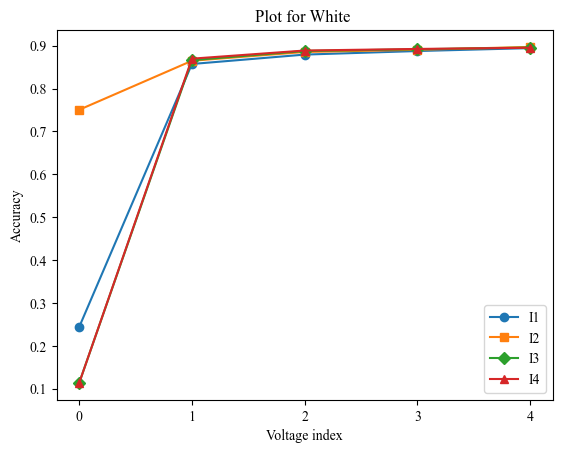

In [ ]:
# metric_values_lists = []
# colour_index = 2
# metric = "accuracy"
# markers = ['o', 's', 'D', '^', 'V'] 
# for intensity_mask in intensity_indices:
#     metric_values_lists.append(metrics_df[(metrics_df['colour mask']==colour_index) * (metrics_df['intensity mask'] == intensity_mask)][metric])

# for i, y_values in enumerate(metric_values_lists):
#     plt.plot(range(5), y_values, marker=markers[i], linestyle='-', label=f'I{i+1}')
# plt.xticks(range(5))
# plt.xlabel('Voltage index')
# plt.ylabel(metric.capitalize())
# plt.title(f"Plot for {['365nm', '455nm', 'White'][colour_index]} ")
# plt.legend()
# plt.show()

In [47]:
# train_ds, test_ds = get_datasets(mnist_data_train, mnist_data_test, combined_tables,
#                                  colour_masks=np.array([0, 1]),
#                                  intensity_masks=np.array([0, 1]),
#                                  voltage_masks=np.array([0, 1]))

# train_loader, test_loader = get_loaders(train_ds, test_ds, BATCH_SIZE)


C:\Users\adith\AppData\Local\Temp\ipykernel_1768\2995292101.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets, device=device)


In [ ]:
# get_metrics(train_loader, test_loader, number_of_devices=number_of_devices, NUMBER_OF_MASKS=2, EPOCHS=30)

Epoch [10/30], Loss: 1.3864 Validation - Accuracy: 0.7702 Precision: 0.7778  Recall: 0.7669 F1 Score: 0.7657
Epoch [20/30], Loss: 0.9660 Validation - Accuracy: 0.7973 Precision: 0.8001  Recall: 0.7955 F1 Score: 0.7956
Epoch [30/30], Loss: 0.8247 Validation - Accuracy: 0.8146 Precision: 0.8162  Recall: 0.8131 F1 Score: 0.8132


C:\Users\adith\AppData\Local\Temp\ipykernel_1768\4197052433.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 81.46%
Test Precision: 81.6220%
Test Recall: 81.3063%
Test F1 Score: 0.8132


(0.8145999908447266, 0.816219687461853, 0.8130630254745483, 0.813245415687561)